In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

import seaborn as sns
import numpy as np
import re
import metapredict as meta

import warnings
warnings.filterwarnings("ignore")
from statsmodels.nonparametric.smoothers_lowess import lowess

from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

import protfasta
import glob

/opt/anaconda3/envs/jupyter_env/lib/python3.10/site-packages/alphaPredict/backend/parrot_alpha.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  brnn_network.load_state_

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 300

In [3]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
# Define colors for the domains
AD_color = 'orange'
RD_color = 'red'
DBD_color = 'purple'

# Summary figures

For each of Caitlin's TFs, generate a panel with the following figures:
- AD / DBD/ RD annotations
- Variants
- Conservation
    - Zoonomia CDS
    - Zoonomia protein alignment
- Predictions
    - Disorder
    - Activity predictor traces
- Alpha fold structure

Plan - first make helper function for each, then later make subplots

In [5]:
# Loading in info about the ADs
cc_names = pd.read_excel("../data/gene_names_with_location_and_pmvs.xlsx")
cc_names = cc_names.rename(columns = {"gene" : "Gene", "start" : "Start", "end" : "End"})
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
cc_names = pd.merge(known_ADs[["uniprotID", "Gene", "Start", "End"]], cc_names)
ensts = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)
cc_names = pd.merge(cc_names, ensts)
cc_names["ENST"] = cc_names["ENST"].str.split(".").str[0]
cc_names["len"] = cc_names["End"] - cc_names["Start"] + 1
cc_names = cc_names.rename(columns = {"Start" : "start", "End" : "end"})
cc_names.at[9, "end"] = 93 # to make consistent with other table
cc_names

uniprotID    Gene  start   end  pMVS #   Gene Name             ENST  len
0     O94983  CAMTA2    285   468     404  CAMTA2_AD1  ENST00000348066  184
1     O94983  CAMTA2    472   581     405  CAMTA2_AD2  ENST00000348066  110
2     P11308     ERG    433   479     400     ERG_AD1  ENST00000288319   47
3     P11308     ERG    118   261     406     ERG_AD2  ENST00000288319  144
4     Q13422   IKZF1    284   365     402    IKZF1_AD  ENST00000331340   82
5     O14770   MEIS2    340   477     377    MEIS2_AD  ENST00000561208  138
6     Q15788   NCOA1   1241  1385     379   NCOA1_AD2  ENST00000348332  145
7     Q15788   NCOA1    840  1011     380   NCOA1_AD3  ENST00000348332  172
8     O95096  NKX2-2    220   273     381   NKX2-2_AD  ENST00000377142   54
9     P43354   NR4A2      1    93     382   NR4A2_AD1  ENST00000339562   91
10    P43354   NR4A2    584   598     383   NR4A2_AD2  ENST00000339562   15
11    P32242    OTX1    172   354     407     OTX1_AD  ENST00000282549  183
12    Q02548    PAX5    304   358     410     PAX5_AD  ENST00000358127   55
13    P26367    PAX6    271   422     403     PAX6_AD  ENST00000241001  152
14    P78337   PITX1    234   283     409    PITX1_AD  ENST00000265340   50

In [6]:
cc_TFs = cc_names[["uniprotID", "Gene"]].drop_duplicates()
cc_TFs

uniprotID    Gene
0     O94983  CAMTA2
2     P11308     ERG
4     Q13422   IKZF1
5     O14770   MEIS2
6     Q15788   NCOA1
8     O95096  NKX2-2
9     P43354   NR4A2
11    P32242    OTX1
12    Q02548    PAX5
13    P26367    PAX6
14    P78337   PITX1

# Helper functions

In [7]:
import itertools

def return_intervals(a):
    a = sorted(set(a))
    b = []
    for k, g in itertools.groupby(enumerate(a), 
        key=lambda t: t[1] - t[0]):
        g = list(g)
        b.append([g[0][1], g[-1][1]]) 
    
    return b
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def threshold_plot(data, x, y, legend, ax, lw, color_below, color_above, threshold, linestyle = "solid"):
    if data is None:
        data = pd.DataFrame({'x' : x, 
                             'y' : y})
        x = 'x'
        y = 'y'

    if color_below == "alpha":
        sns.lineplot(data = data, x = x, y = y, legend = legend, ax = ax, lw = lw, color = color_above, alpha = 0.4, linestyle = linestyle)
    else:
        sns.lineplot(data = data, x = x, y = y, legend = legend, ax = ax, lw = lw, color = color_below, linestyle = linestyle)

    data = data.reset_index(drop = True)
    
    above = data[(data[y] >= threshold) | pd.isnull(data[y])]
    #display(above)
    
    intervals_above = return_intervals(list(above.index))
    #print(intervals_above)
    #display(data.loc[8])
    for interval in intervals_above:
        #print(interval)
        interval_df = data.loc[interval[0] : interval[1]]
        #display(interval_df)
        sns.lineplot(data = interval_df, x = x, y = y, legend = legend, ax = ax, lw = 1, color = color_above, linestyle = linestyle)

def add_custom_legend(color_dict, ax, bbox_to_anchor = (1, 1)):
    custom_lines = [Line2D([0], [0], markersize=2, color=c, lw=4) for c in color_dict.values()]
    ax.legend(custom_lines, color_dict.keys(), bbox_to_anchor = bbox_to_anchor, frameon = False, fontsize = 'x-small', handlelength = 0.5)

def add_custom_legend_arrows(top_color, top_label, bottom_color, bottom_label, ax, center = 0.5, length = 0.2, padding = 0.05):
    #custom_lines = [Line2D([0], [0], markersize=2, color=c, lw=4) for c in color_dict.values()]

        # Create custom arrows for the legend
    custom_lines = []
    
    # Top arrow (points up)
    ax.add_patch(FancyArrowPatch(
            (1.03, center + padding), 
            (1.03, center + padding + length),  # This makes the arrow point up
            mutation_scale=10, 
            color=top_color, 
            linewidth=1,
            transform=ax.transAxes, clip_on = False
        ))
    
    ax.text(x = 1.055, y = 0.5 * (2 * center + 2 * padding + length), s= top_label, transform=ax.transAxes, fontsize = "x-small", va = "center")
             
    # Bottom arrow (points down)
    ax.add_patch(FancyArrowPatch(
            (1.03, center - padding), 
            (1.03, center - padding - length),  # This makes the arrow point down
            mutation_scale=10, 
            color=bottom_color, 
            linewidth=1,
            transform=ax.transAxes, clip_on = False
        ))
    
    ax.text(x = 1.055, y = 0.5 * (2 * center - 2 * padding - length), s= bottom_label, transform=ax.transAxes, fontsize = "x-small", va = "center")

    #ax.legend(custom_lines, color_dict.keys(), bbox_to_anchor = bbox_to_anchor, frameon = False, fontsize = 'x-small', handlelength = 0.5)


# def add_custom_legend_arrows(top_color, top_label, bottom_color, bottom_label, ax, x = 1200, center = 0.5, length = 0.2, padding = 0.05):
#     #custom_lines = [Line2D([0], [0], markersize=2, color=c, lw=4) for c in color_dict.values()]

#         # Create custom arrows for the legend
#     custom_lines = []
    
#     # Top arrow (points up)
#     ax.add_patch(FancyArrowPatch(
#             (x, center + padding), 
#             (x, center + padding + length),  # This makes the arrow point up
#             mutation_scale=10, 
#             color=top_color, 
#             linewidth=2,
#             clip_on = False
#         ))
    
#     ax.text(x = x, y = 0.5 * (2 * center + 2 * padding + length), s= top_label, fontsize = "x-small", va = "center")
             
#     # Bottom arrow (points down)
#     ax.add_patch(FancyArrowPatch(
#             (x, center - padding), 
#             (x, center - padding - length),  # This makes the arrow point down
#             mutation_scale=10, 
#             color=bottom_color, 
#             linewidth=2,
#             clip_on = False
#         ))
    
#     ax.text(x = x, y = 0.5 * (2 * center - 2 * padding - length), s= bottom_label, fontsize = "x-small", va = "center")

#     #ax.legend(custom_lines, color_dict.keys(), bbox_to_anchor = bbox_to_anchor, frameon = False, fontsize = 'x-small', handlelength = 0.5)



# 1. Annotations

In [8]:
# Loading table with all domain info
TFs_tbl = pd.read_csv("../soto_analysis/outputs/all_TFs_table_proteins.txt", sep = "\t", index_col = 0)

# Adding coordinates to cc TFs length
cc_TFs = pd.merge(cc_TFs, TFs_tbl, on = "uniprotID", how = "left")

# Adding full TF length 
lambert_TFs = pd.read_csv("../output/lambert_TFs_10-21-24_with_DBD_coords.csv")
lambert_TFs["uniprotID"] = lambert_TFs["id"].str.split("|").str[1]
lambert_TFs["len"] = lambert_TFs["ProteinSeq"].str.len()
cc_TFs = pd.merge(cc_TFs, lambert_TFs[["uniprotID", "len", "ProteinSeq"]], on = "uniprotID", how = "left")
cc_TFs = cc_TFs.fillna("0-0")
cc_TFs

uniprotID    Gene    1    2 ENSG             ENST  \
0     O94983  CAMTA2  0-0  0-0  0-0  ENST00000348066   
1     P11308     ERG  0-0  0-0  0-0  ENST00000288319   
2     Q13422   IKZF1  0-0  0-0  0-0  ENST00000331340   
3     O14770   MEIS2  0-0  0-0  0-0  ENST00000561208   
4     Q15788   NCOA1  0-0  0-0  0-0  ENST00000348332   
5     O95096  NKX2-2  0-0  0-0  0-0  ENST00000377142   
6     P43354   NR4A2  0-0  0-0  0-0  ENST00000339562   
7     P32242    OTX1  0-0  0-0  0-0  ENST00000282549   
8     Q02548    PAX5  0-0  0-0  0-0  ENST00000358127   
9     P26367    PAX6  0-0  0-0  0-0  ENST00000241001   
10    P78337   PITX1  0-0  0-0  0-0  ENST00000265340   

                         DBD_coords                AD_coords  \
0                            37-149          285-468,472-581   
1                           312-391          433-479,118-261   
2   117-139,145-167,173-195,201-224                  284-365   
3                           277-334                  340-477   
4                             26-81  1-93,1241-1385,840-1011   
5                           129-185                  220-273   
6                           261-330             1-91,584-598   
7                             39-95                  172-354   
8                            16-140                  304-358   
9                     4-128,211-267                  271-422   
10                           90-146                  234-283   

                            RD_coords Bif_coords  length   len  \
0                     205-284,535-843        0-0       1  1202   
1                      39-278,389-468        0-0       1   479   
2                               1-477        0-0       1   519   
3                             137-180        0-0       1   477   
4   62-171,312-391,652-1011,1112-1191        0-0       1  1441   
5                        8-18,112-217        0-0       1   273   
6              42-188,299-378,409-488        0-0       1   598   
7                                 0-0        0-0       1   354   
8                             316-348        0-0       1   391   
9                                 0-0        0-0       1   422   
10                    149-196,197-233        0-0       1   314   

                                           ProteinSeq  
0   MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...  
1   MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...  
2   MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...  
3   MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLH...  
4   MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...  
5   MSLTNTKTGFSVKDILDLPDTNDEEGSVAEGPEEENEGPEPAKRAG...  
6   MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...  
7   MMSYLKQPPYGMNGLGLAGPAMDLLHPSVGYPATPRKQRRERTTFT...  
8   MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...  
9   MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRIL...  
10  MDAFKGGMSLERLPEGLRPPPPPPHDMGPAFHLARPADPREPLENS...

In [9]:
# Convert string format ranges to int tuples
def return_new_ranges(col):
    split = cc_TFs[col].str.split(',')
    new_ranges = []
    for TF_ranges in split:
        new_TF_ranges = []
        for indiv_range in TF_ranges:
            new_TF_ranges.append((int(indiv_range.split("-")[0]),
                                 int(indiv_range.split("-")[1])))
        new_ranges.append(new_TF_ranges)
    
    return new_ranges

cc_TFs["DBD_ranges"] = return_new_ranges("DBD_coords")
cc_TFs["AD_ranges"] = return_new_ranges("AD_coords")
cc_TFs["RD_ranges"] = return_new_ranges("RD_coords")
cc_TFs

uniprotID    Gene    1    2 ENSG             ENST  \
0     O94983  CAMTA2  0-0  0-0  0-0  ENST00000348066   
1     P11308     ERG  0-0  0-0  0-0  ENST00000288319   
2     Q13422   IKZF1  0-0  0-0  0-0  ENST00000331340   
3     O14770   MEIS2  0-0  0-0  0-0  ENST00000561208   
4     Q15788   NCOA1  0-0  0-0  0-0  ENST00000348332   
5     O95096  NKX2-2  0-0  0-0  0-0  ENST00000377142   
6     P43354   NR4A2  0-0  0-0  0-0  ENST00000339562   
7     P32242    OTX1  0-0  0-0  0-0  ENST00000282549   
8     Q02548    PAX5  0-0  0-0  0-0  ENST00000358127   
9     P26367    PAX6  0-0  0-0  0-0  ENST00000241001   
10    P78337   PITX1  0-0  0-0  0-0  ENST00000265340   

                         DBD_coords                AD_coords  \
0                            37-149          285-468,472-581   
1                           312-391          433-479,118-261   
2   117-139,145-167,173-195,201-224                  284-365   
3                           277-334                  340-477   
4                             26-81  1-93,1241-1385,840-1011   
5                           129-185                  220-273   
6                           261-330             1-91,584-598   
7                             39-95                  172-354   
8                            16-140                  304-358   
9                     4-128,211-267                  271-422   
10                           90-146                  234-283   

                            RD_coords Bif_coords  length   len  \
0                     205-284,535-843        0-0       1  1202   
1                      39-278,389-468        0-0       1   479   
2                               1-477        0-0       1   519   
3                             137-180        0-0       1   477   
4   62-171,312-391,652-1011,1112-1191        0-0       1  1441   
5                        8-18,112-217        0-0       1   273   
6              42-188,299-378,409-488        0-0       1   598   
7                                 0-0        0-0       1   354   
8                             316-348        0-0       1   391   
9                                 0-0        0-0       1   422   
10                    149-196,197-233        0-0       1   314   

                                           ProteinSeq  \
0   MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...   
1   MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...   
2   MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...   
3   MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLH...   
4   MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...   
5   MSLTNTKTGFSVKDILDLPDTNDEEGSVAEGPEEENEGPEPAKRAG...   
6   MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...   
7   MMSYLKQPPYGMNGLGLAGPAMDLLHPSVGYPATPRKQRRERTTFT...   
8   MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...   
9   MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRIL...   
10  MDAFKGGMSLERLPEGLRPPPPPPHDMGPAFHLARPADPREPLENS...   

                                          DBD_ranges  \
0                                        [(37, 149)]   
1                                       [(312, 391)]   
2   [(117, 139), (145, 167), (173, 195), (201, 224)]   
3                                       [(277, 334)]   
4                                         [(26, 81)]   
5                                       [(129, 185)]   
6                                       [(261, 330)]   
7                                         [(39, 95)]   
8                                        [(16, 140)]   
9                             [(4, 128), (211, 267)]   
10                                       [(90, 146)]   

                               AD_ranges  \
0               [(285, 468), (472, 581)]   
1               [(433, 479), (118, 261)]   
2                           [(284, 365)]   
3                           [(340, 477)]   
4   [(1, 93), (1241, 1385), (840, 1011)]   
5                           [(220, 273)]   
6                  [(1, 91), (584, 598)]   
7                           [(172, 354)]   
8             

In [10]:
# Other domains
all_domains = pd.read_csv("../data/all_domains_cc_TFs.tsv", sep = "\t").reset_index()
domain_matches = all_domains["Domain [FT]"].str.extractall('(\d+)\.\.(\d+); \/note="(.*?)"').reset_index()
all_domains = pd.merge(all_domains, domain_matches, left_on = "index", right_on = "level_0")[["From", 0, 1, 2]]
all_domains = all_domains.rename(columns = {"From" : "uniprotID", 0: "start", 1 : "end", 2 : "domain_name"})
all_domains = pd.merge(cc_TFs[["uniprotID", "Gene"]], all_domains)
all_domains["start"] = all_domains["start"].astype(int)
all_domains["end"] = all_domains["end"].astype(int)
all_domains
#all_domains["domain_split"] = all_domains["Domain [FT]"].str.extractall('(\d+)\.\.(\d+); \/note="(.*?)"')

uniprotID    Gene  start   end      domain_name
0    O94983  CAMTA2    537   615          IPT/TIG
1    O94983  CAMTA2   1049  1078             IQ 1
2    O94983  CAMTA2   1102  1131             IQ 2
3    P11308     ERG    113   199              PNT
4    O14770   MEIS2    110   193  MEIS N-terminal
5    Q15788   NCOA1     23    80             bHLH
6    Q15788   NCOA1    109   180              PAS
7    P43354   NR4A2    360   595           NR LBD

In [11]:
def plot_rectangle(start, end, color, box_height, ax, y = 0, alpha = 0.7):
    rectangle = patches.Rectangle((start, y), width=end - start, height=box_height, linewidth=1, edgecolor='none', facecolor=color, alpha=alpha)
    ax.add_patch(rectangle)

In [12]:
def merge_intervals(intervals, threshold=10):
    # Sort intervals by their starting value
    intervals.sort(key=lambda x: x[0])
    
    merged = []
    for interval in intervals:
        if not merged:
            merged.append(interval)
        else:
            # Check if the current interval can be merged with the last one in the merged list
            if interval[0] - merged[-1][1] < threshold:
                # Merge the intervals by extending the end of the last interval
                merged[-1] = (merged[-1][0], max(merged[-1][1], interval[1]))
            else:
                # Otherwise, just add the current interval as a new entry
                merged.append(interval)
    
    return merged
    

def plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, box_height, DBD_y, AD_y, RD_y, ax, RD = True, AD_text = True, alpha = 0.7, other_domains_gene = False):

    DBD_coords = merge_intervals(DBD_coords)
    
    if other_domains_gene:
        #gray_track_y_adj = box_height
        
        gene_rows = all_domains[all_domains["Gene"] == other_domains_gene]
        gene_intervals = list(zip(gene_rows["start"], gene_rows["end"]))

        #display(gene_rows)
        #display(gene_intervals)
        
        for interval, name in zip(gene_intervals, gene_rows["domain_name"]):
            start, end = interval
            plot_rectangle(start, end, "gray", box_height, ax, y = 0, alpha = alpha)
        
            if AD_text:
                ax.text(np.mean([start, end]), 0.5 * box_height, 
                         name, 
                         fontsize='x-small', 
                         color="black", 
                         horizontalalignment='center',
                        verticalalignment='center')

                #gray_track_y_adj = 0
                

        # AD_y -= gray_track_y_adj
        # DBD_y -= gray_track_y_adj
        # RD_y -= gray_track_y_adj
    
    for start, end in AD_coords:
        #print(start, end)
        plot_rectangle(start, end, AD_color, box_height, ax, y = AD_y, alpha = alpha)

        if AD_text:
            cc_names_row = cc_names[(cc_names["end"] == end) & (cc_names["start"] == start)]

            if len(cc_names_row) > 0:
                AD_name = cc_names_row["Gene Name"].iloc[0]
                AD_name = AD_name.split("_")[-1]
                # if AD_name[-1] in ["1", "2", "3"]:
                #     AD_name = "AD" + AD_name[-1]
                ax.text(np.mean([start, end]), AD_y + 0.5 * box_height, 
                         AD_name, 
                         fontsize='x-small', 
                         color="black", 
                         horizontalalignment='center',
                        verticalalignment='center')

    if RD:
        for start, end in RD_coords:
            if (start != 0) & (end != 0):
            #print(start, end)
            
                plot_rectangle(start, end, RD_color, box_height, ax, y = RD_y , alpha = alpha)
    
                if AD_text:
                    ax.text(np.mean([start, end]), RD_y + 0.5 * box_height, 
                                 "RD", 
                                 fontsize='x-small', 
                                 color="black", 
                                 horizontalalignment='center',
                                verticalalignment='center')
        
    for start, end in DBD_coords:
        plot_rectangle(start, end, DBD_color, box_height, ax, y = DBD_y, alpha = alpha)

        if AD_text:
            ax.text(np.mean([start, end]), DBD_y + 0.5 * box_height, 
                     "DBD", 
                     fontsize='x-small', 
                     color="black", 
                     horizontalalignment='center',
                    verticalalignment='center')
        

        

In [13]:
sns.set_context('paper')

import matplotlib.patches as patches

# Plots DBD, AD, and RD annotations
def plot_annots(DBD_coords, AD_coords, RD_coords, TF_len, ax, box_height = 0.3, RD = False, other_domains_gene = False):
    
    #plt.figure(figsize = (8, 0.75))
    #ax.axhline(y = 0, color = 'black', linestyle = '-', lw = 2) 
    #ax.axhline(y = box_height, color = 'black', linestyle = '--', lw = 1, alpha = 0.1) 
    #ax.axhline(y = 2 * box_height, color = 'black', linestyle = '--', lw = 1, alpha = 0.1) 
    
    
    plot_domain_rectangles(DBD_coords, 
                           AD_coords, 
                           RD_coords, 
                           box_height,
                          DBD_y = 0.5,
                            AD_y = 0.75,
                          RD_y = 0.25, ax =ax, alpha = 0.7, RD = RD, other_domains_gene = other_domains_gene)
    
        
    # Adjust plot limits so that the rectangles are visible
    ax.set_ylim(0, 1)  # y-limits remain from 0 to 1, as the plot height is small
    #plt.axis('off')
    
    #plt.yticks([box_height / 2, box_height * 1.5], ['DBD', 'AD'])
    ax.set_yticks([])
    
    y_labels = ax.get_yticklabels()
    
    color_dict = {"AD" : AD_color, "RD" : RD_color, "DBD" : DBD_color}

    # for i, label in enumerate(y_labels):
    #     domain_type = re.search("'(.*)'", str(label))[0][1:-1]
    #     label.set_color(color_dict[domain_type])

    ax.set_xlim(0, TF_len)  # Adjust x-limits to fit rectangles (based on start and end values)
    ax.set_ylim(0, 0.75 + box_height)
    ax.set_xlabel("Protein Residue", labelpad = 0)
    
    # ax2 = ax.twiny()
    # ax2.xaxis.set_ticks_position("bottom")
    # ax2.xaxis.set_label_position("bottom")
    # new_tick_locations = np.arange(0, TF_len * 3 + 1, 300)
    # ax2.spines["bottom"].set_position(("axes", -1))
    
    # ax2.spines["bottom"].set_color(sns.color_palette('tab10')[2])
    
    # #ax2.set_frame_on(True)
    # #ax2.patch.set_visible(False)
    
    # # for sp in ax2.spines.itervalues():
    # #     sp.set_visible(False)
    # #ax2.spines["bottom"].set_visible(True)
    
    # ax2.set_xticks(new_tick_locations)
    # #ax2.set_xticklabels(new_tick_locations)
    # ax2.tick_params(axis='x', colors=sns.color_palette('tab10')[2])
    # ax2.set_xlabel(r"CDS Nucleotide", color = sns.color_palette('tab10')[2], labelpad = 0)
    # sns.despine(left = True, ax = ax2)

    plot_domain_rectangles(cc_TFs["DBD_ranges"].iloc[i], 
                           cc_TFs["AD_ranges"].iloc[i], 
                           cc_TFs["RD_ranges"].iloc[i], 1, 
                           RD = False, AD_text = False, alpha = 0.15,
                          DBD_y = 0., 
                           AD_y = 0, 
                           RD_y = 0, 
                           ax = ax)

    sns.despine(left = True, ax = ax)


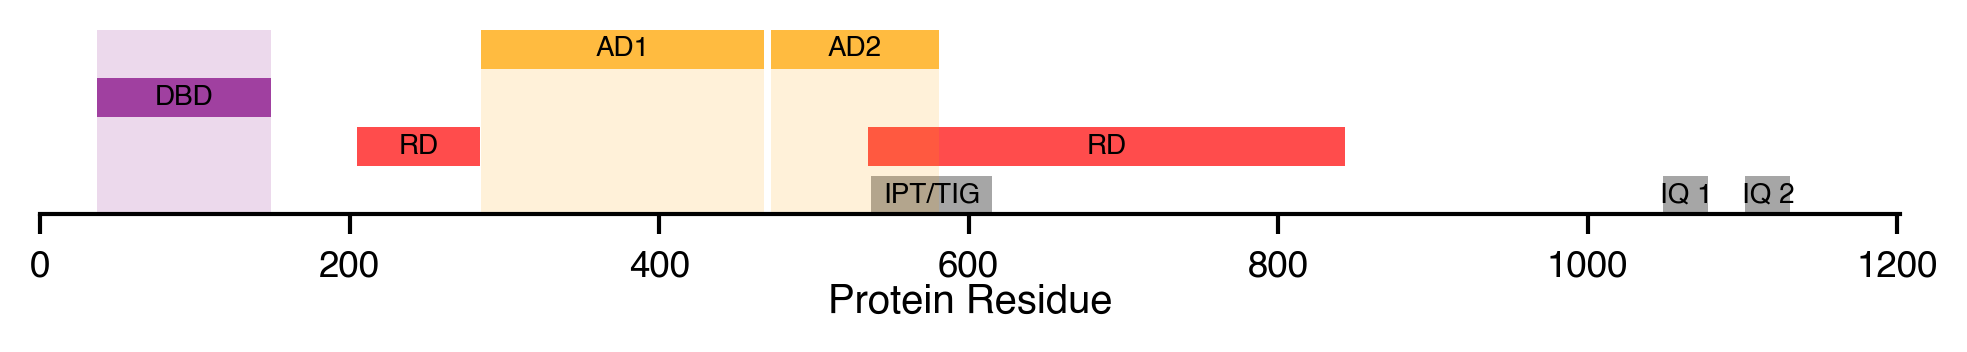

In [14]:
for i in [cc_TFs.index[0]]:
#for i in cc_TFs.index:
    #print(cc_TFs["Gene"].iloc[i])
    
    fig, ax = plt.subplots(figsize=(8,0.8))
    
    
    plot_annots(cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                cc_TFs["len"].iloc[i], 
                ax, 
                box_height = 0.2,
               other_domains_gene = cc_TFs["Gene"].iloc[i], RD = True)


    #plt.title(cc_TFs["Gene"].iloc[i])

# 2. Disorder

In [15]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [16]:
from matplotlib.lines import Line2D

In [17]:
def plot_disorder(gene, DBD_coords, AD_coords, RD_coords, ax):
    tbl_row = cc_TFs[cc_TFs["Gene"] == gene]
    disorder = meta.predict_disorder(tbl_row["ProteinSeq"].iloc[0])
    ax.axhline(0.5, color = "gray", linestyle = "--", alpha = 0.7)

    #sns.lineplot(x = np.arange(len(disorder)), y = disorder, ax = ax, color = sns.color_palette('colorblind')[7])

    data = pd.DataFrame({'pos' : np.arange(len(disorder)), 'disorder': disorder})
    
    threshold_plot(data = data, 
                   x = 'pos', 
                   y = 'disorder', 
                   legend = True, 
                   ax = ax, 
                   lw = 1, 
                   color_below = "silver", 
                   color_above = sns.color_palette('colorblind')[2], 
                   threshold = 0.5)
    
    ax.set_xlim(0, len(disorder))


    plot_domain_rectangles(DBD_coords, 
                    AD_coords, 
                    RD_coords, 1, RD = False, AD_text = False, alpha = 0.15,
                              DBD_y = 0, AD_y = 0, RD_y = 0, ax = ax)

    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Disorder")
    #plt.title(cc_TFs["Gene"].iloc[i])
    sns.despine()



    # ax.text(max(data['pos']), 0.52, 'Disordered', ha = "left", va = "bottom", color = sns.color_palette('colorblind')[2])
    # ax.text(max(data['pos']), 0.48, 'Folded', ha = "left", va = "top", color = "gray")

    #plt.show()

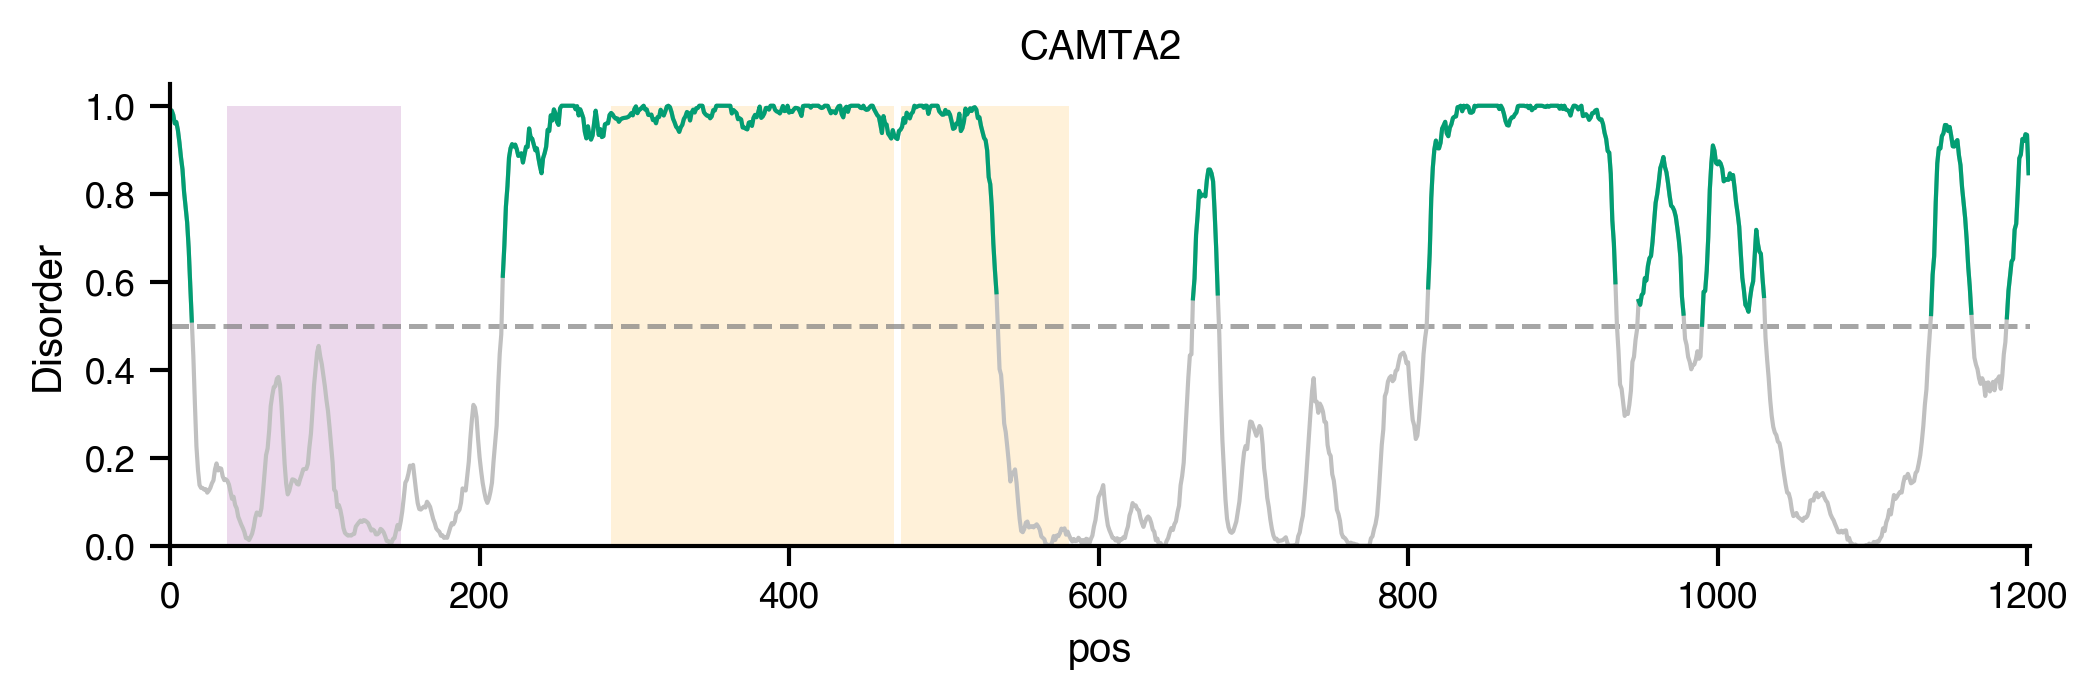

In [18]:
for i in [cc_TFs.index[0]]:
#for i in cc_TFs.index:
    fig, ax = plt.subplots(figsize=(8, 2))
    
    plot_disorder(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                 ax = ax)
    
plt.title(cc_TFs["Gene"].iloc[i]);

# 3. Activity predictor traces

In [19]:
# From Savio, adding predictions
preds = pd.read_csv("../data/TF_vs_preds.csv", index_col = 0)
for col in preds.columns[1:]:
    preds[col] = preds[col].str[1:-1].str.replace(" ", "").str.split(",")
    preds[col] = [[float(_) for _ in str_list] for str_list in preds[col]]
preds.head(3)

sequence  \
0  MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...   
1  MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...   
2  MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...   

                                      paddle_centers  \
0  [27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....   
1  [27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....   
2  [27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34....   

                                        paddle_preds  \
0  [-0.013730620965361595, 0.0014786720275878906,...   
1  [0.9733560681343079, 1.054497480392456, 1.2690...   
2  [0.25299009680747986, 0.23928268253803253, 0.2...   

                                        adpred_preds  \
0  [7.913487206678838e-05, 0.00014801321958657354...   
1  [0.0013774175895377994, 0.0013188828015699983,...   
2  [0.00044040323700755835, 0.000509298755787313,...   

                                    adhunter_centers  \
0  [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....   
1  [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....   
2  [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....   

                                      adhunter_preds  \
0  [26216.078125, 31656.94921875, 30135.41796875,...   
1  [25586.890625, 28581.703125, 26968.62109375, 2...   
2  [21660.34375, 17697.7578125, 16628.2265625, 17...   

                                        tada_centers  \
0  [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....   
1  [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....   
2  [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....   

                                          tada_preds  
0  [0.16262038052082062, 0.1649646908044815, 0.17...  
1  [0.37093856930732727, 0.3930017352104187, 0.41...  
2  [0.23211979866027832, 0.21539030969142914, 0.2...

In [20]:
cc_TFs = pd.merge(cc_TFs, preds, left_on = "ProteinSeq", right_on = "sequence", how = "left")
cc_TFs

uniprotID    Gene    1    2 ENSG             ENST  \
0     O94983  CAMTA2  0-0  0-0  0-0  ENST00000348066   
1     P11308     ERG  0-0  0-0  0-0  ENST00000288319   
2     Q13422   IKZF1  0-0  0-0  0-0  ENST00000331340   
3     O14770   MEIS2  0-0  0-0  0-0  ENST00000561208   
4     Q15788   NCOA1  0-0  0-0  0-0  ENST00000348332   
5     O95096  NKX2-2  0-0  0-0  0-0  ENST00000377142   
6     P43354   NR4A2  0-0  0-0  0-0  ENST00000339562   
7     P32242    OTX1  0-0  0-0  0-0  ENST00000282549   
8     Q02548    PAX5  0-0  0-0  0-0  ENST00000358127   
9     P26367    PAX6  0-0  0-0  0-0  ENST00000241001   
10    P78337   PITX1  0-0  0-0  0-0  ENST00000265340   

                         DBD_coords                AD_coords  \
0                            37-149          285-468,472-581   
1                           312-391          433-479,118-261   
2   117-139,145-167,173-195,201-224                  284-365   
3                           277-334                  340-477   
4                             26-81  1-93,1241-1385,840-1011   
5                           129-185                  220-273   
6                           261-330             1-91,584-598   
7                             39-95                  172-354   
8                            16-140                  304-358   
9                     4-128,211-267                  271-422   
10                           90-146                  234-283   

                            RD_coords Bif_coords  ...  \
0                     205-284,535-843        0-0  ...   
1                      39-278,389-468        0-0  ...   
2                               1-477        0-0  ...   
3                             137-180        0-0  ...   
4   62-171,312-391,652-1011,1112-1191        0-0  ...   
5                        8-18,112-217        0-0  ...   
6              42-188,299-378,409-488        0-0  ...   
7                                 0-0        0-0  ...   
8                             316-348        0-0  ...   
9                                 0-0        0-0  ...   
10                    149-196,197-233        0-0  ...   

                               AD_ranges  \
0               [(285, 468), (472, 581)]   
1               [(433, 479), (118, 261)]   
2                           [(284, 365)]   
3                           [(340, 477)]   
4   [(1, 93), (1241, 1385), (840, 1011)]   
5                           [(220, 273)]   
6                  [(1, 91), (584, 598)]   
7                           [(172, 354)]   
8                           [(304, 358)]   
9                           [(271, 422)]   
10                          [(234, 283)]   

                                            RD_ranges  \
0                            [(205, 284), (535, 843)]   
1                             [(39, 278), (389, 468)]   
2                                          [(1, 477)]   
3                                        [(137, 180)]   
4   [(62, 171), (312, 391), (652, 1011), (1112, 11...   
5                               [(8, 18), (112, 217)]   
6                 [(42, 188), (299, 378), (409, 488)]   
7                                            [(0, 0)]   
8                                        [(316, 348)]   
9                                            [(0, 0)]   
10                           [(149, 196), (197, 233)]   

                                             sequence  \
0   MNTKDTTEVAENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTNEE...   
1   MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...   
2   MDADEGQDMSQVSGKESPPVSDTPDEGDEPMPIPEDLSTTSGGQQS...   
3   MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLH...   
4   MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...   
5   MSLTNTKTGFSVKDILDLPDTNDEEGSVAEGPEEENEGPEPAKRAG...   
6   MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...   
7   MMSYLKQPPYGMNGLGLAGPAMDLLHPSVGYPATPRKQRRERTTFT...   
8   MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...   
9   MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRIL...   
10  MDAFKGGMSLERLPEGLRPPPPPPHDMGPAF

In [21]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [22]:
def norm_preds(preds, threshold):
    return (np.array(preds) - threshold)

def plot_preds(gene, DBD_coords, AD_coords, RD_coords, ax):
    row = cc_TFs[cc_TFs["Gene"] == gene]
    sequence = row["sequence"].iloc[0]
    paddle_centers, paddle_preds = row["paddle_centers"].iloc[0], row["paddle_preds"].iloc[0]
    adpred_preds = row["adpred_preds"].iloc[0]
    adhunter_centers, adhunter_preds = row["adhunter_centers"].iloc[0], row["adhunter_preds"].iloc[0]
    tada_centers, tada_preds = row["tada_centers"].iloc[0], row["tada_preds"].iloc[0]

    #fig, ax = plt.subplots(figsize=(8, 1))

        # Normalizing all to 0.8
    # ax.plot([0, len(sequence)-1], [.8, .8], '-', c='orange')
    # ax.plot([0, len(sequence)-1], [4/5, 4/5], '-', c='b')
    # ax.plot([0, len(sequence)-1], [100000/125000, 100000/125000], '-', c='green')
    # ax.plot([0, len(sequence)-1], [.5 / 0.625, .5 / 0.625], '-', c='red')
    ax.plot([0, len(sequence)-1], [.8, .8], '--', c='gray', alpha = 0.7, lw = 1)



    # Plot activity traces for all three predictors and their activity thresholds
    ax.plot(paddle_centers, np.array(paddle_preds) / 5, c=sns.color_palette('colorblind')[1], label='PADDLE', lw = 1)
    ax.plot(np.arange(len(sequence)), adpred_preds, c=sns.color_palette('colorblind')[2], label='ADPred', lw = 1)
    ax.plot(adhunter_centers, np.array(adhunter_preds) / 125000, c=sns.color_palette('colorblind')[3], label='ADHunter', lw = 1)
    ax.plot(tada_centers, np.array(tada_preds) / 0.625, c=sns.color_palette('colorblind')[4], label='TADA', lw = 1)
    
    
    

    # threshold_plot(data = None, 
    #                x = paddle_centers, 
    #                y = np.array(paddle_preds) / 5, 
    #                legend = False, 
    #                ax = ax, 
    #                lw = 1, 
    #                color_below = "alpha", 
    #                color_above = sns.color_palette('colorblind')[1], 
    #                threshold = 0.8, linestyle = "solid") 

    # threshold_plot(data = None, 
    #                x = np.arange(len(sequence)), 
    #                y = adpred_preds, 
    #                legend = False, 
    #                ax = ax, 
    #                lw = 1, 
    #                color_below = "alpha", 
    #                color_above = sns.color_palette('colorblind')[2], 
    #                threshold = 0.8, linestyle = "solid") 
    
    # threshold_plot(data = None, 
    #                x = adhunter_centers, 
    #                y = np.array(adhunter_preds) / 125000, 
    #                legend = False, 
    #                ax = ax, 
    #                lw = 1, 
    #                color_below = "alpha", 
    #                color_above = sns.color_palette('colorblind')[3], 
    #                threshold = 0.8, linestyle = "solid") 

    # threshold_plot(data = None, 
    #                x = tada_centers, 
    #                y = np.array(tada_preds) / 0.625, 
    #                legend = False, 
    #                ax = ax, 
    #                lw = 1, 
    #                color_below = "alpha", 
    #                color_above = sns.color_palette('colorblind')[4], 
    #                threshold = 0.8) 

    #ax.plot(paddle_centers, np.array(paddle_preds) / 5, c=sns.color_palette('colorblind')[1], label='PADDLE', lw = 1)
    # ax.plot(np.arange(len(sequence)), adpred_preds, c=sns.color_palette('colorblind')[2], label='ADPred', lw = 1)
    # ax.plot(adhunter_centers, np.array(adhunter_preds) / 125000, c=sns.color_palette('colorblind')[3], label='ADHunter', lw = 1)
    # ax.plot(tada_centers, np.array(tada_preds) / 0.625, c=sns.color_palette('colorblind')[4], label='TADA', lw = 1)

    max_val = max(
        np.max(np.array(paddle_preds) / 5),
        np.max(adpred_preds),
        np.max(np.array(adhunter_preds) / 125000),
        np.max(np.array(tada_preds) / 0.625), 
        0.8
    )
    


    #ax.set_title(cc_TFs["Gene"].iloc[i])
    #ax.legend(bbox_to_anchor=(1, 1.05))    
    ax.set_ylim(0, max_val + 0.1)
    ax.margins(x=0)



    min_y = 0
    max_y = max_val + 0.1
    
    center_pos = (0.8 - min_y) / (max_y - min_y)
    add_custom_legend_arrows(top_color = "black",
                         top_label = "Active",
                         bottom_color = sns.color_palette('colorblind')[-3],
                         bottom_label = "Inactive", ax = ax, 
                 center = center_pos, length = 0.3 / 1.5, padding = 0.01)

    #ax.set_xlabel('Tile Center Position')
    ax.set_ylabel('Predicted\nActivity')

    ax.set_yticks([0, 0.8])         # Only show the x-axis tick at 0
    ax.set_yticklabels([0, 'Threshold'])
    
    for label in ax.get_yticklabels():
        label.set_rotation(90)  # Rotate the labels by 90 degrees
        label.set_verticalalignment('center')  # Center-align vertically

    #plt.text(0.1, 0.85, s = " Active")
    
    # Plot protein sequence on a secondary x-axis
    # Comment out this block of code if it looks too messy for you
    # ax2 = ax.twiny()
    # ax2.set_xticks(np.arange(len(sequence)))
    # ax2.set_xticklabels([aa for aa in sequence], fontsize=3)
    
    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, max_val, RD = False, AD_text = False, alpha = 0.15,
                          DBD_y = 0, AD_y = 0, RD_y = 0, ax = ax)
    sns.despine()

    
    # Plot activity traces for all three predictors and their activity thresholds
    y_adj = max_val * 0.3 / 1.730850125
    
    # plt.text(0, max_val, "PADDLE", ha = 'left', color = "b")
    # plt.text(0, max_val - y_adj, "ADPred", ha = 'left', color = "orange")
    # plt.text(0, max_val - 2 * y_adj, "ADHunter", ha = 'left', color = "green")
    # plt.text(0, max_val - 3 * y_adj, "TADA", ha = 'left', color = "red")



    rectangle = patches.Rectangle((0, 0.92), 
                                  width=1, 
                                  height=0.15, 
                                  linewidth=1, 
                                  edgecolor='none', 
                                  facecolor="white", 
                                  alpha=1,
                                  transform=ax.transAxes)
    ax.add_patch(rectangle)

    ax.text(0.99, 0.96, "PADDLE", ha = 'right', va = 'center', color = sns.color_palette('colorblind')[1], transform=ax.transAxes, fontsize = "x-small")
    ax.text(0.8, 0.96, "ADPred", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[2], transform=ax.transAxes, fontsize = "x-small")
    ax.text(0.69, 0.96, "ADHunter", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[3], transform=ax.transAxes, fontsize = "x-small")
    ax.text(0.62, 0.96, "TADA", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[4], transform=ax.transAxes, fontsize = "x-small")
    ax.text(0.525, 0.96, "Legend:", ha = "left", va = 'center', color = "black", transform=ax.transAxes, fontsize = "x-small")
    
    # ax.text(1.01, 1, "Legend:", ha = "left", va = 'center', color = "black", transform=ax.transAxes, fontsize = 8)
    # ax.text(1.01, 0.9, "PADDLE", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[1], transform=ax.transAxes, fontsize = 8)
    # ax.text(1.01, 0.8, "ADPred", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[2], transform=ax.transAxes, fontsize = 8)
    # ax.text(1.01, 0.7, "ADHunter", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[3], transform=ax.transAxes, fontsize = 8)
    # ax.text(1.01, 0.6, "TADA", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[4], transform=ax.transAxes, fontsize = 8)

    #ax.legend(bbox_to_anchor=(1.01, 1))


    
    #pdf.savefig()
    #plt.show()
    
#pdf.close()

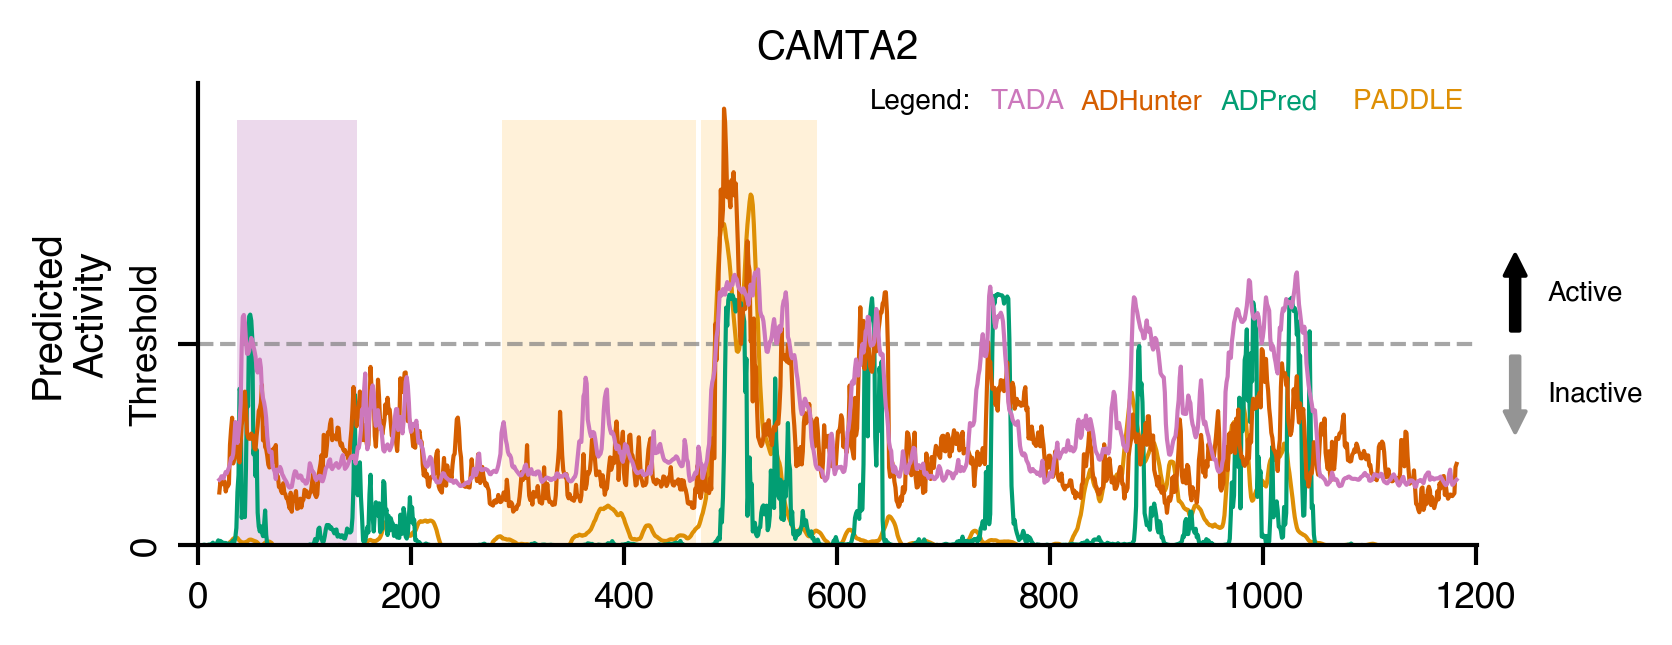

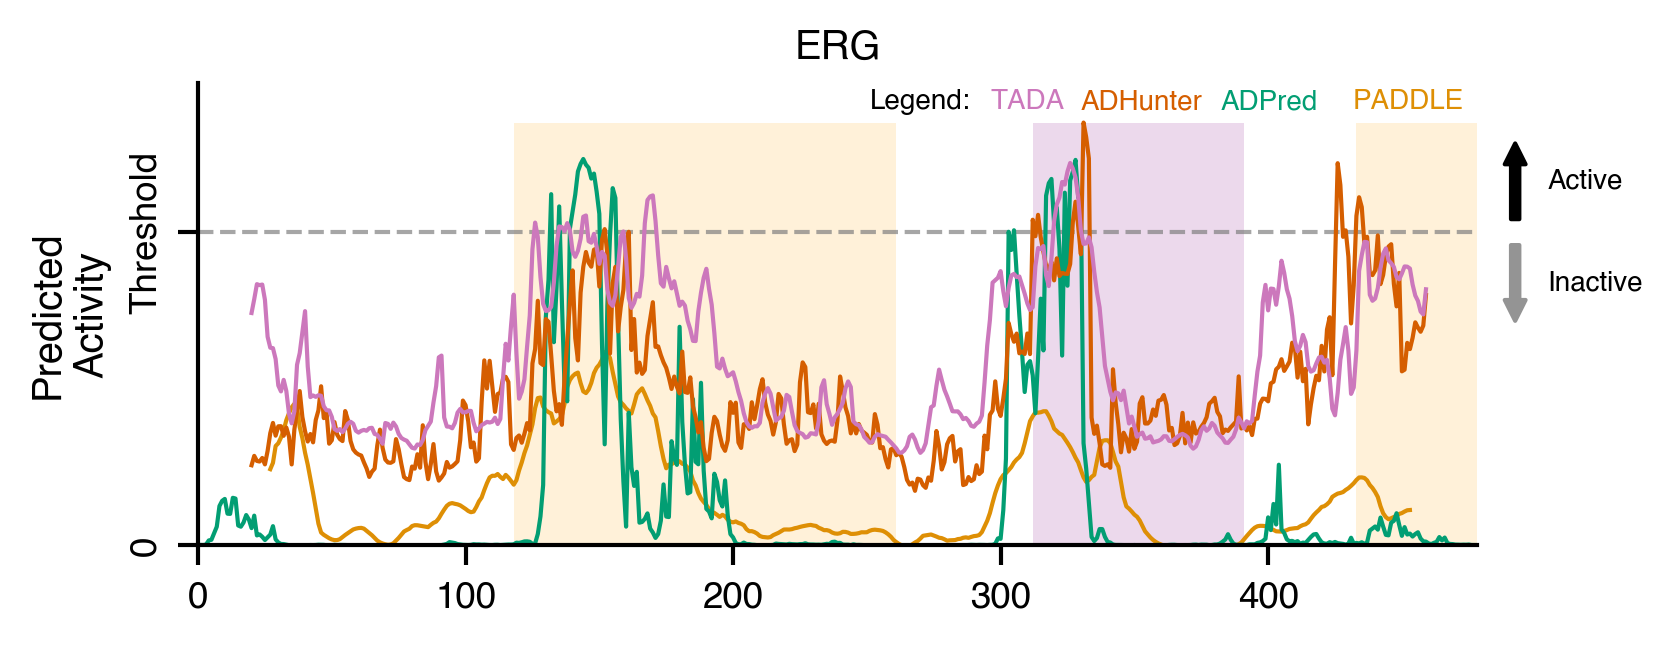

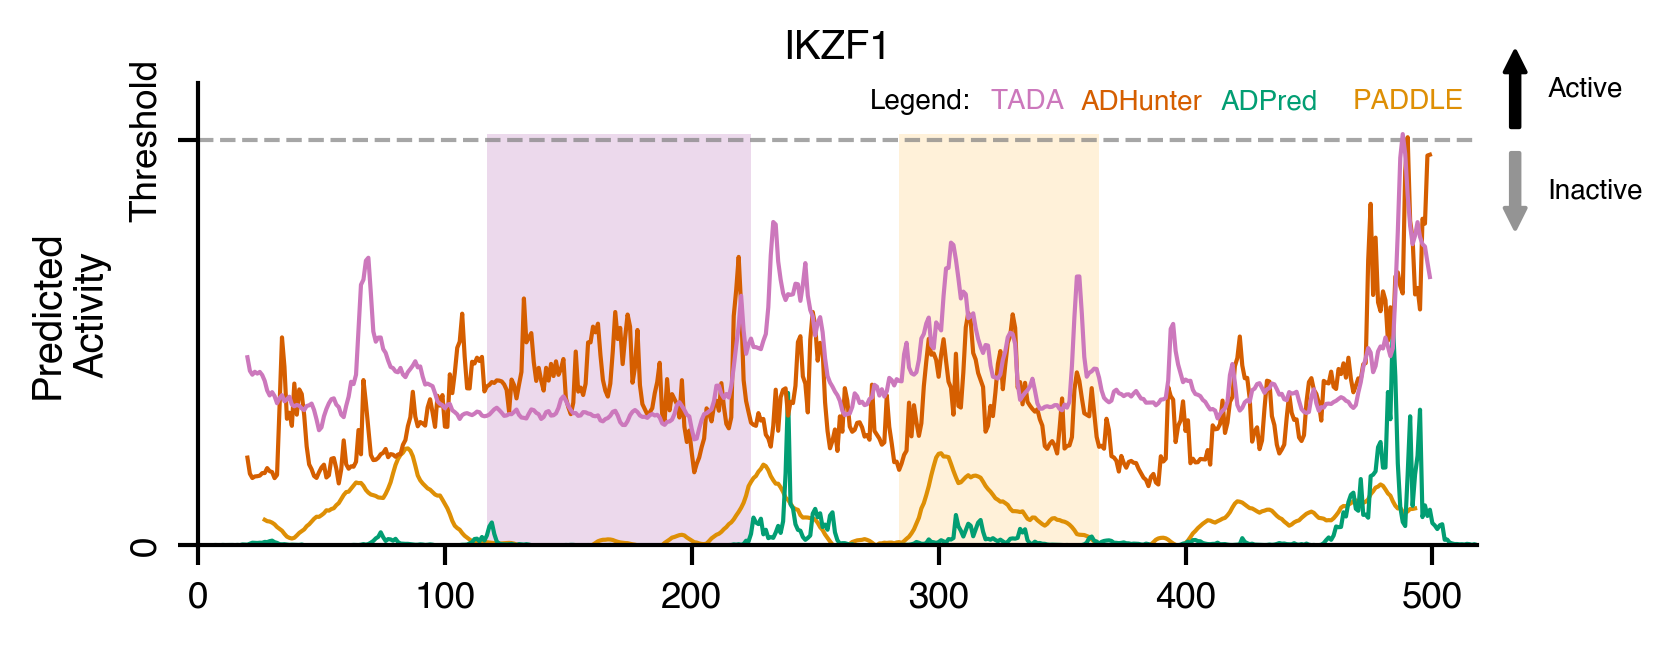

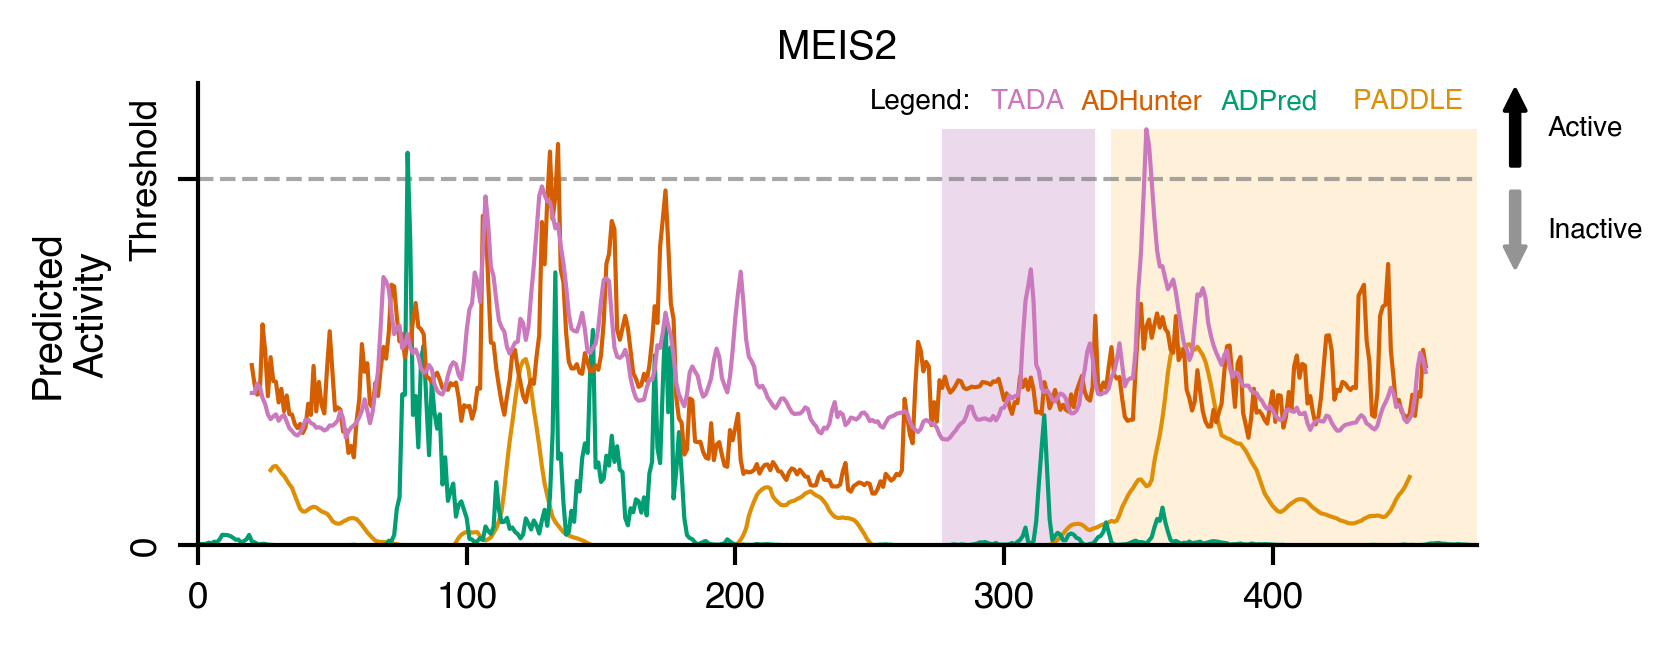

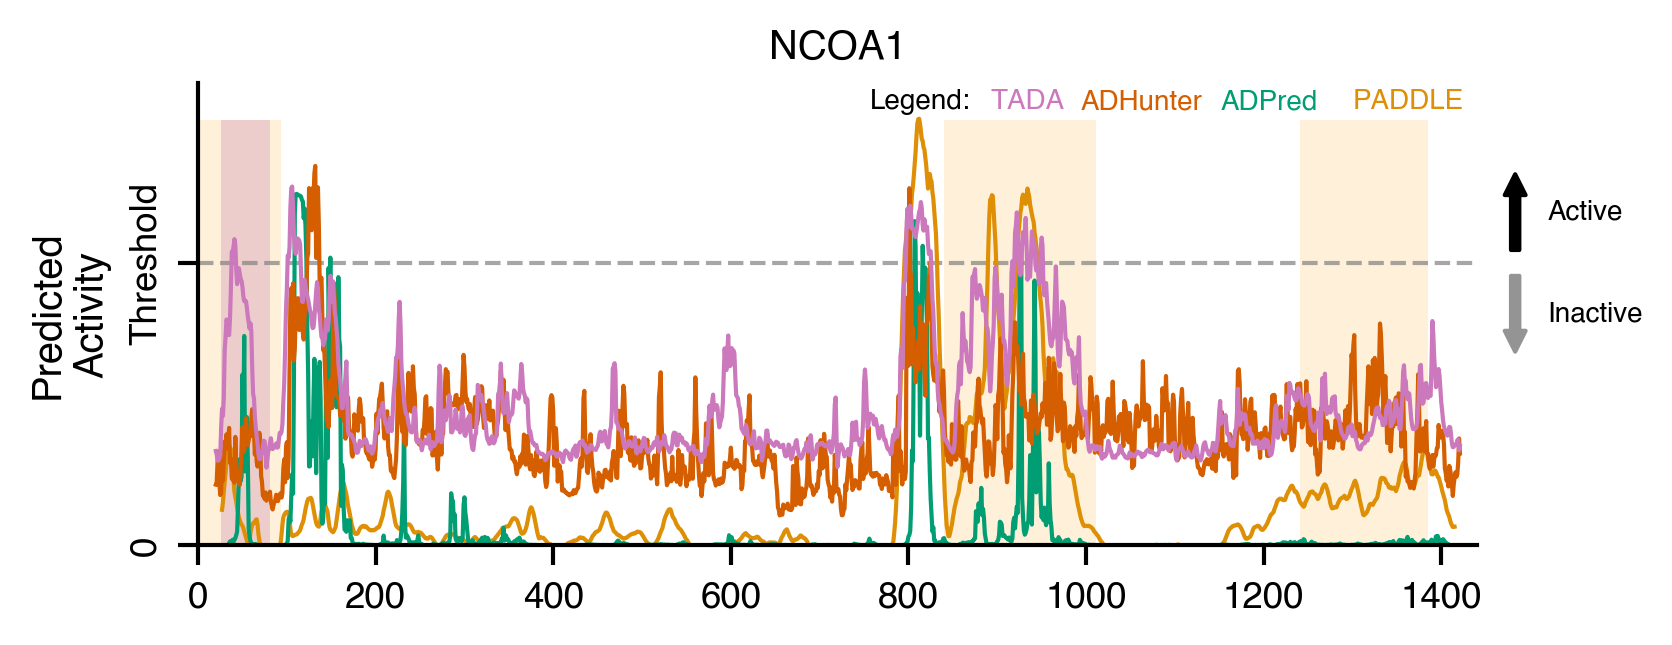

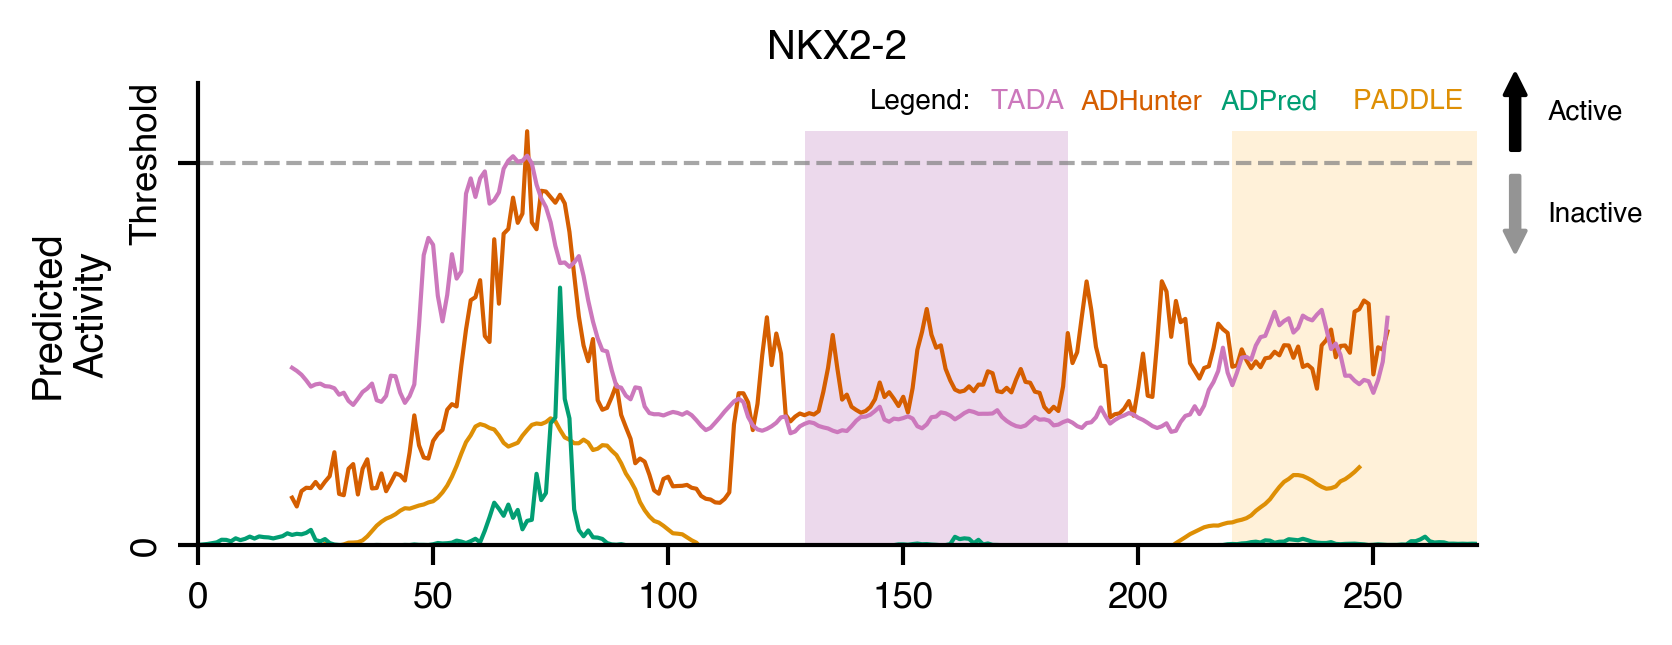

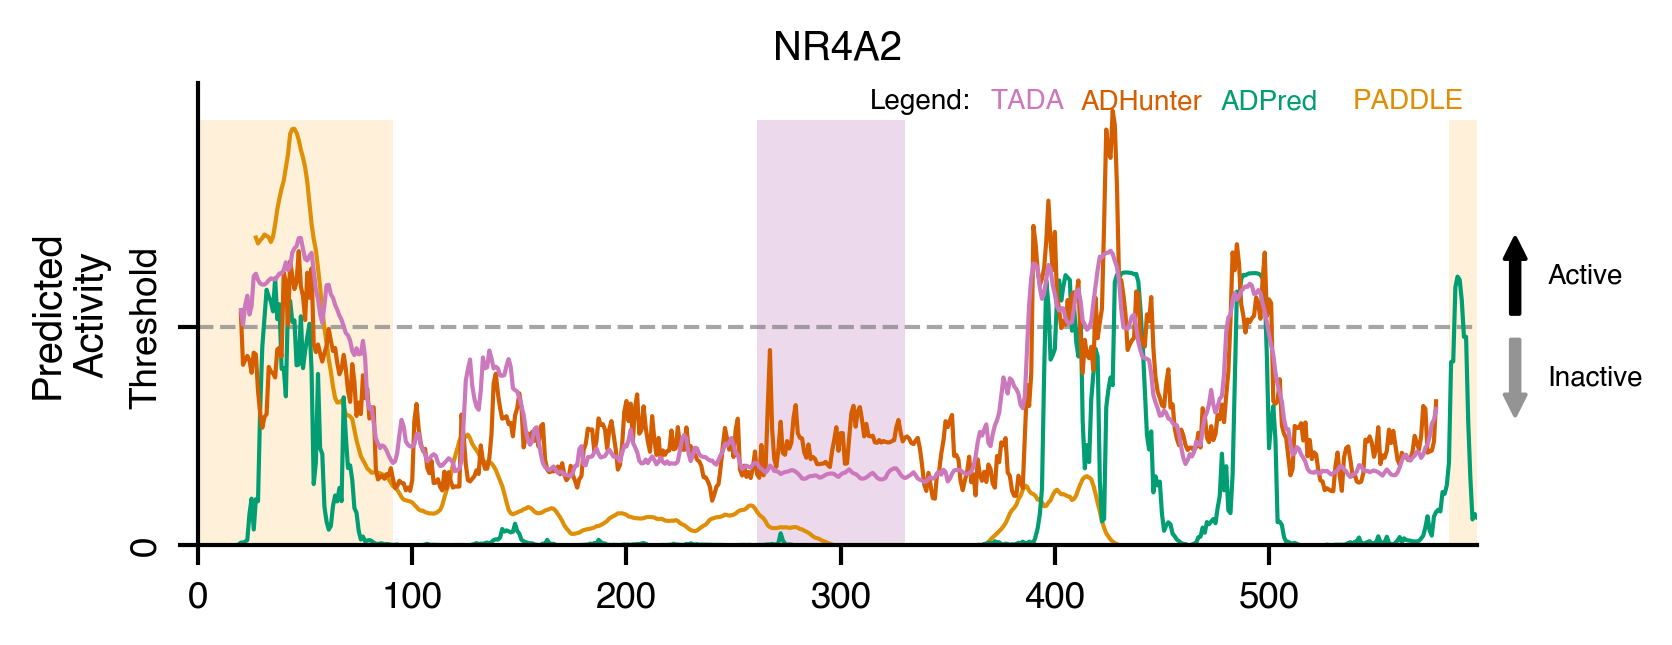

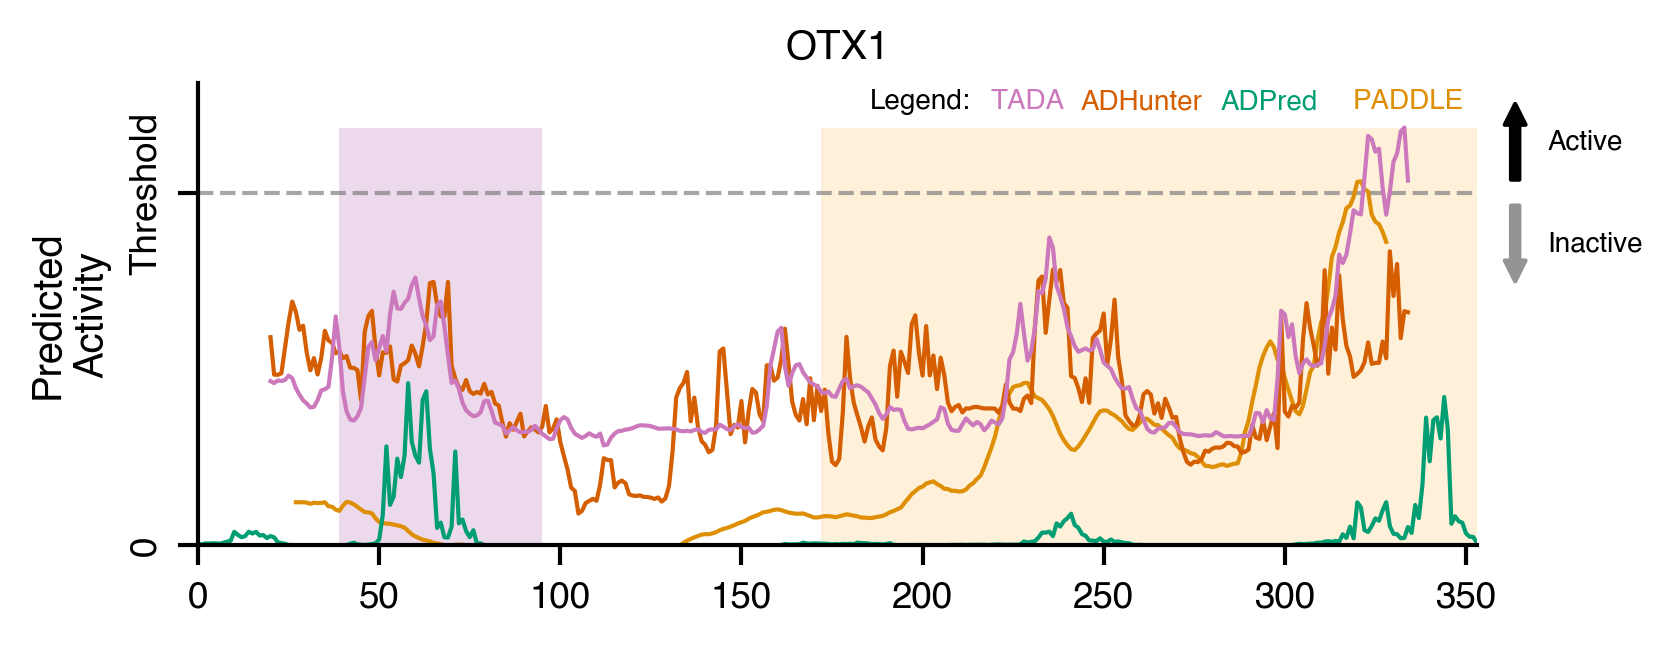

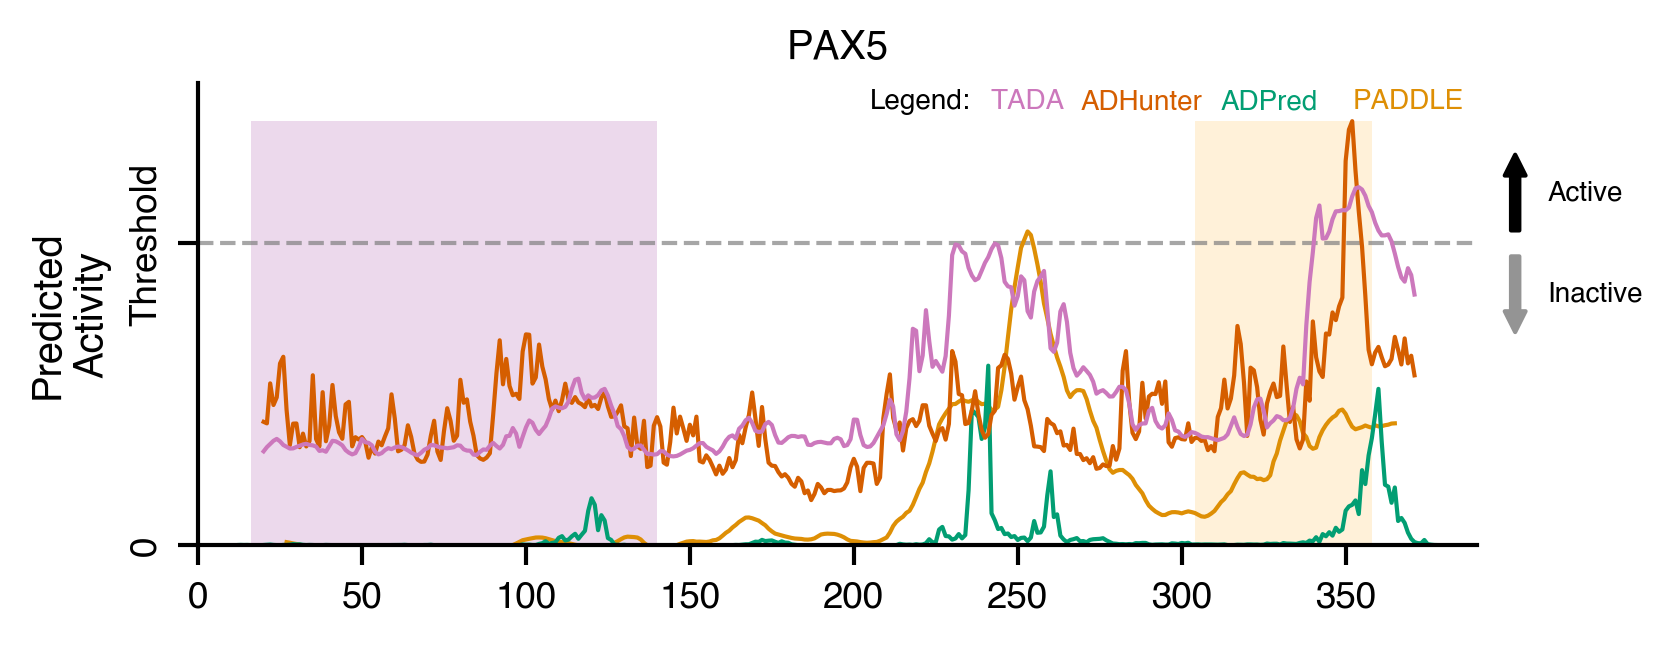

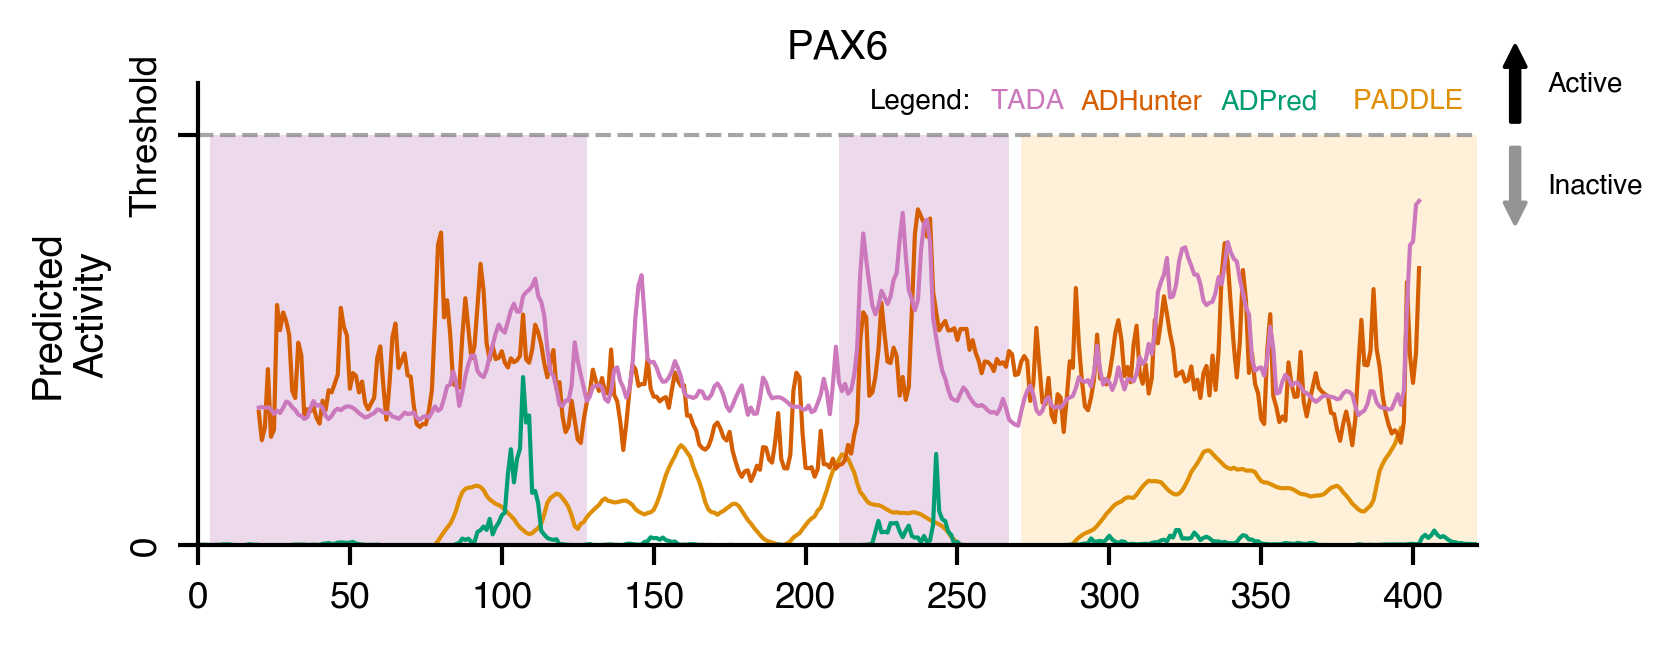

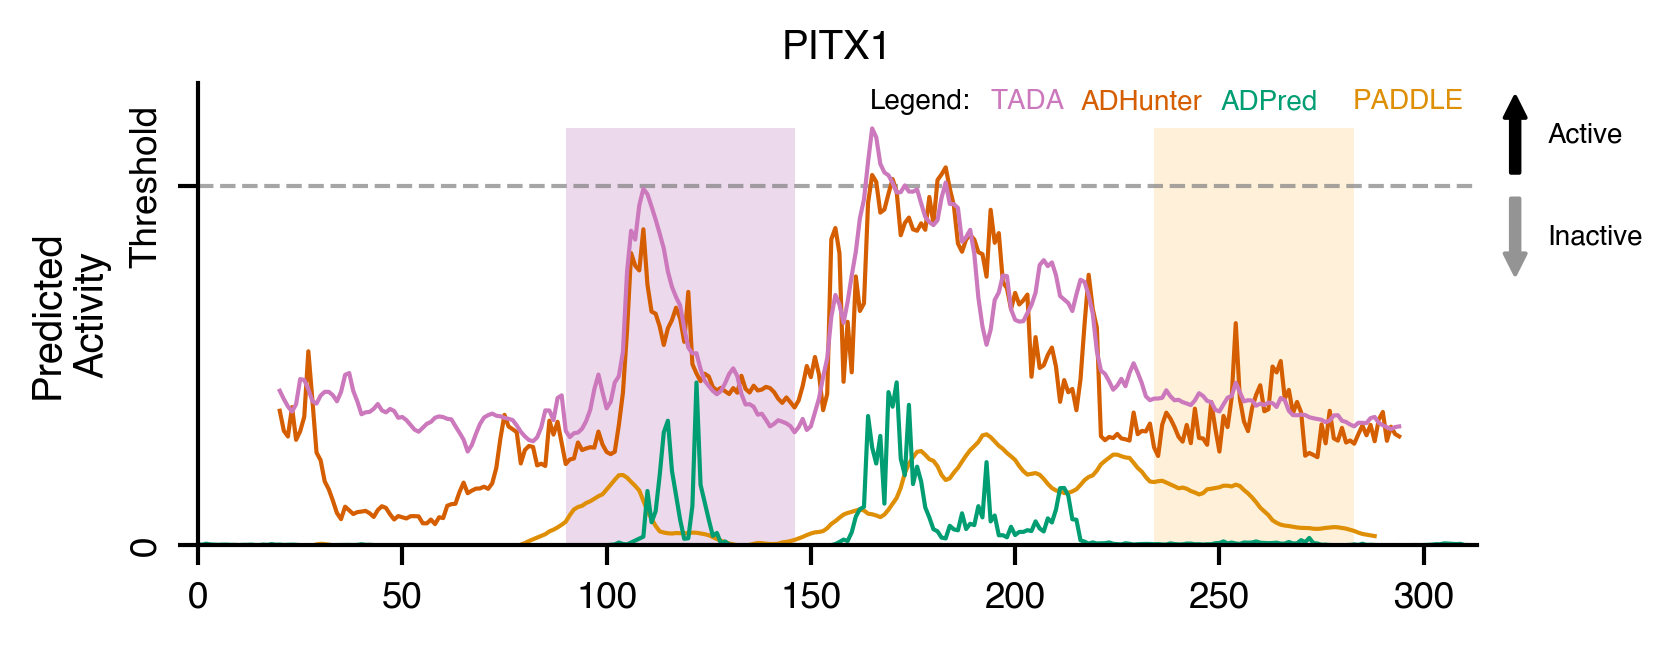

In [23]:
#for i in [cc_TFs.index[0]]:
for i in cc_TFs.dropna().index:
    fig, ax = plt.subplots(figsize=(5.5, 2))
    plot_preds(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax);
    plt.title(cc_TFs["Gene"].iloc[i])

# 4. Conservation

## 4A. CDS

In [24]:
cds_phylo_P = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_zoonomia_all_TF_cds/*")
for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
    df = pd.read_csv(path, sep = "\t", header = None)
    cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {3: "ENST", 8: "PhyloP"})
cds_phylo_P

0         1         2             ENST  4   5         6         7  \
0      2  27149134  27149135  ENST00000296096  1   2  27149134  27149135   
1      2  27149135  27149136  ENST00000296096  1   2  27149135  27149136   
2      2  27149136  27149137  ENST00000296096  1   2  27149136  27149137   
3      2  27149137  27149138  ENST00000296096  1   2  27149137  27149138   
4      2  27149138  27149139  ENST00000296096  1   2  27149138  27149139   
...   ..       ...       ...              ... ..  ..       ...       ...   
3850  16  49822681  49822682  ENST00000561648 -1  16  49822681  49822682   
3851  16  49822682  49822683  ENST00000561648 -1  16  49822682  49822683   
3852  16  49822683  49822684  ENST00000561648 -1  16  49822683  49822684   
3853  16  49822684  49822685  ENST00000561648 -1  16  49822684  49822685   
3854  16  49822685  49822686  ENST00000561648 -1  16  49822685  49822686   

      PhyloP  
0      4.624  
1      6.891  
2      1.666  
3      5.833  
4     -0.157  
...      ...  
3850   0.452  
3851  -0.104  
3852  -0.824  
3853   0.588  
3854   2.505  

[2753376 rows x 9 columns]

In [25]:
import seaborn.objects as so


In [26]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [27]:
def plot_cds_trace(gene, DBD_coords, AD_coords, RD_coords, ax, x_axis_spacing = 600):
    ENST = cc_names[cc_names["Gene"] == gene]["ENST"].iloc[0]
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    
    if ENST_phylo_P[4].iloc[0] == -1:
        ascending = False
    else: 
        #print("pos")
        ascending = True
        
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    ENST_phylo_P["cds_nt"] = np.arange(len(ENST_phylo_P)) / 3

    smoothed = lowess(ENST_phylo_P['PhyloP'], 
                      ENST_phylo_P["cds_nt"], 
                      frac=0.01)  # Adjust frac for smoothness
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])

    # sns.scatterplot(data=ENST_phylo_P, 
    #                 x="cds_nt", 
    #                 y='PhyloP', 
    #                 color='black', 
    #                 alpha = 0.1, 
    #                 size = 10, 
    #                 legend = False,
    #                ax = ax)    
    
    cutoff_y = np.percentile(ENST_phylo_P['PhyloP'], 1)
    y_range = max(ENST_phylo_P["PhyloP"]) + 1 - cutoff_y
    
    h = ax.hist2d(data=ENST_phylo_P, 
                    x="cds_nt", 
                    y='PhyloP', cmap  = 'binary', bins = [len(smoothed_df) // 25, int(y_range) * 5], alpha =1)
    #fig.colorbar(h[3], ax=ax)
    
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color=sns.color_palette('colorblind')[0], ax = ax, lw = 1.5, alpha = 0.7)   


    new_DBD_coords = DBD_coords
    new_AD_coords = AD_coords
    
    # new_DBD_coords = []
    # new_AD_coords = []

    # for start, end in DBD_coords:
    #     new_DBD_coords.append((start * 3, end * 3))
    
    # for start, end in AD_coords:
    #     new_AD_coords.append((start * 3, end * 3))
        
    plot_domain_rectangles(new_DBD_coords, new_AD_coords, RD_coords, max(ENST_phylo_P["PhyloP"]) - min(ENST_phylo_P["PhyloP"]) + 2, 
                           RD = False, AD_text = False, alpha = 0.15,
                          DBD_y = min(ENST_phylo_P["PhyloP"]) - 1, 
                           AD_y = min(ENST_phylo_P["PhyloP"]) - 1, 
                           RD_y = min(ENST_phylo_P["PhyloP"]) - 1, 
                           ax = ax)
    
    sns.despine()
    ax.set_xlim(0, max(smoothed_df["cds_nt"]) + 1)


    ax.set_ylim(cutoff_y, max(ENST_phylo_P["PhyloP"]) + 1)
    
    ax.set_ylabel("Zoonomia\nPhyloP")
    # ax.set_xlabel('CDS Nucloetide', color = sns.color_palette('tab10')[2], labelpad = 0) 

    #ax.set_xticks(np.arange(0, max(ENST_phylo_P["cds_nt"]) + 1, x_axis_spacing))
    #ax.tick_params(axis='x', colors=sns.color_palette('tab10')[2])
    #ax.spines["bottom"].set_color(sns.color_palette('tab10')[2])
    
    ax.axhline(0, color = "gray", linestyle = "--", alpha = 0.7)
    #plt.title(gene)

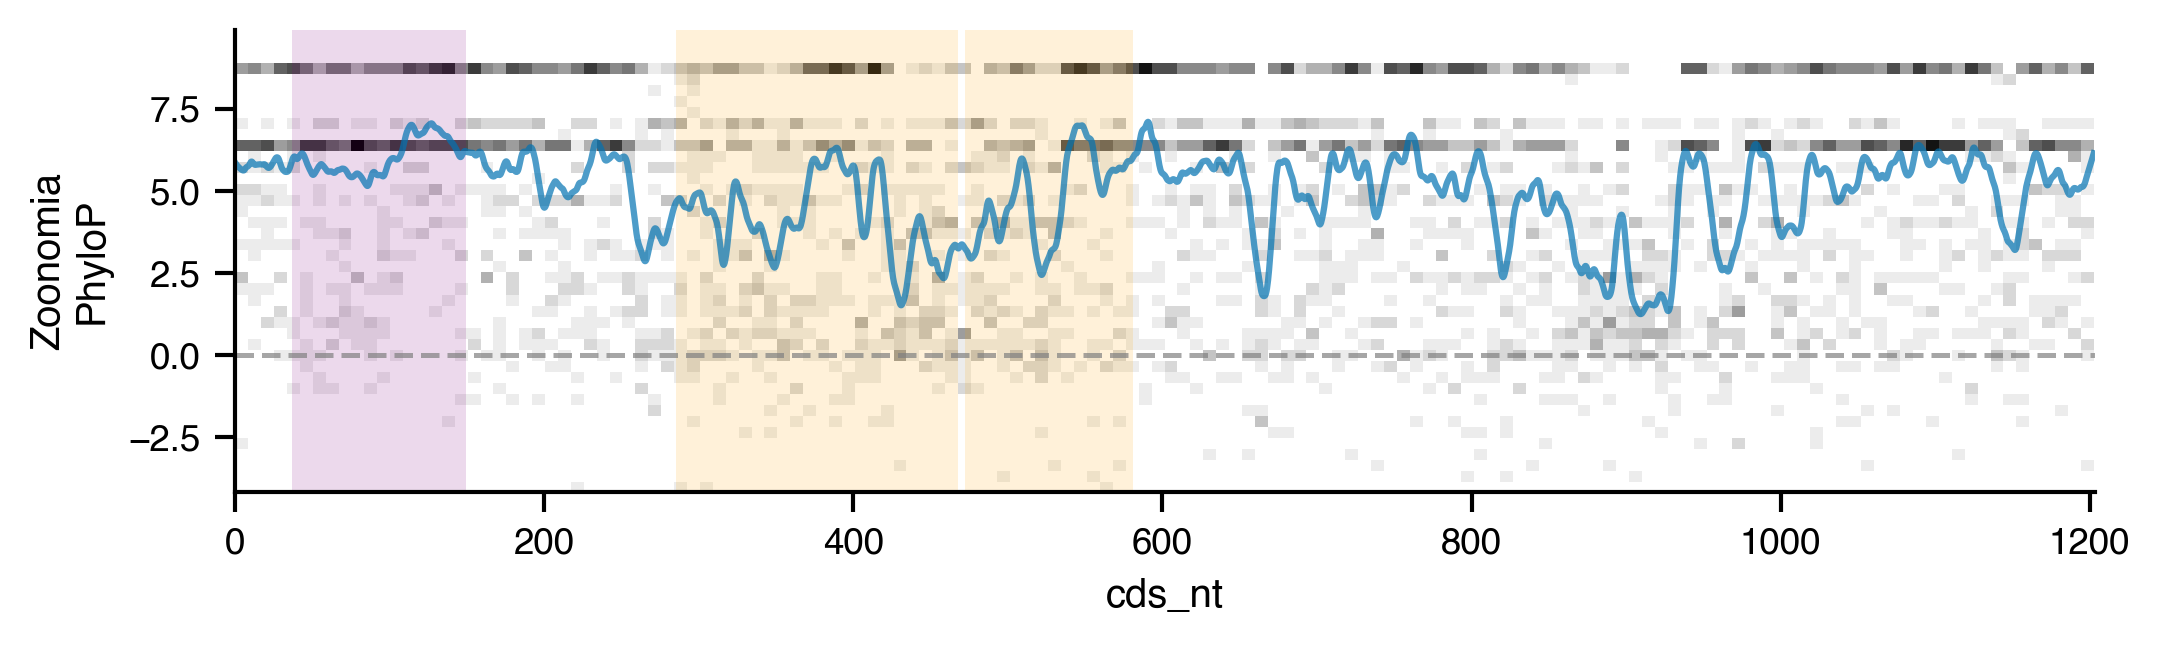

In [28]:
for i in [cc_TFs.index[0]]:
#for i in cc_TFs.dropna().index:
    fig, ax = plt.subplots(figsize=(8, 2))
    plot_cds_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax, x_axis_spacing = 300);

### 4b. Codon alignment conservation

In [29]:
import matplotlib as mpl


In [30]:
def plot_prot_trace(gene, DBD_coords, AD_coords, RD_coords, ax, x_axis_spacing = 600):
    percent_identities = pd.read_csv("../data/zoonomia_toga_mca/prot_alignment_percent_identities_for_vis/" + gene, index_col = 0)
    #display(percent_identities)
    
    # sns.scatterplot(data = percent_identities, x = "pos", y = "percent_identity", ax = ax, edgecolor = "none", s = 1)
    # display(percent_identities)


    smoothed = lowess(percent_identities['percent_identity'], 
                      np.arange(len(percent_identities)), 
                      frac=0.01)  # Adjust frac for smoothness
    smoothed_df = pd.DataFrame(smoothed, columns=["pos", 'smoothed'])

    # sns.scatterplot(data=percent_identities, 
    #                 x=np.arange(len(percent_identities)), 
    #                 y='percent_identity', 
    #                 color='black', 
    #                 alpha = 0.3, 
    #                 s = 10 * (500 / len(smoothed_df)), 
    #                 legend = False,
    #                ax = ax)  

    y_range = 101 - min(min(percent_identities["percent_identity"]),
                    min(smoothed_df['smoothed'])) + 1

    
    h = ax.hist2d(data=percent_identities, 
                    x=np.arange(len(percent_identities)), 
                    y='percent_identity', cmap  = 'binary', bins = [len(percent_identities) // 10, 20], alpha = 1)

    
    sns.lineplot(data=smoothed_df, x="pos", y='smoothed', color=sns.color_palette('colorblind')[0], ax = ax, lw = 1.5, alpha = 0.7)

    sns.despine()
    ax.set_ylabel("Zoonomia\nPercent\nIdentity")
    ax.set_ylim(min(min(percent_identities["percent_identity"]),
                    min(smoothed_df['smoothed'])) - 1, 101)
    ax.set_xlim(0, len(smoothed_df) + 1)

    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, 100, 
                           RD = False, AD_text = False, alpha = 0.15,
                          DBD_y = 0, 
                           AD_y = 0, 
                           RD_y = 0, 
                           ax = ax)

    #fig.colorbar(h[3], ax=ax)
    #plt.title(gene)

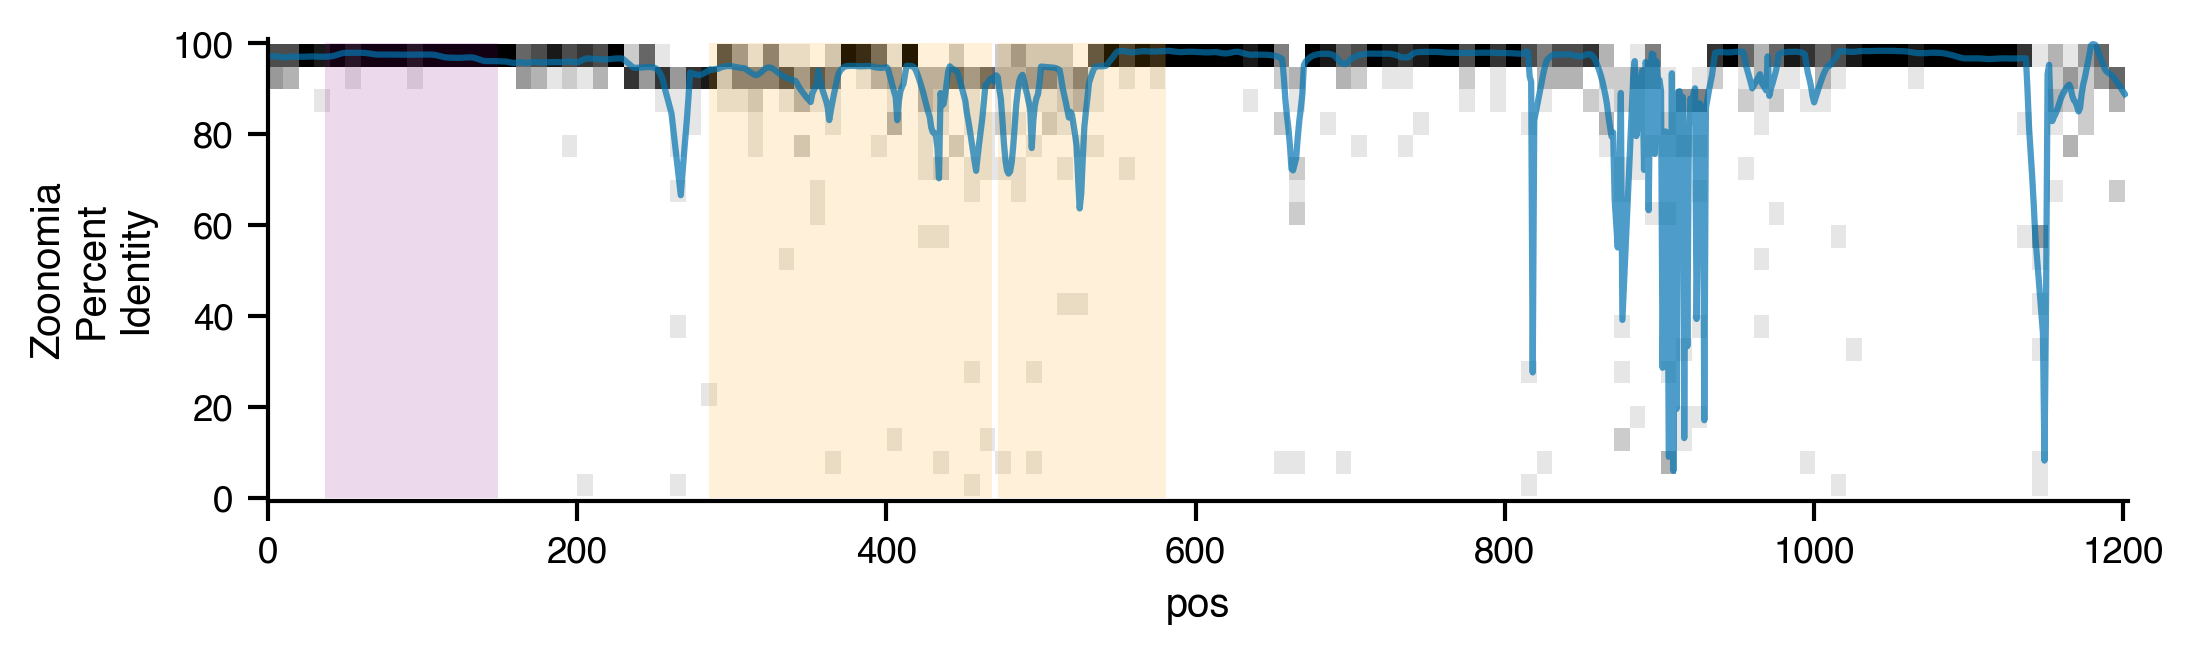

In [31]:
#for i in cc_TFs.index:
for i in [cc_TFs.index[0]]:
    fig, ax = plt.subplots(figsize=(8, 2))
    plot_prot_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax);

In [32]:
pd.read_csv("../soto_analysis/outputs/mutations/cds_gnomad_snv_classified/ENST00000056233.bed", sep = "\t", header = None)

0         1         2       3                4  5   6         7   \
0      7  26152498  26152499  Q9Y4A8  ENST00000056233  +   7  26152498   
1      7  26152500  26152501  Q9Y4A8  ENST00000056233  +   7  26152500   
2      7  26152500  26152501  Q9Y4A8  ENST00000056233  +   7  26152500   
3      7  26152503  26152504  Q9Y4A8  ENST00000056233  +   7  26152503   
4      7  26152505  26152506  Q9Y4A8  ENST00000056233  +   7  26152505   
...   ..       ...       ...     ...              ... ..  ..       ...   
1760   7  26185775  26185776  Q9Y4A8  ENST00000056233  +   7  26185775   
1761   7  26185775  26185776  Q9Y4A8  ENST00000056233  +   7  26185775   
1762   7  26185776  26185777  Q9Y4A8  ENST00000056233  +   7  26185776   
1763   7  26185778  26185779  Q9Y4A8  ENST00000056233  +   7  26185778   
1764   7  26185779  26185780  Q9Y4A8  ENST00000056233  +   7  26185779   

            8  9  10            11 12 13      14  
0     26152499  A  T  1.696534e-06  M  L  No-Syn  
1     26152501  G  A  8.454186e-07  M  I  No-Syn  
2     26152501  G  T  1.099044e-05  M  I  No-Syn  
3     26152504  G  T  8.378788e-07  K  N  No-Syn  
4     26152506  A  G  1.462025e-06  H  R  No-Syn  
...        ... .. ..           ... .. ..     ...  
1760  26185776  G  C  1.457307e-05  R  T  No-Syn  
1761  26185776  G  T  1.402499e-06  R  I  No-Syn  
1762  26185777  A  C  7.012170e-07  R  S  No-Syn  
1763  26185779  A  G  4.028533e-06  K  R  No-Syn  
1764  26185780  G  C  1.688277e-06  K  N  No-Syn  

[1765 rows x 15 columns]

In [33]:
pd.read_csv("../soto_analysis/outputs/mutations/cds_clinvar_for_15_snv_classified/ENST00000241001.bed", sep = "\t", header = None)

0         1         2       3                4  5   6         7   \
0    11  31789934  31789935  P26367  ENST00000241001  -  11  31789934   
1    11  31789934  31789935  P26367  ENST00000241001  -  11  31789934   
2    11  31789935  31789936  P26367  ENST00000241001  -  11  31789935   
3    11  31789935  31789936  P26367  ENST00000241001  -  11  31789935   
4    11  31789936  31789937  P26367  ENST00000241001  -  11  31789936   
..   ..       ...       ...     ...              ... ..  ..       ...   
164  11  31802825  31802826  P26367  ENST00000241001  -  11  31802825   
165  11  31806408  31806409  P26367  ENST00000241001  -  11  31806408   
166  11  31806408  31806409  P26367  ENST00000241001  -  11  31806408   
167  11  31806410  31806411  P26367  ENST00000241001  -  11  31806410   
168  11  31806410  31806411  P26367  ENST00000241001  -  11  31806410   

           8  9  10 11 12 13      14  
0    31789935  T  A  .  *  L  No-Syn  
1    31789935  T  C  .  *  *     Syn  
2    31789936  A  G  .  *  Q  No-Syn  
3    31789936  A  T  .  *  K  No-Syn  
4    31789937  C  A  .  Q  H  No-Syn  
..        ... .. .. .. .. ..     ...  
164  31802826  C  G  .  G  R  No-Syn  
165  31806409  C  A  .  M  I  No-Syn  
166  31806409  C  T  .  M  I  No-Syn  
167  31806411  T  C  .  M  V  No-Syn  
168  31806411  T  G  .  M  L  No-Syn  

[169 rows x 15 columns]

# 5. MTR

In [34]:
domain_mtr = []

ENSTs = glob.glob("../soto_analysis/outputs/mutations/domains_mtr/*")

for ENST in ENSTs:
    try:
        df = pd.read_csv(ENST, sep = "\t", header = None)
        domain_mtr.append(df)
    except pd.errors.EmptyDataError:
        print(ENST, " is empty and has been skipped.")

domain_mtr = pd.concat(domain_mtr)
ad_mtr = domain_mtr[domain_mtr[3] == "AD"]

../soto_analysis/outputs/mutations/domains_mtr/ENST00000468660.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000379044.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000376983.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000315869.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000376670.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000374259.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000528386.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000373294.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000373514.bed  is empty and has been skipped.
../soto_analysis/outputs/mutations/domains_mtr/ENST00000308167.bed  is empty and has been skipped.
../soto_an

In [35]:
cds_mtr = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_mtr/*")

for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
    if ENST in set(ad_mtr[7]):
        try:
            df = pd.read_csv(path, sep = "\t", header = None)
            cds_mtr.append(df)
        except pd.errors.EmptyDataError:
            print(ENST, " is empty and has been skipped.")

cds_mtr = pd.concat(cds_mtr)
cds_mtr = cds_mtr.rename(columns = {3: "ENST", 8: "MTR"})
cds_mtr

0         1         2             ENST  4   5         6         7  \
0      6  53128208  53128209  ENST00000259803 -1   6  53128208  53128209   
1      6  53128209  53128210  ENST00000259803 -1   6  53128209  53128210   
2      6  53128210  53128211  ENST00000259803 -1   6  53128210  53128211   
3      6  53128211  53128212  ENST00000259803 -1   6  53128211  53128212   
4      6  53128212  53128213  ENST00000259803 -1   6  53128212  53128213   
...   ..       ...       ...              ... ..  ..       ...       ...   
1717  19  15379723  15379724  ENST00000269701 -1  19  15379723  15379724   
1718  19  15379724  15379725  ENST00000269701 -1  19  15379724  15379725   
1719  19  15379725  15379726  ENST00000269701 -1  19  15379725  15379726   
1720  19  15379726  15379727  ENST00000269701 -1  19  15379726  15379727   
1721  19  15379727  15379728  ENST00000269701 -1  19  15379727  15379728   

           MTR  
0     0.987538  
1     0.987538  
2     0.987538  
3     1.000560  
4     1.000560  
...        ...  
1717  0.946138  
1718  0.946138  
1719  0.963221  
1720  0.963221  
1721  0.963221  

[579831 rows x 9 columns]

In [36]:
test_cds_mtr = cds_mtr[cds_mtr["ENST"] == "ENST00000259803"]
test_cds_mtr[test_cds_mtr["MTR"] > 0.841]

0         1         2             ENST  4  5         6         7  \
0     6  53128208  53128209  ENST00000259803 -1  6  53128208  53128209   
1     6  53128209  53128210  ENST00000259803 -1  6  53128209  53128210   
2     6  53128210  53128211  ENST00000259803 -1  6  53128210  53128211   
3     6  53128211  53128212  ENST00000259803 -1  6  53128211  53128212   
4     6  53128212  53128213  ENST00000259803 -1  6  53128212  53128213   
...  ..       ...       ...              ... .. ..       ...       ...   
1102  6  53145624  53145625  ENST00000259803 -1  6  53145624  53145625   
1103  6  53145625  53145626  ENST00000259803 -1  6  53145625  53145626   
1104  6  53145626  53145627  ENST00000259803 -1  6  53145626  53145627   
1105  6  53145627  53145628  ENST00000259803 -1  6  53145627  53145628   
1106  6  53145628  53145629  ENST00000259803 -1  6  53145628  53145629   

           MTR  
0     0.987538  
1     0.987538  
2     0.987538  
3     1.000560  
4     1.000560  
...        ...  
1102  1.064680  
1103  1.064680  
1104  1.051194  
1105  1.051194  
1106  1.051194  

[743 rows x 9 columns]

In [37]:
def plot_mtr_trace(gene, DBD_coords, AD_coords, RD_coords, ax, x_axis_spacing = 600):
    ENST = cc_names[cc_names["Gene"] == gene]["ENST"].iloc[0]


    ENST_mtr = cds_mtr[cds_mtr["ENST"] == ENST]
    
    if ENST_mtr[4].iloc[0] == -1:
        ascending = False
    else: 
        ascending = True
        
    ENST_mtr = ENST_mtr.sort_values(by = 1, ascending = ascending)

    cds_bed = pd.read_csv("../soto_analysis/outputs/mutations/cds_bed_format/" + ENST, sep = "\t", header = None)
    cds_bed["pos"] = [np.arange(s + 1, e + 1) for s, e in zip(cds_bed[1], cds_bed[2])]

    full_cds_positions = cds_bed[["pos"]].explode("pos").reset_index(drop = True)
    full_cds_positions = full_cds_positions.sort_values(by = "pos", ascending = ascending)
    #display(full_cds_positions)

    merged = pd.merge(full_cds_positions, ENST_mtr, how = "left", left_on = "pos", right_on = 2)
    merged = merged.drop_duplicates(subset = "pos")
    merged["cds_nt"] = np.arange(len(merged)) / 3
    #display(merged)

    # ax.axhline(0.841, color = "gray", linestyle = "--", alpha = 0.7)
    

    # sns.lineplot(data=merged, x="cds_nt", y='MTR', legend = False, ax = ax, lw = 1, color = sns.color_palette('colorblind')[9])
        
    # sns.despine(ax = ax)
    ax.set_ylabel("Missense\nTolerance\nRatio", rotation = 0, ha = "right", va = "center", labelpad = 10)

    
    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, max(merged["MTR"].dropna()), 
                           RD = False, AD_text = False, alpha = 0.15,
                          DBD_y = 0, 
                           AD_y = 0, 
                           RD_y = 0, 
                           ax = ax)
    

    ax.axhline(0.841, color = "gray", linestyle = "--", alpha = 0.7)
    threshold_plot(data=merged, x="cds_nt", y='MTR', legend = False, ax = ax, lw = 1, 
                   color_below = "silver",
                   color_above = sns.color_palette('colorblind')[9], 
                   threshold = 0.841)


    min_y = min(merged["MTR"].dropna()) - 0.05
    max_y = max(merged["MTR"].dropna()) + 0.05
    ax.set_ylim(min_y, max_y)
    ax.set_xlim(0, max(merged["cds_nt"]))

    center_pos = (0.841 - min_y) / (max_y - min_y)
    add_custom_legend_arrows(top_color = sns.color_palette('colorblind')[-1],
                         top_label = "Non-constrained",
                         bottom_color = sns.color_palette('colorblind')[-3],
                         bottom_label = "Constrained", ax = ax, 
                 center = center_pos, length = 0.45 / 1.5, padding = 0.005)

    sns.despine(ax = ax)

In [38]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

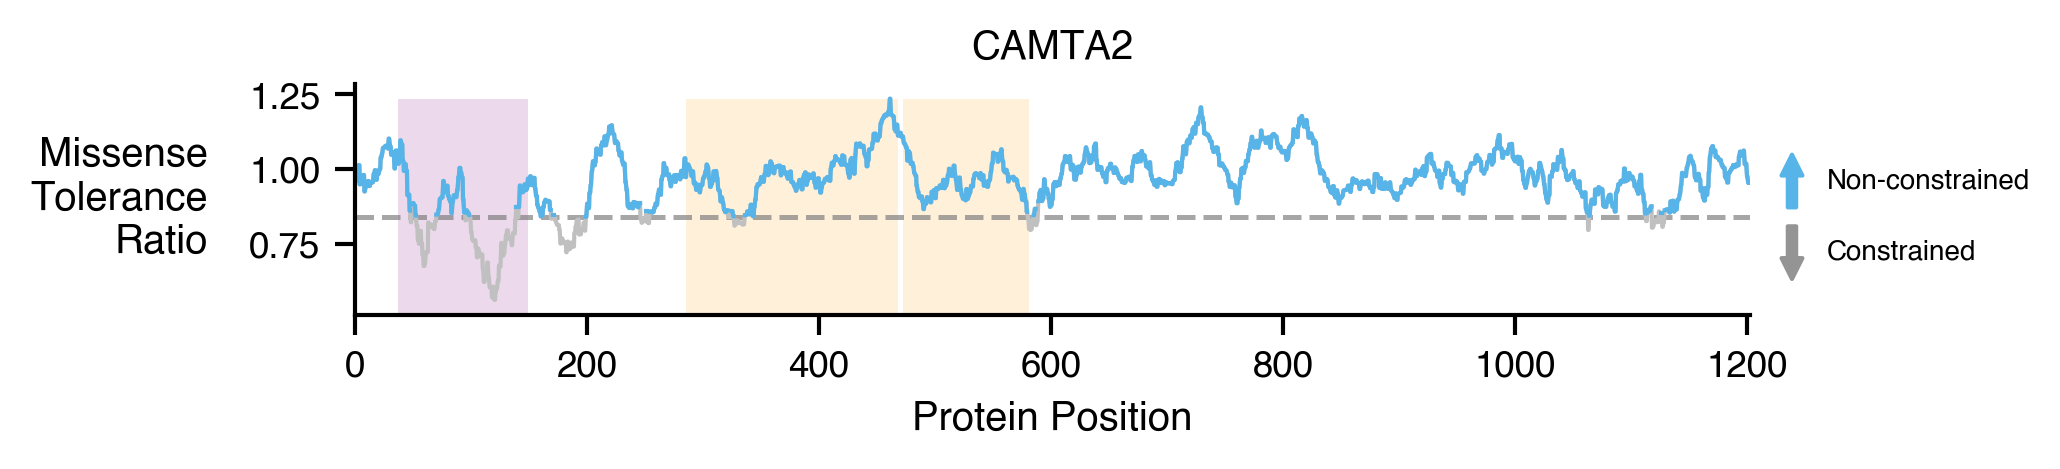

In [39]:
for i in [cc_TFs.index[0]]:
#for i in cc_TFs.dropna().index:
    fig, ax = plt.subplots(figsize=(6, 1))
    plot_mtr_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax, x_axis_spacing = 300);
    plt.title(cc_TFs["Gene"].iloc[i])
    plt.xlabel("Protein Position")

    # add_custom_legend({"Non-MTR\n-constrained" : sns.color_palette('colorblind')[-1],
    #                    "MTR\n-constrained" : sns.color_palette('colorblind')[-3]}, ax = ax)

# 6. AlphaFold Domains

In [40]:
def plot_af_domains(gene, DBD_coords, AD_coords, RD_coords, ax, x_axis_spacing = 600):
    p = PDBParser()
    structure = p.get_structure(gene, "../data/TF_vis_AF/" + gene + ".pdb")
    model = structure[0]
    dssp = DSSP(model, "../data/TF_vis_AF/" + gene + ".pdb")

    pos = []
    code = []
    
    for i in range(len(list(dssp.keys()))):
        pos.append(i)
        a_key = list(dssp.keys())[i]
        code.append(dssp[a_key][2])

    codes = pd.DataFrame({"pos" : pos, "code" : code})
    

    color_palette = {# Helices
                    "G" : sns.color_palette('colorblind')[0],
                    "H" : sns.color_palette('colorblind')[0],
                    "I" : sns.color_palette('colorblind')[0],
    
                    # Sheets
                    "E" : sns.color_palette('colorblind')[1],
                    "B" : sns.color_palette('colorblind')[1],
    
                    # Poly proline helix
                    "P" : sns.color_palette('colorblind')[2],
    
                    # Other
                    "T" : "none",
                    "S" : "none",
                    "-" : "none"}

    #print(DBD_coords)
    
    plot_domain_rectangles(DBD_coords, AD_coords, RD_coords, 1, 
                           RD = False, AD_text = False, alpha = 0.15,
                          DBD_y = 0, 
                           AD_y = 0, 
                           RD_y = 0, 
                           ax = ax)
    
    
    for code in set(codes["code"]):
        intervals =  return_intervals(codes[codes["code"] == code]["pos"])
        for s, e in intervals:
            #print(i)
            color = color_palette[code]
            plot_rectangle(s, e, color, 1, ax, alpha = 1)
            ax.set_xlim(1, len(pos))       
    i+=1

        

    sns.despine(left = True, ax = ax)
    ax.set_yticks([])
    ax.set_yticklabels([])

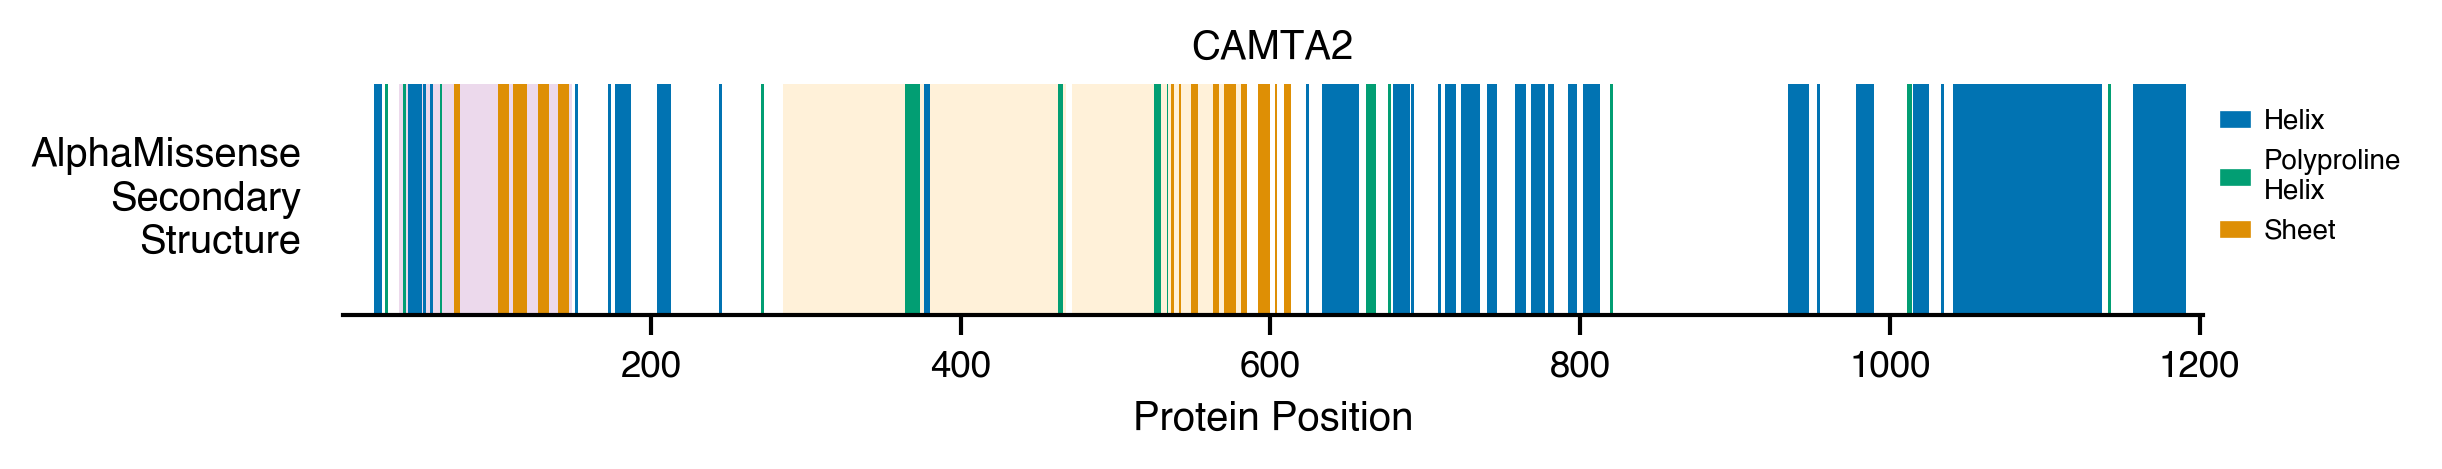

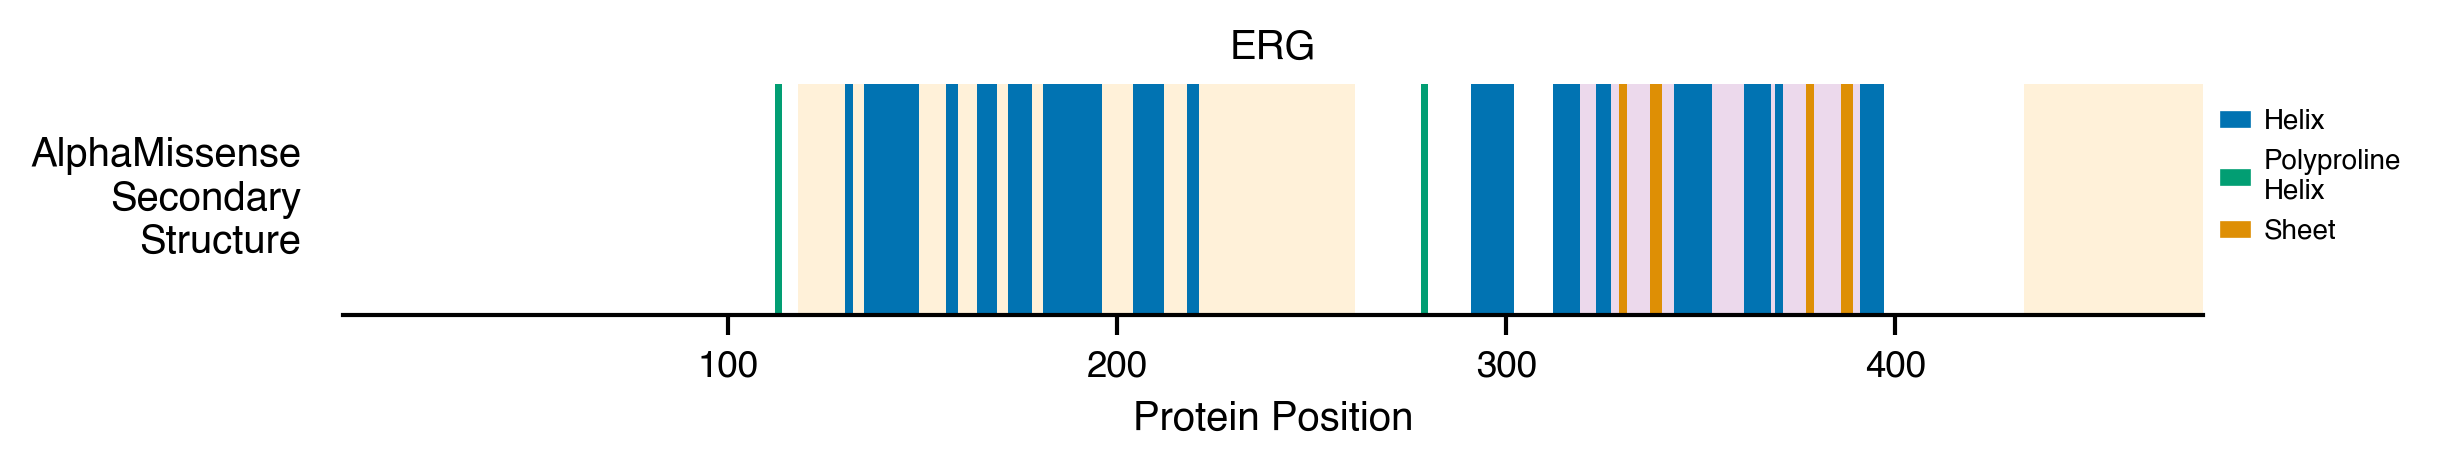

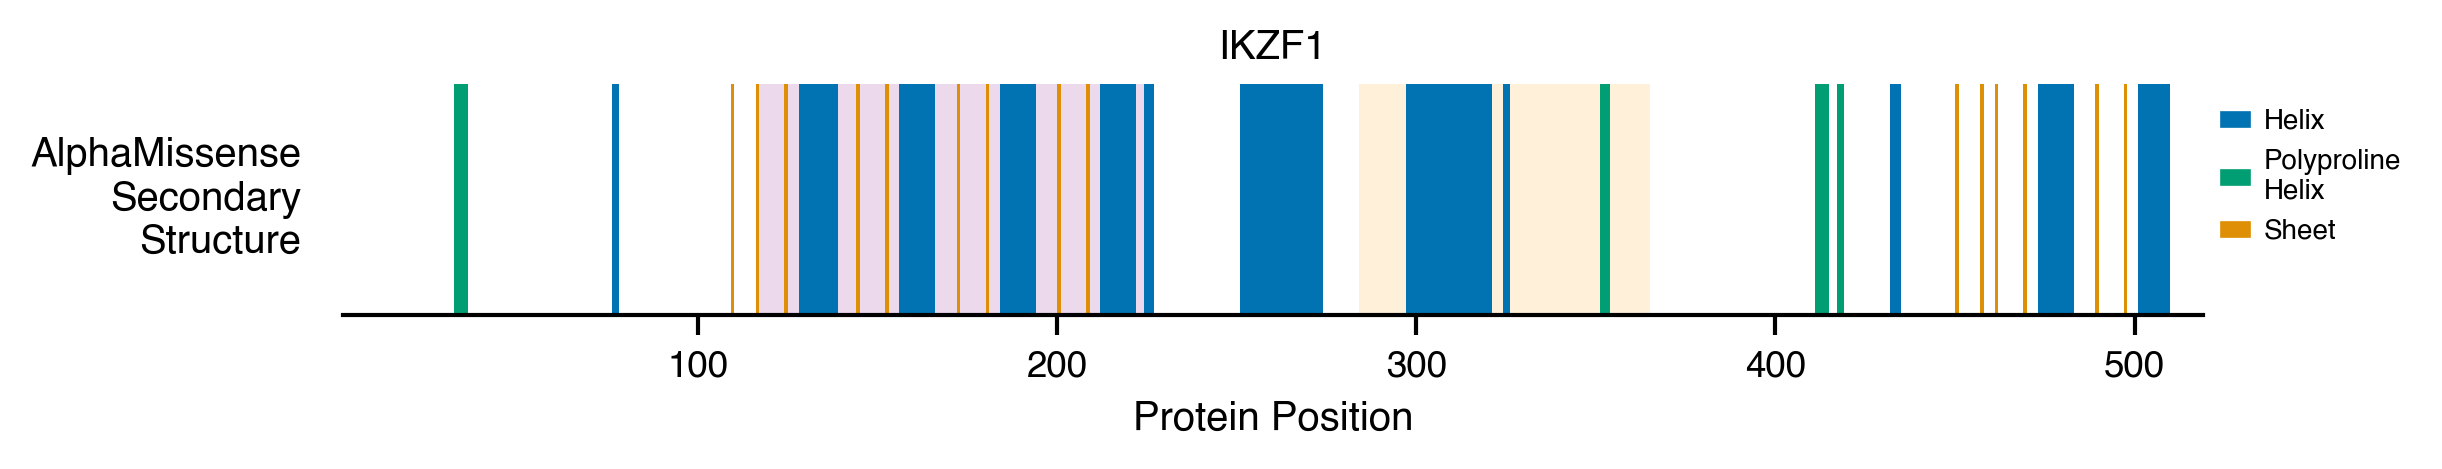

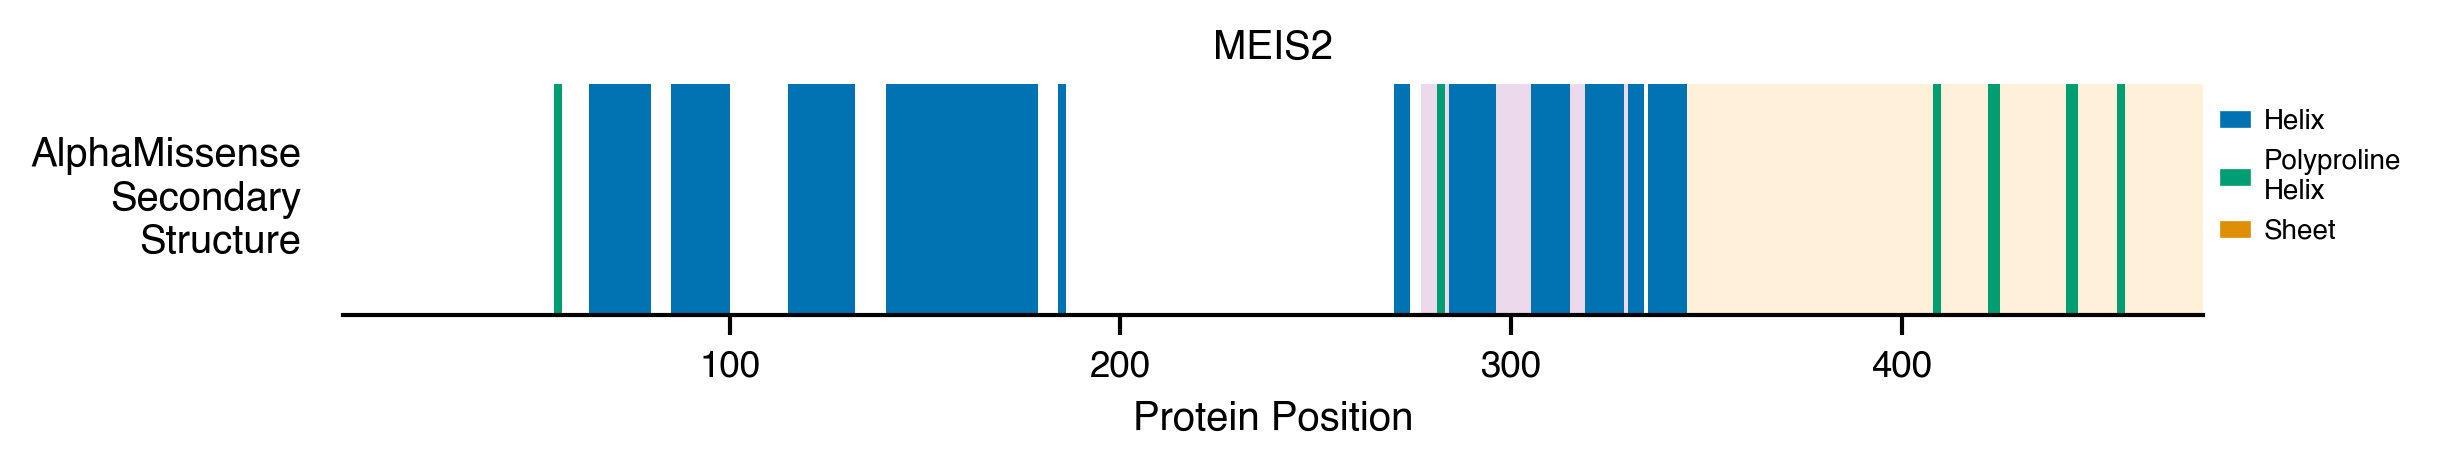

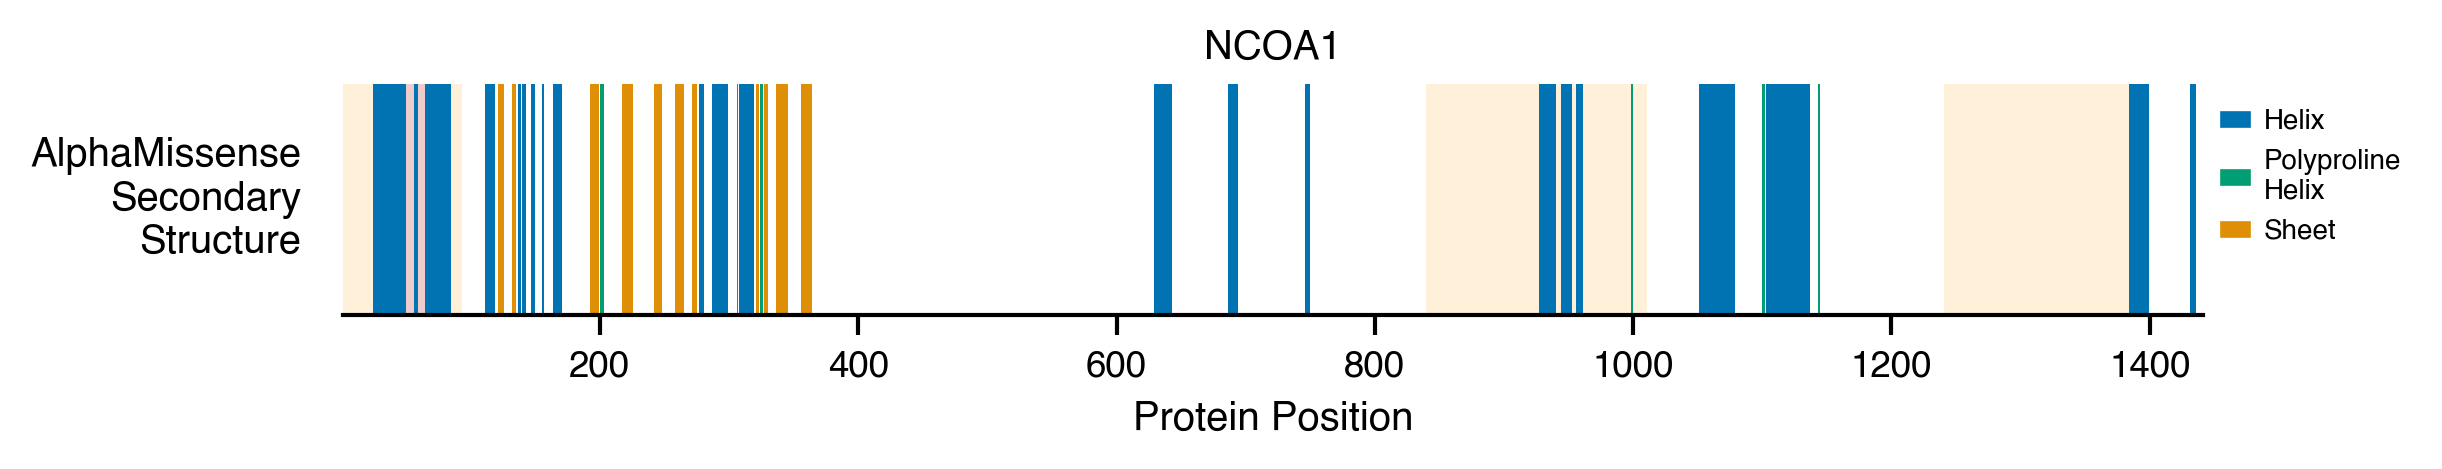

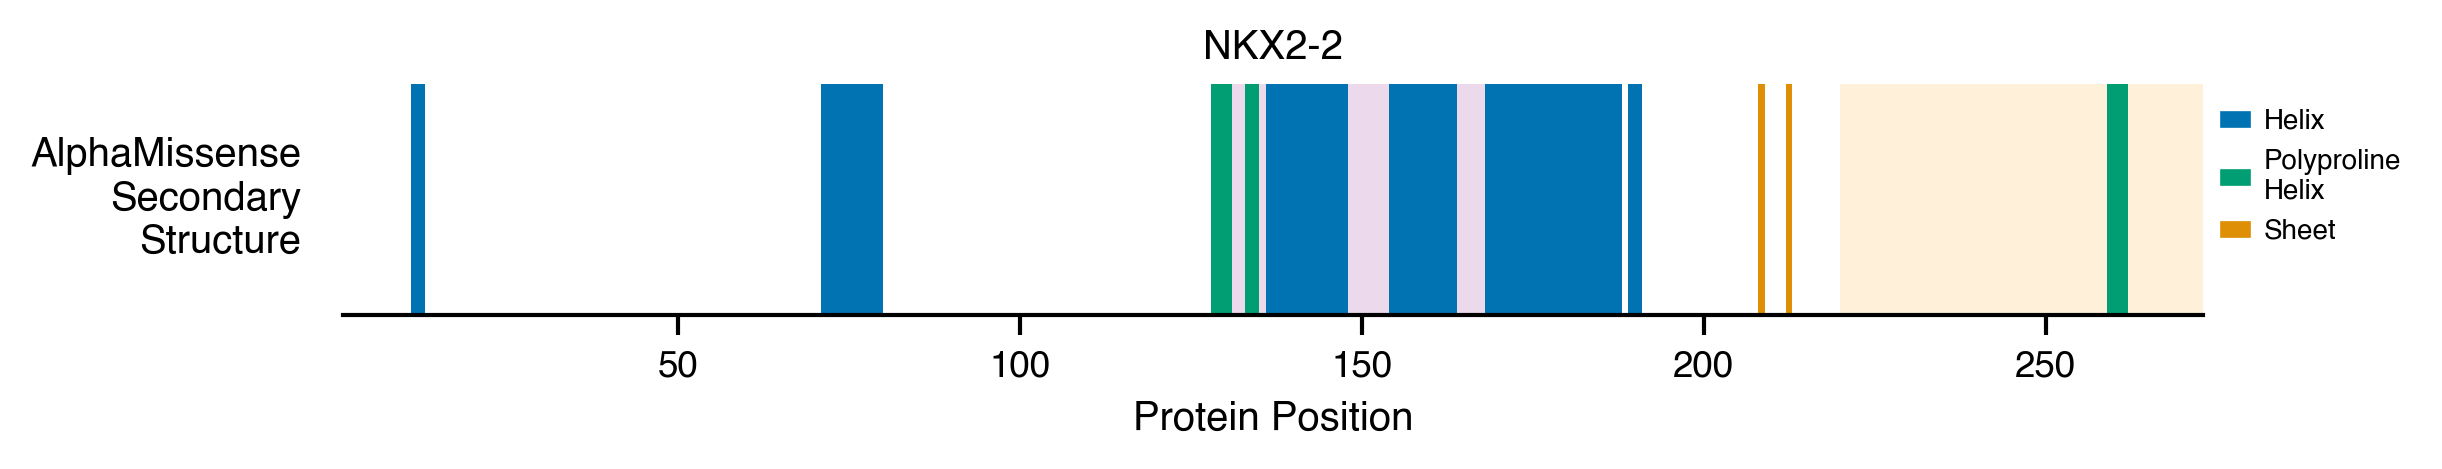

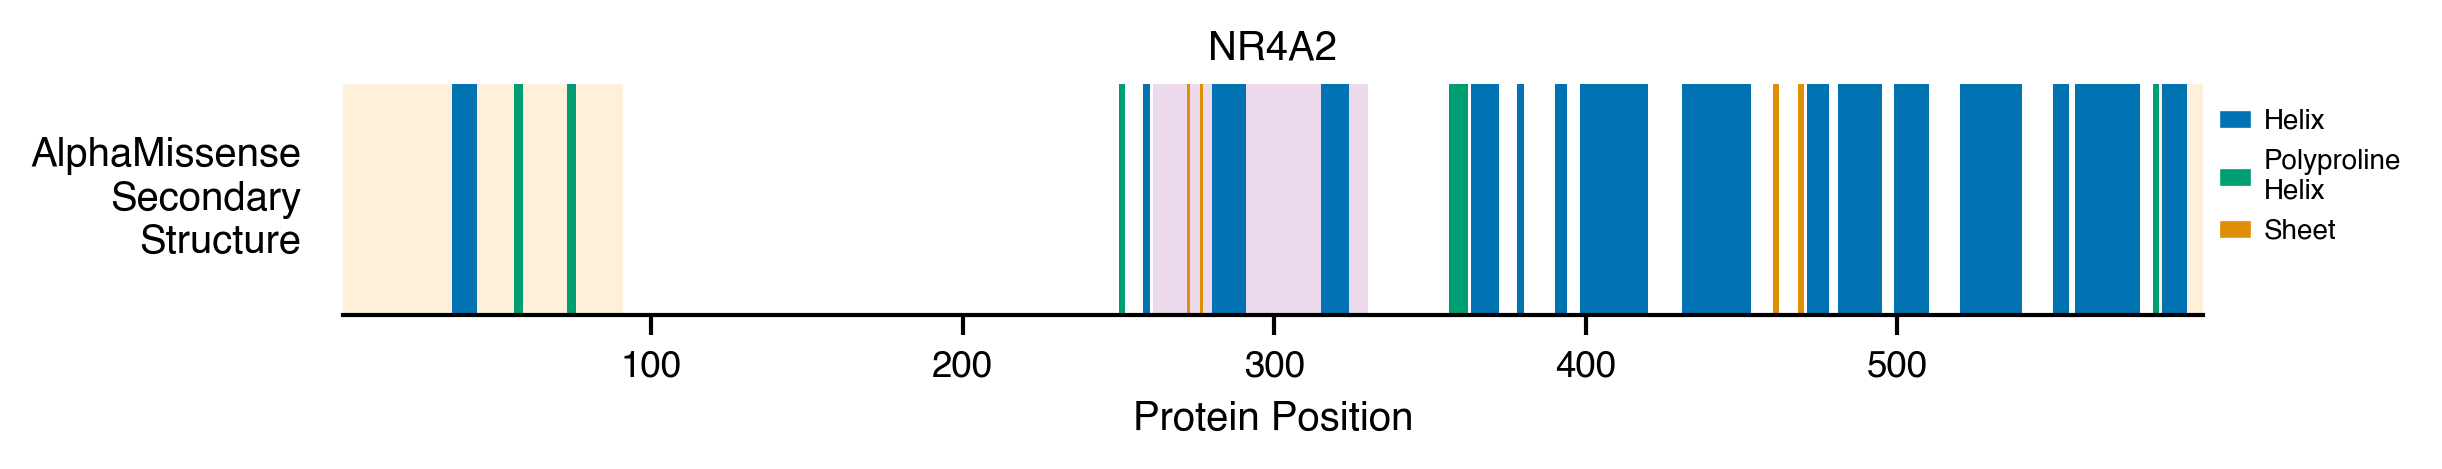

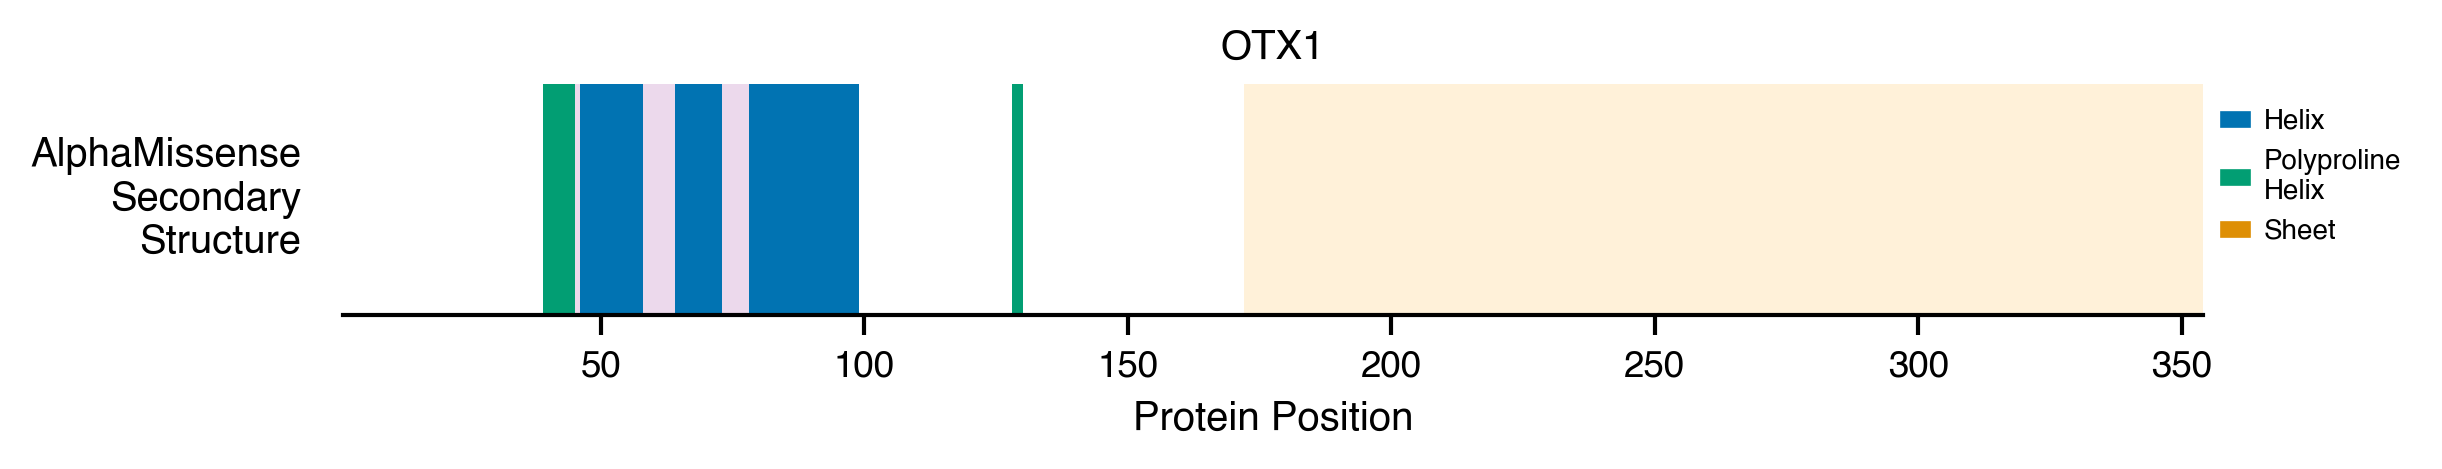

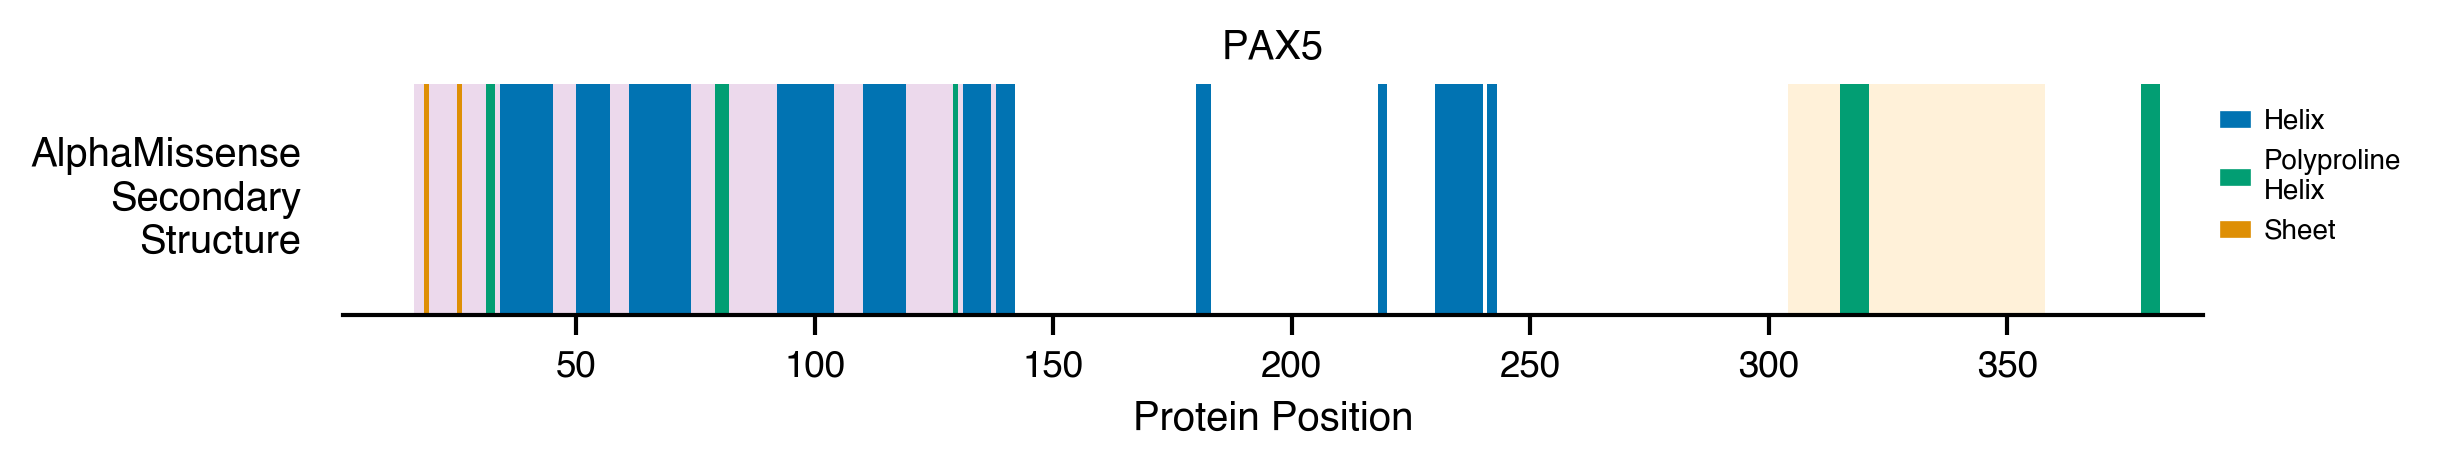

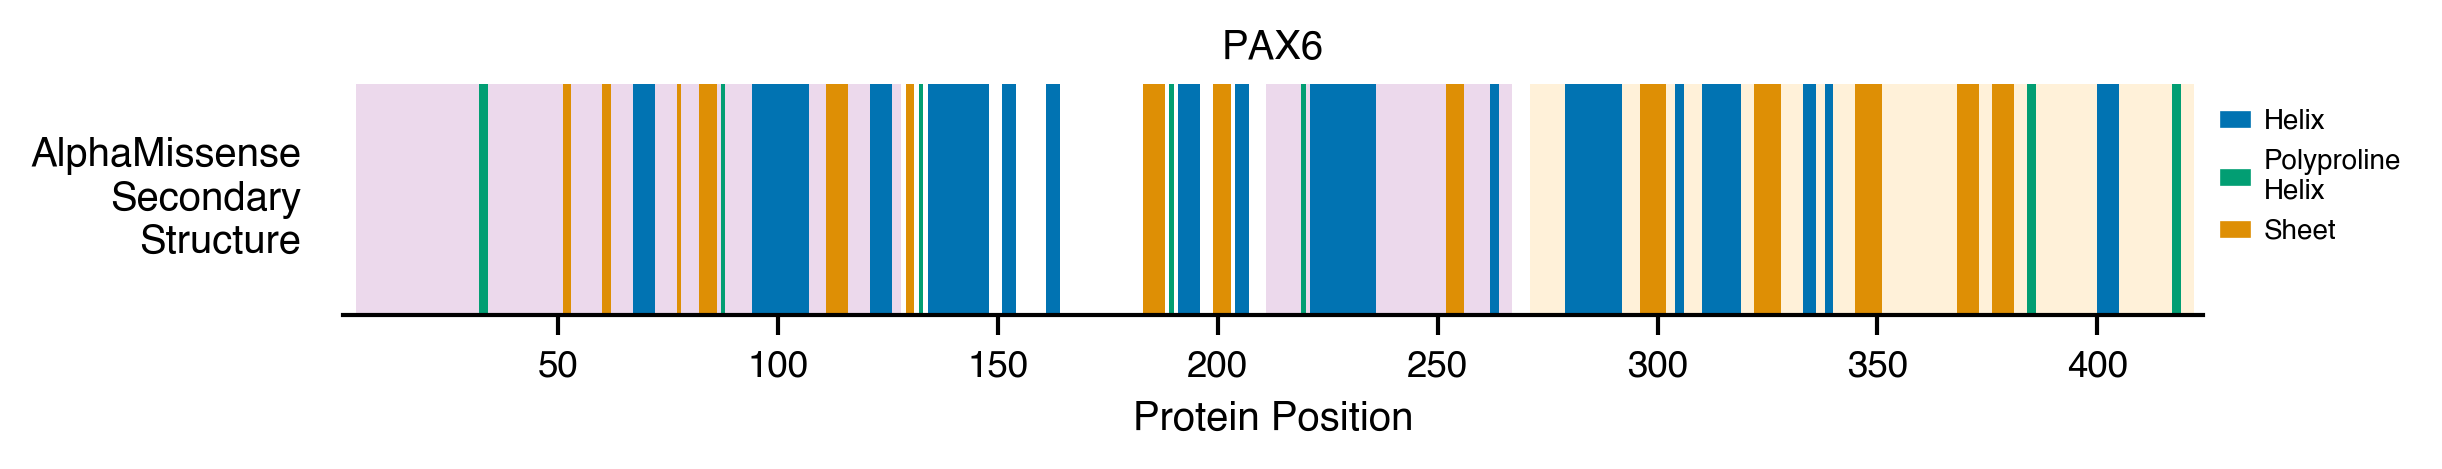

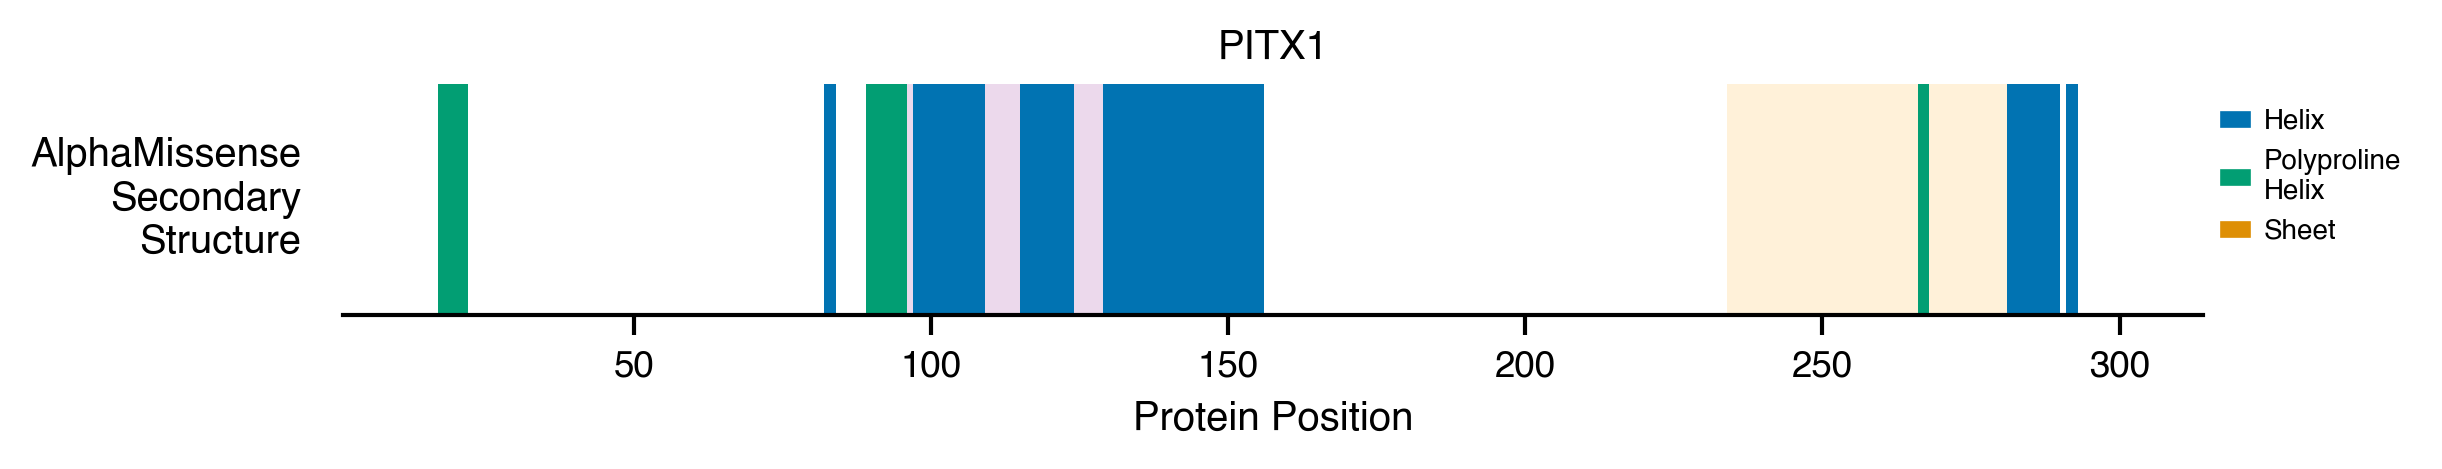

In [41]:
#for i in [cc_TFs.index[0]]:
for i in cc_TFs.index:
    fig, ax = plt.subplots(figsize=(8, 1))
    plot_af_domains(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax, x_axis_spacing = 300)
    plt.ylabel("AlphaMissense\nSecondary\nStructure", rotation = 0, labelpad = 10, ha = "right", va = "center")
    plt.title(cc_TFs["Gene"].iloc[i])
    plt.xlabel("Protein Position")

    add_custom_legend({"Helix" : sns.color_palette('colorblind')[0],
                       "Polyproline\nHelix": sns.color_palette('colorblind')[2],
                       "Sheet" : sns.color_palette('colorblind')[1]}, ax = ax, bbox_to_anchor = (1, 1))
    
    plt.show();

# 7. Putting it all together

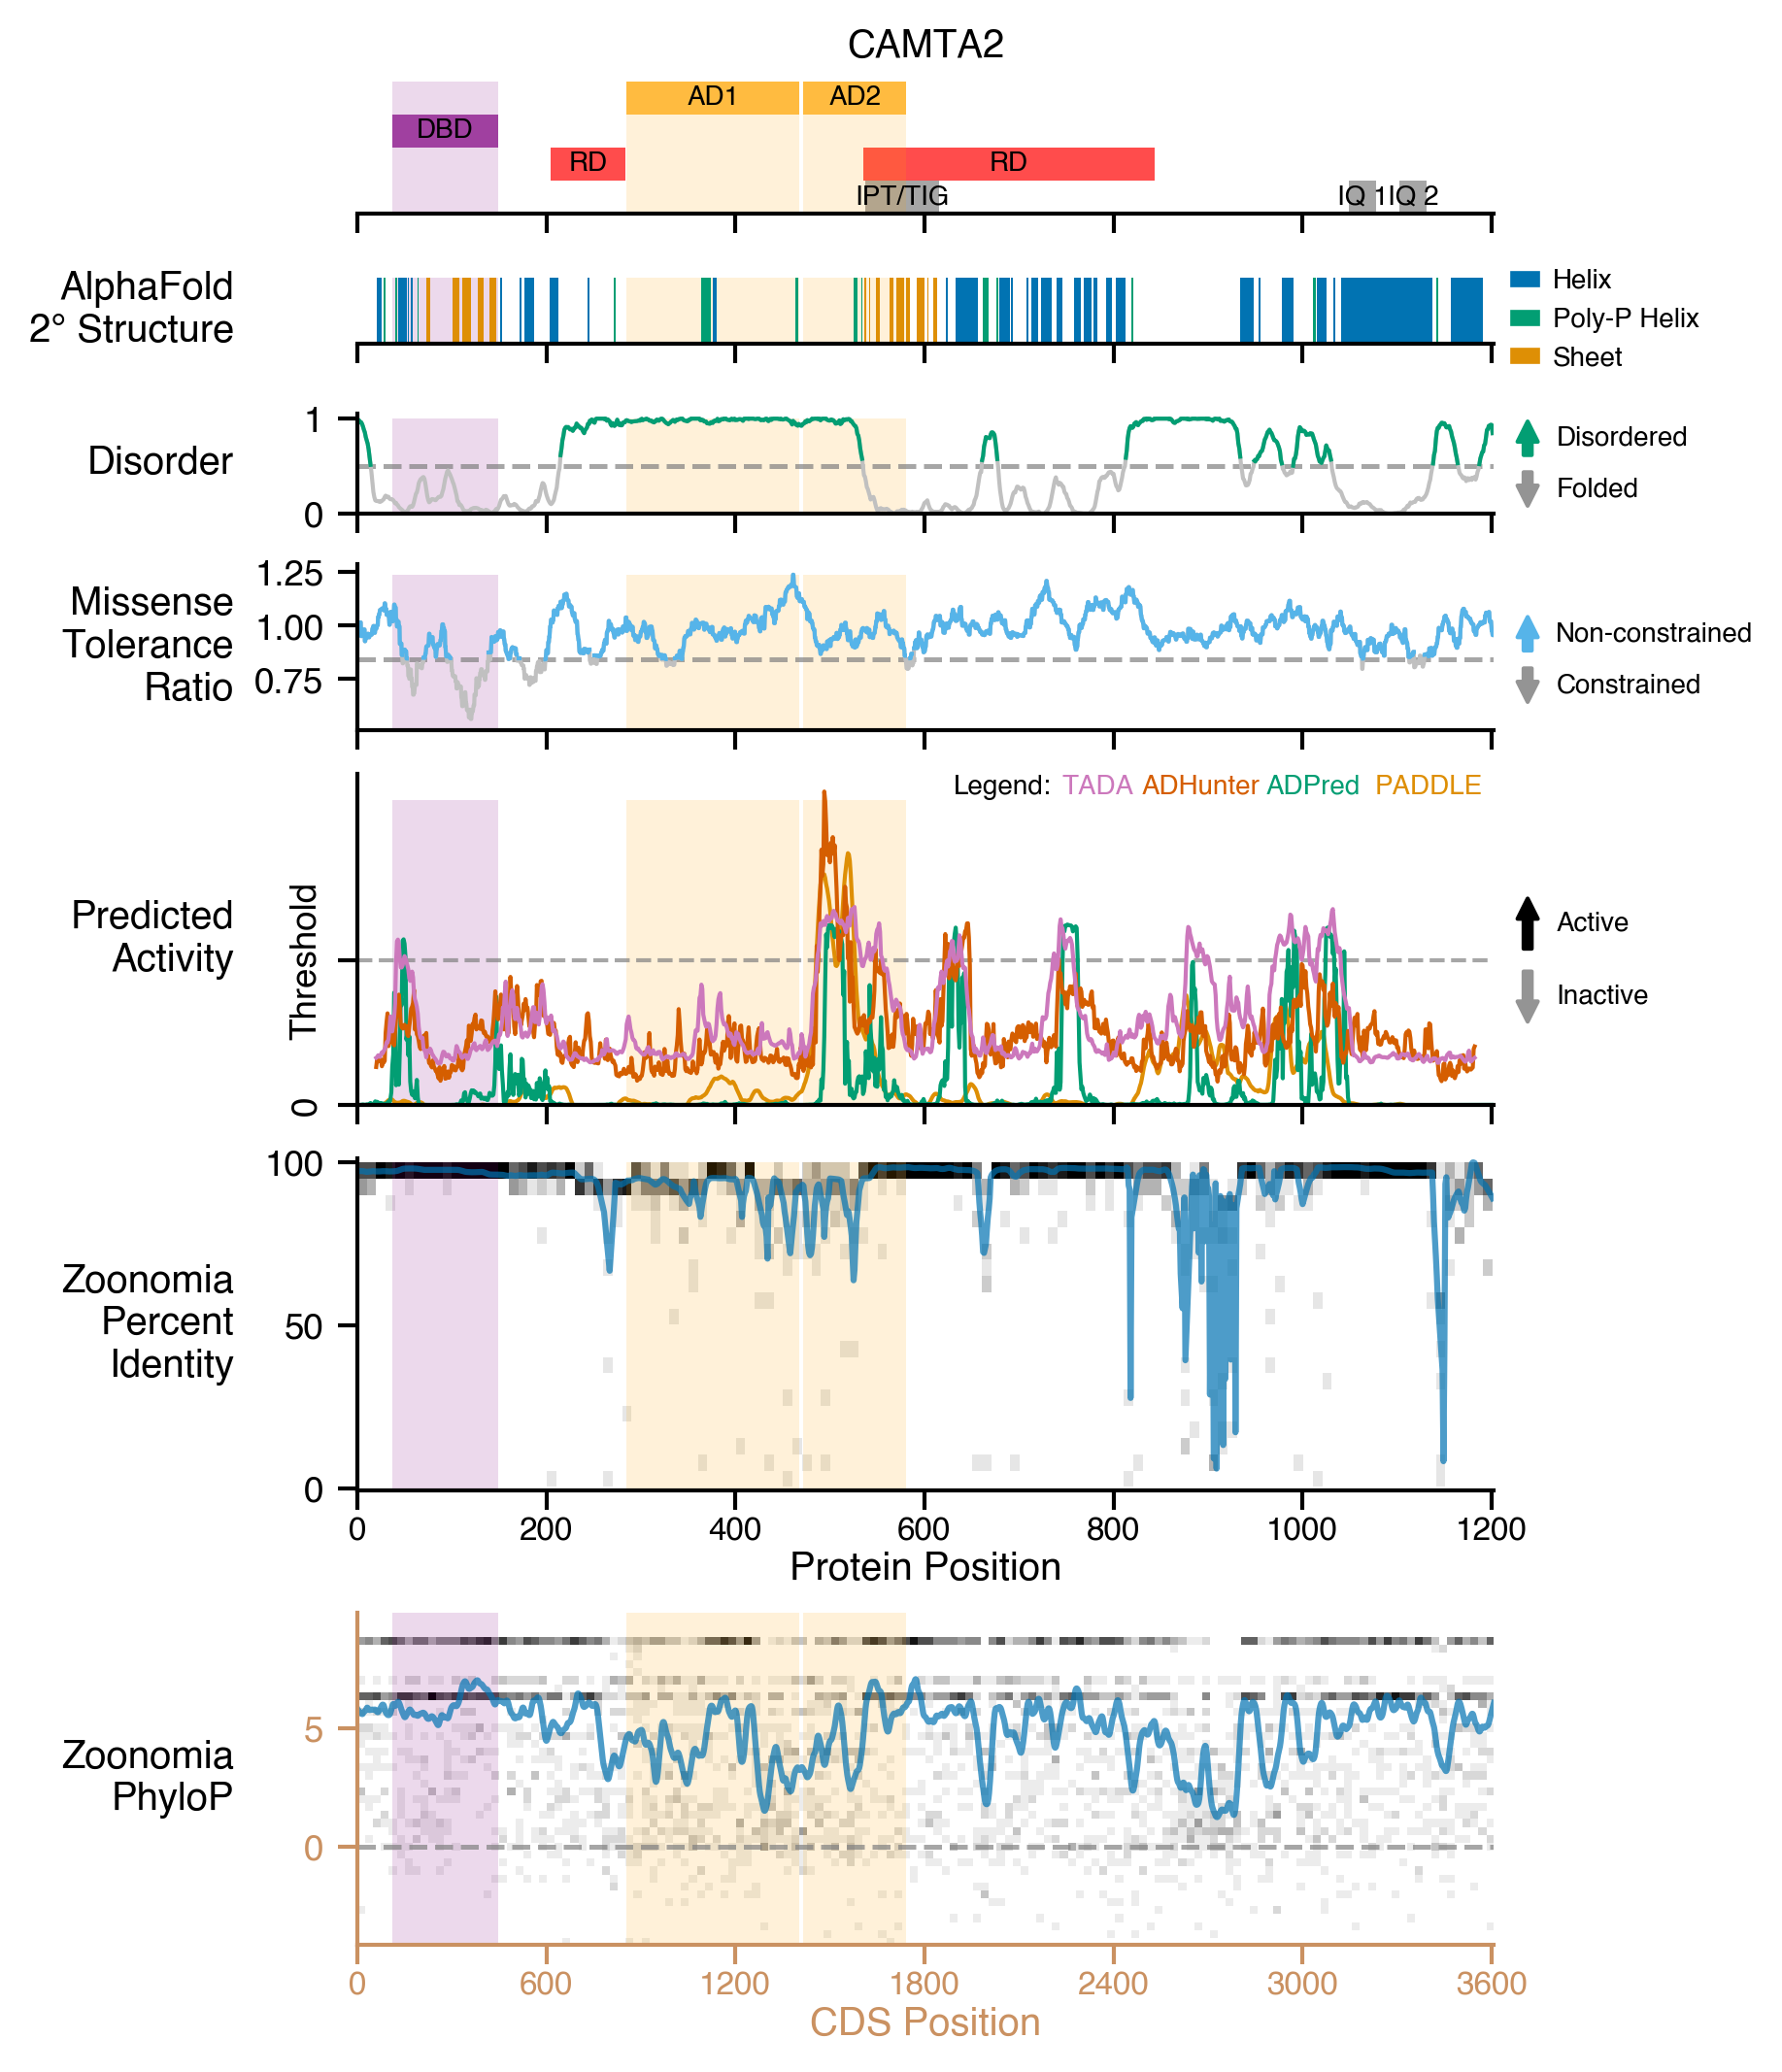

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


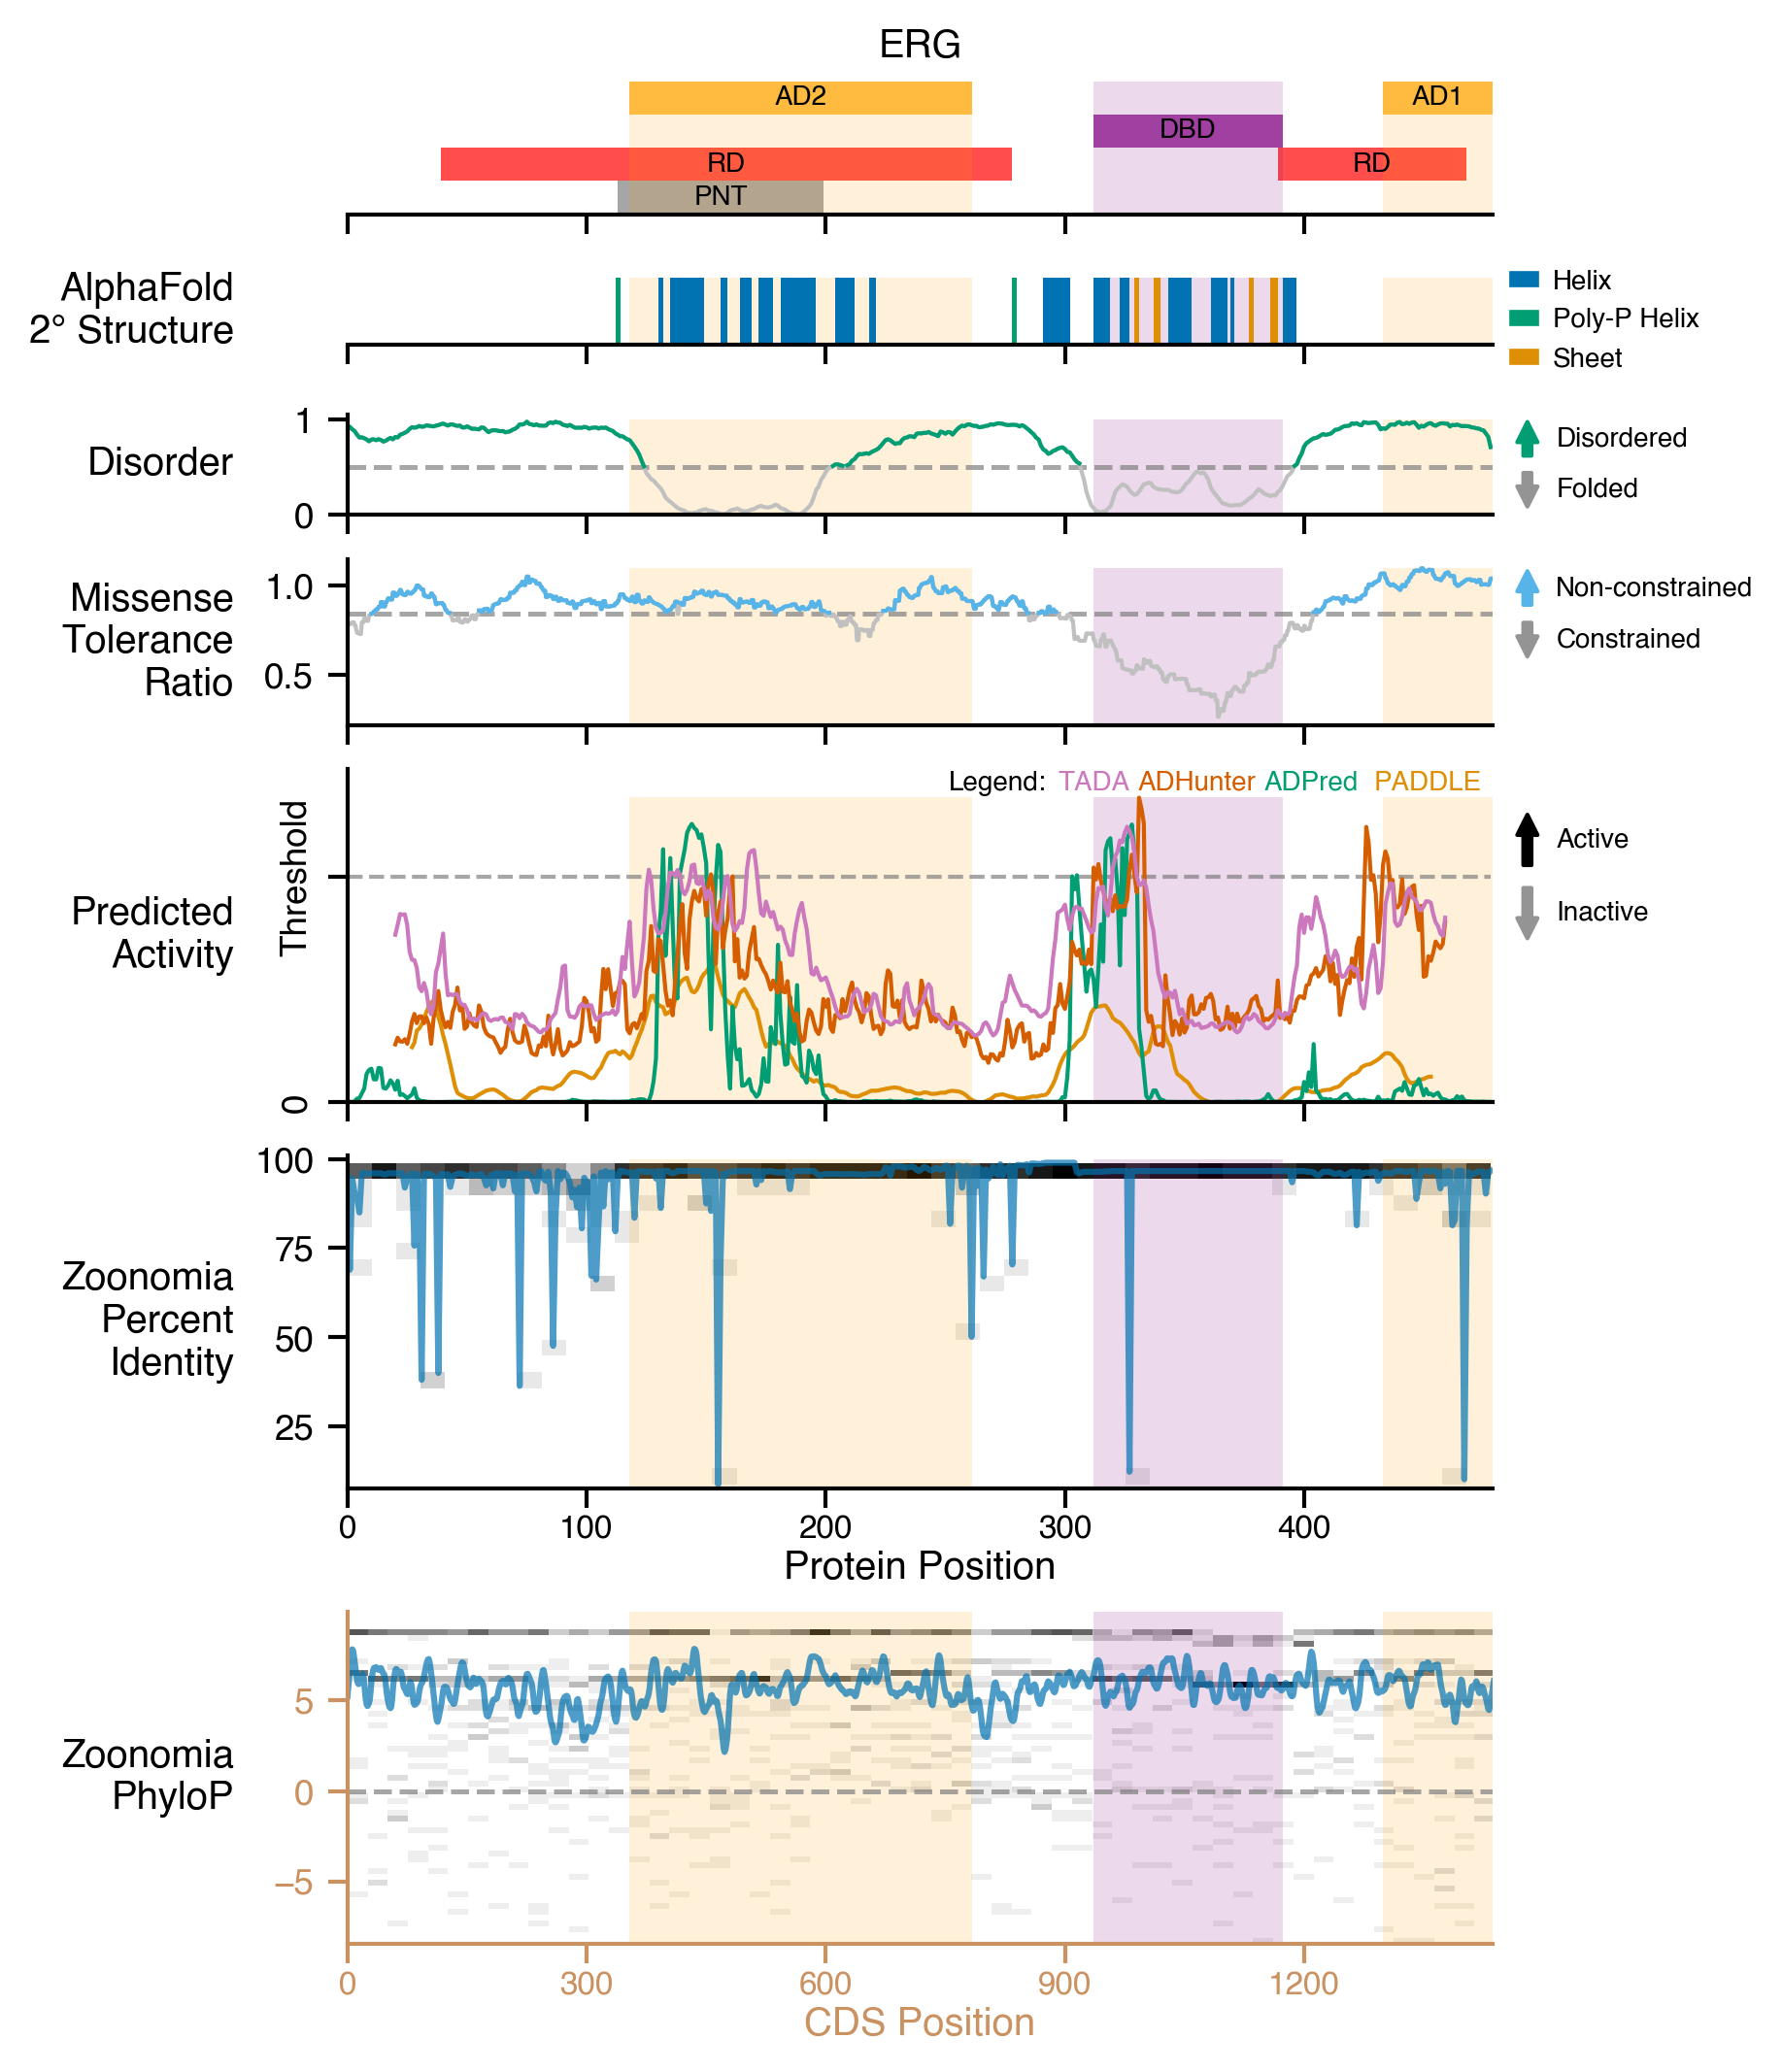

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


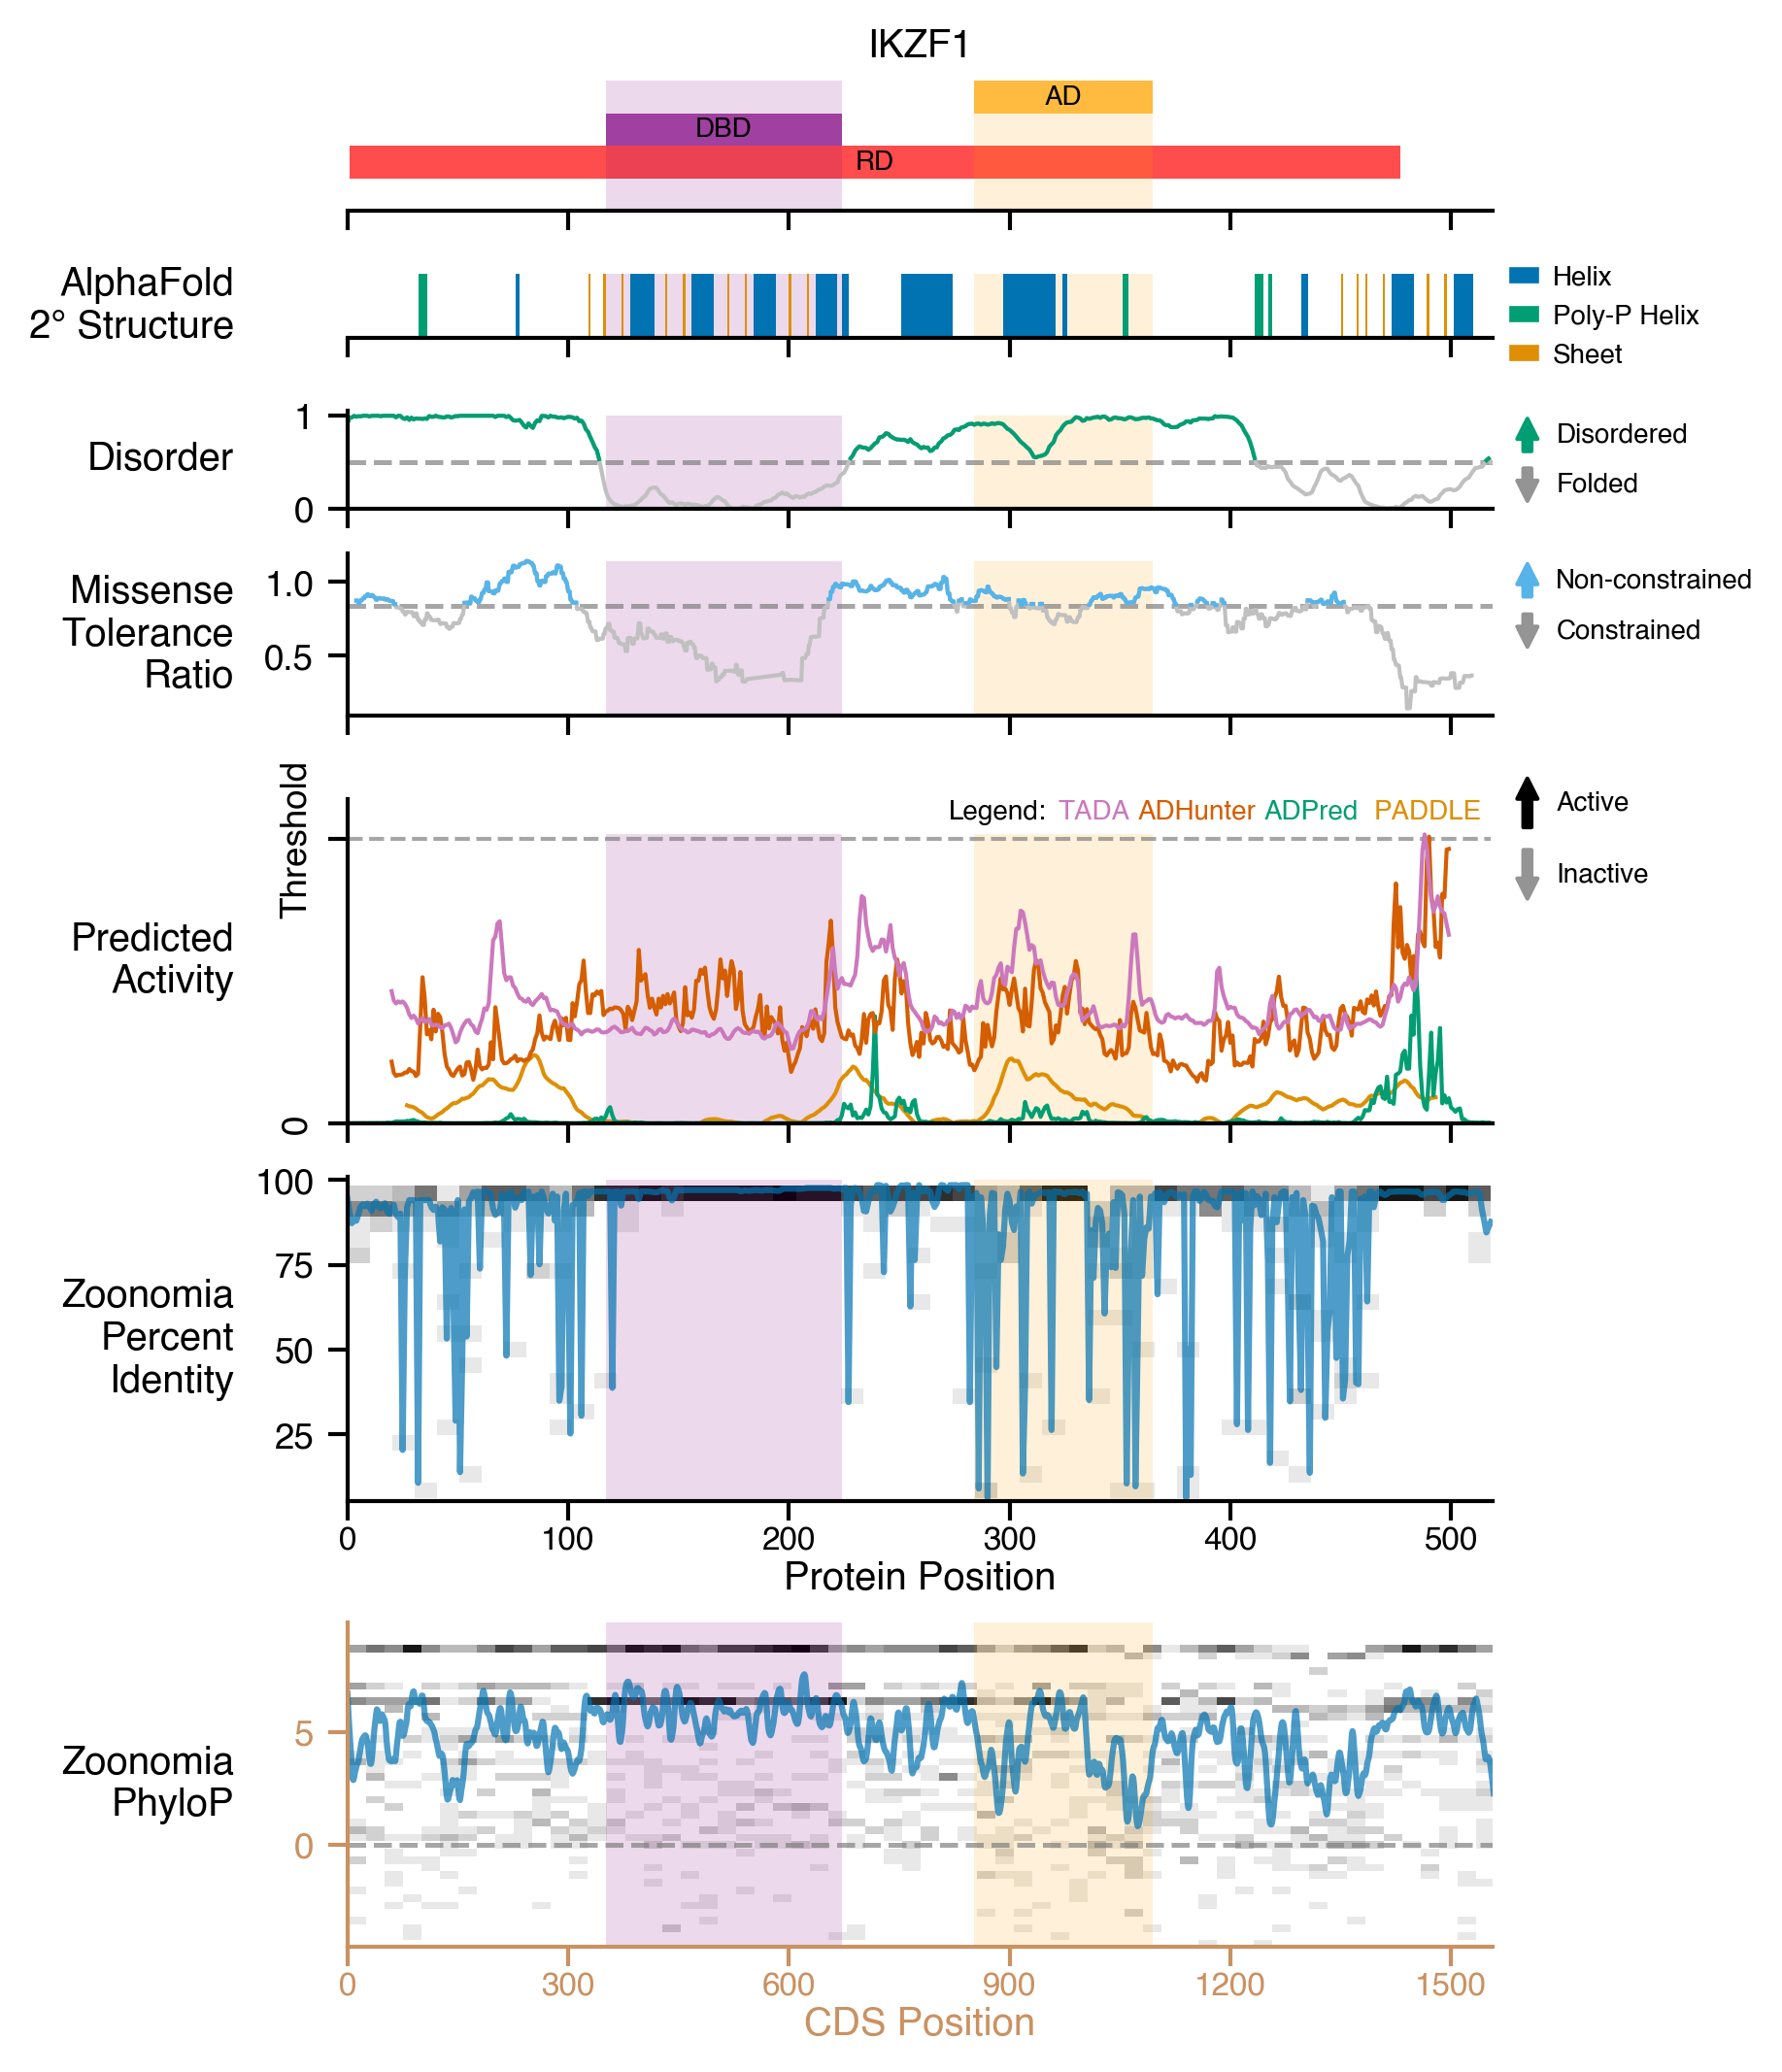

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


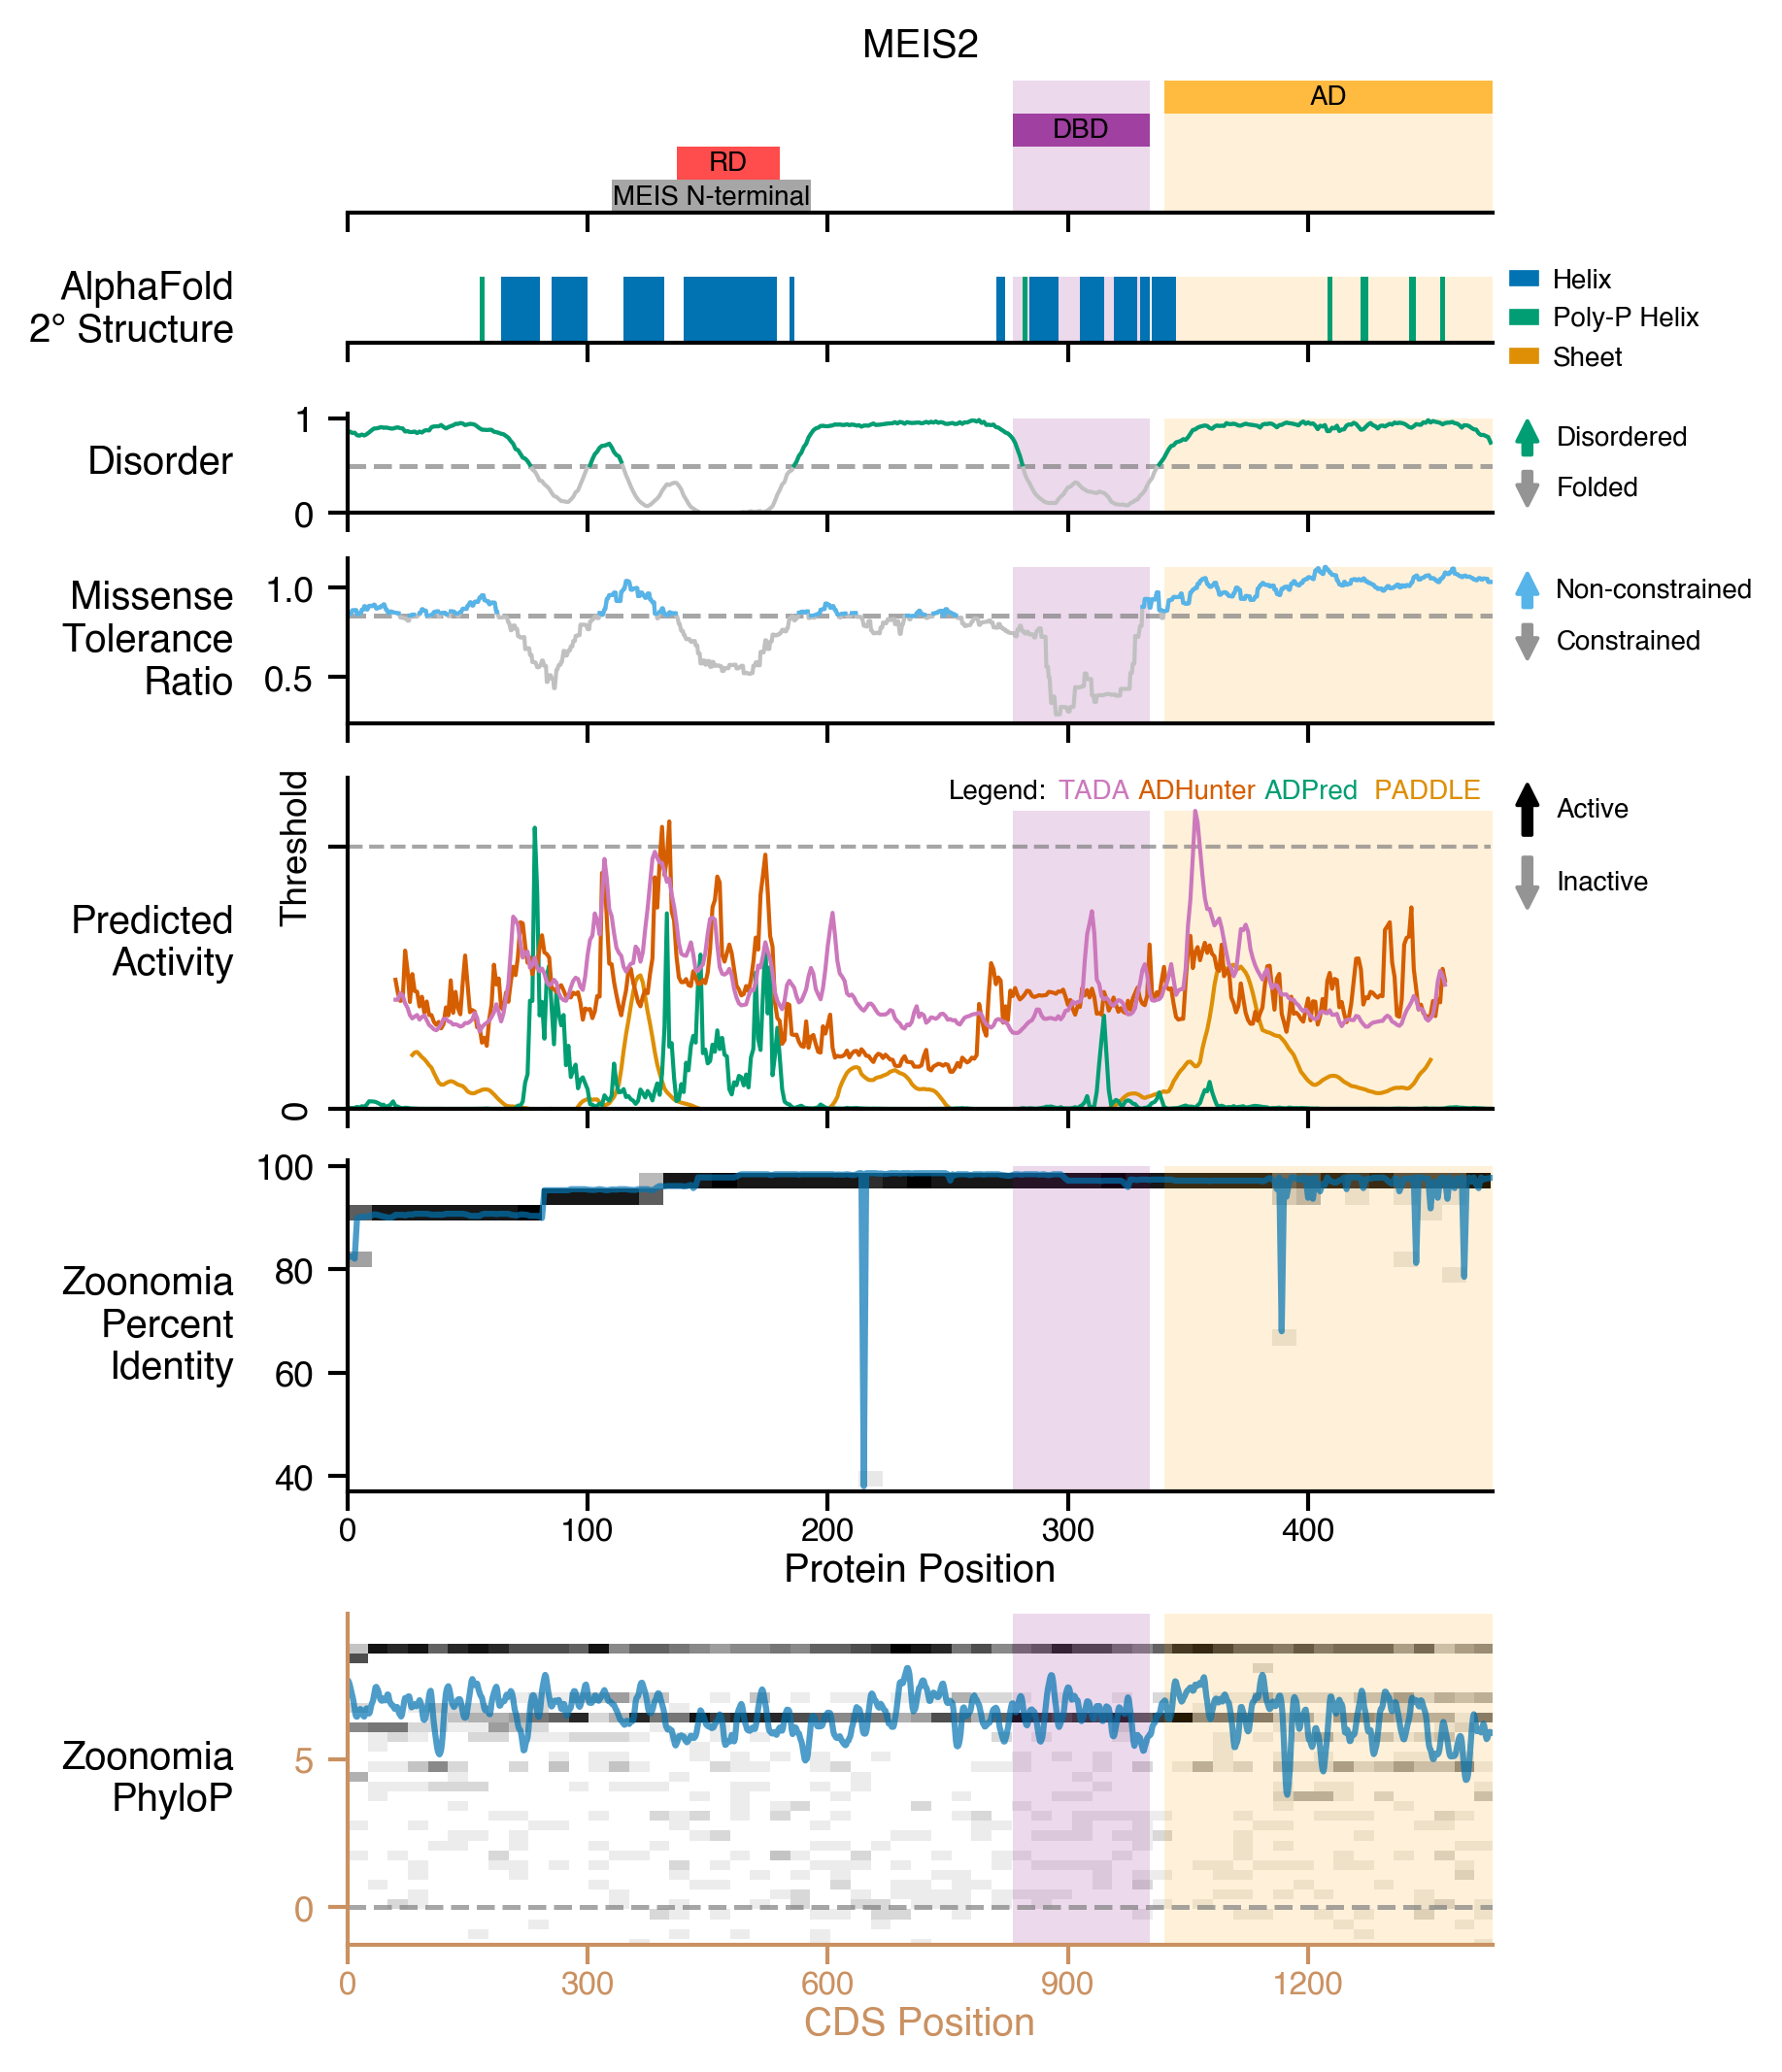

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


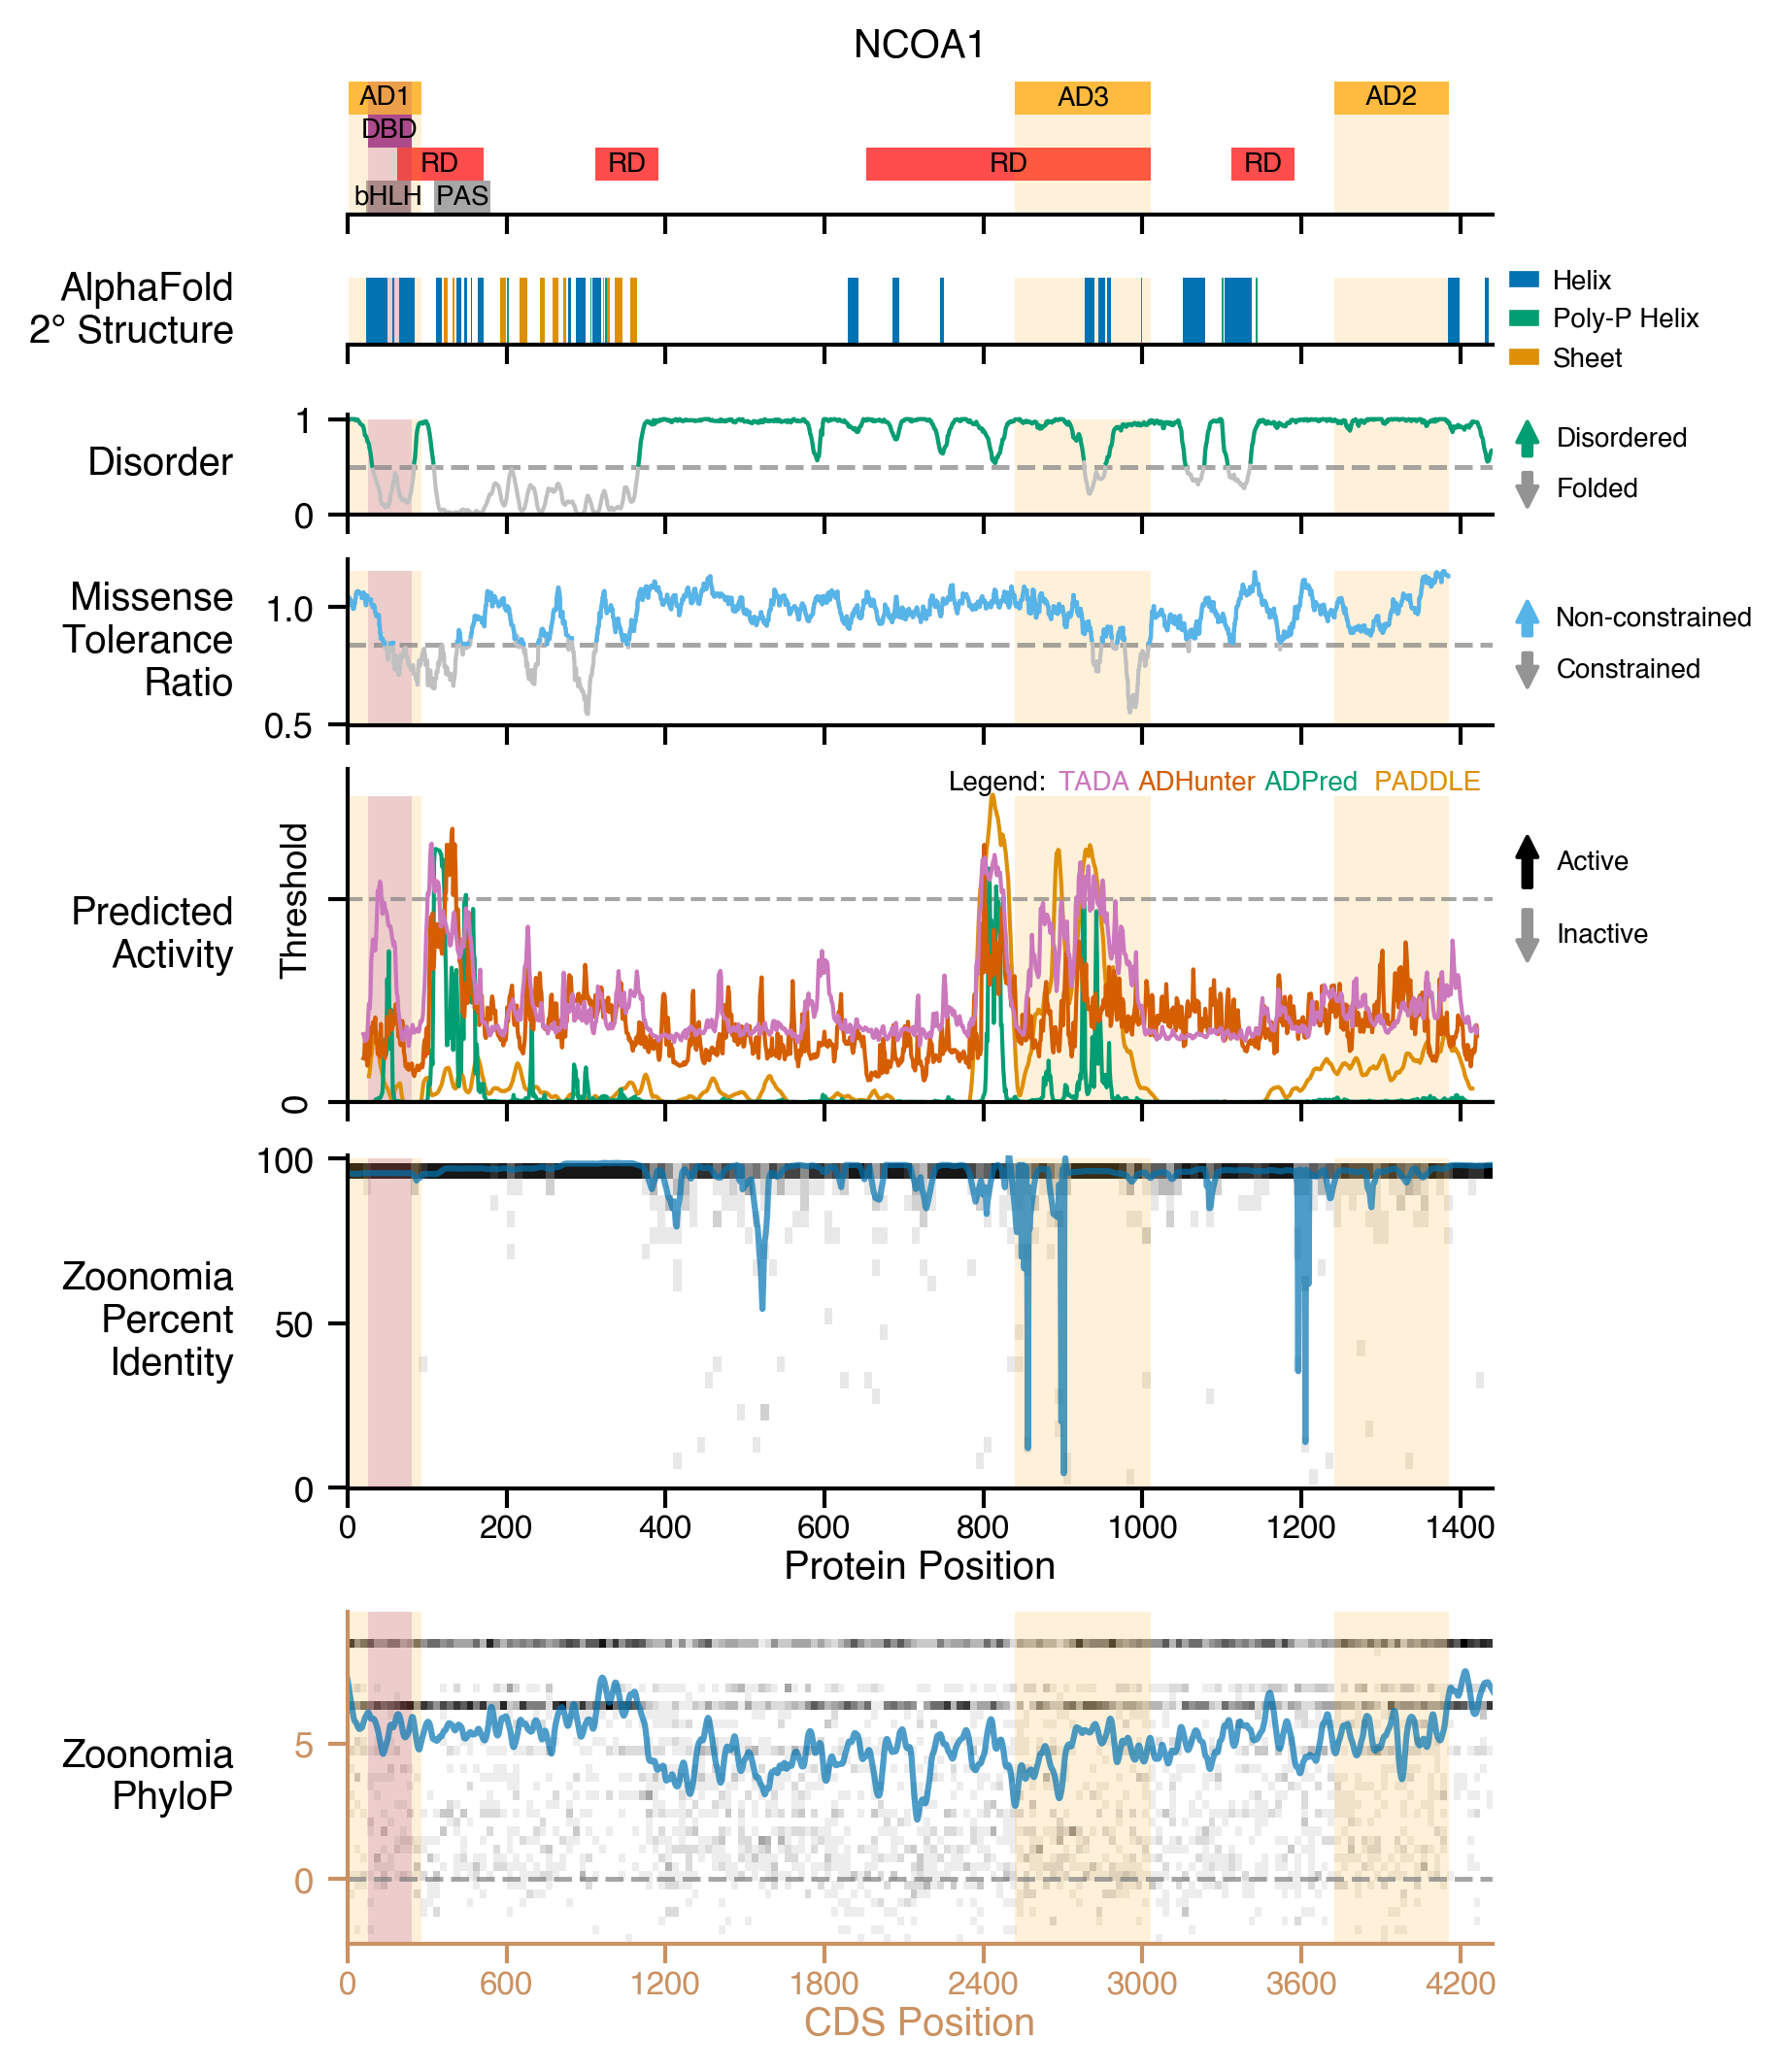

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


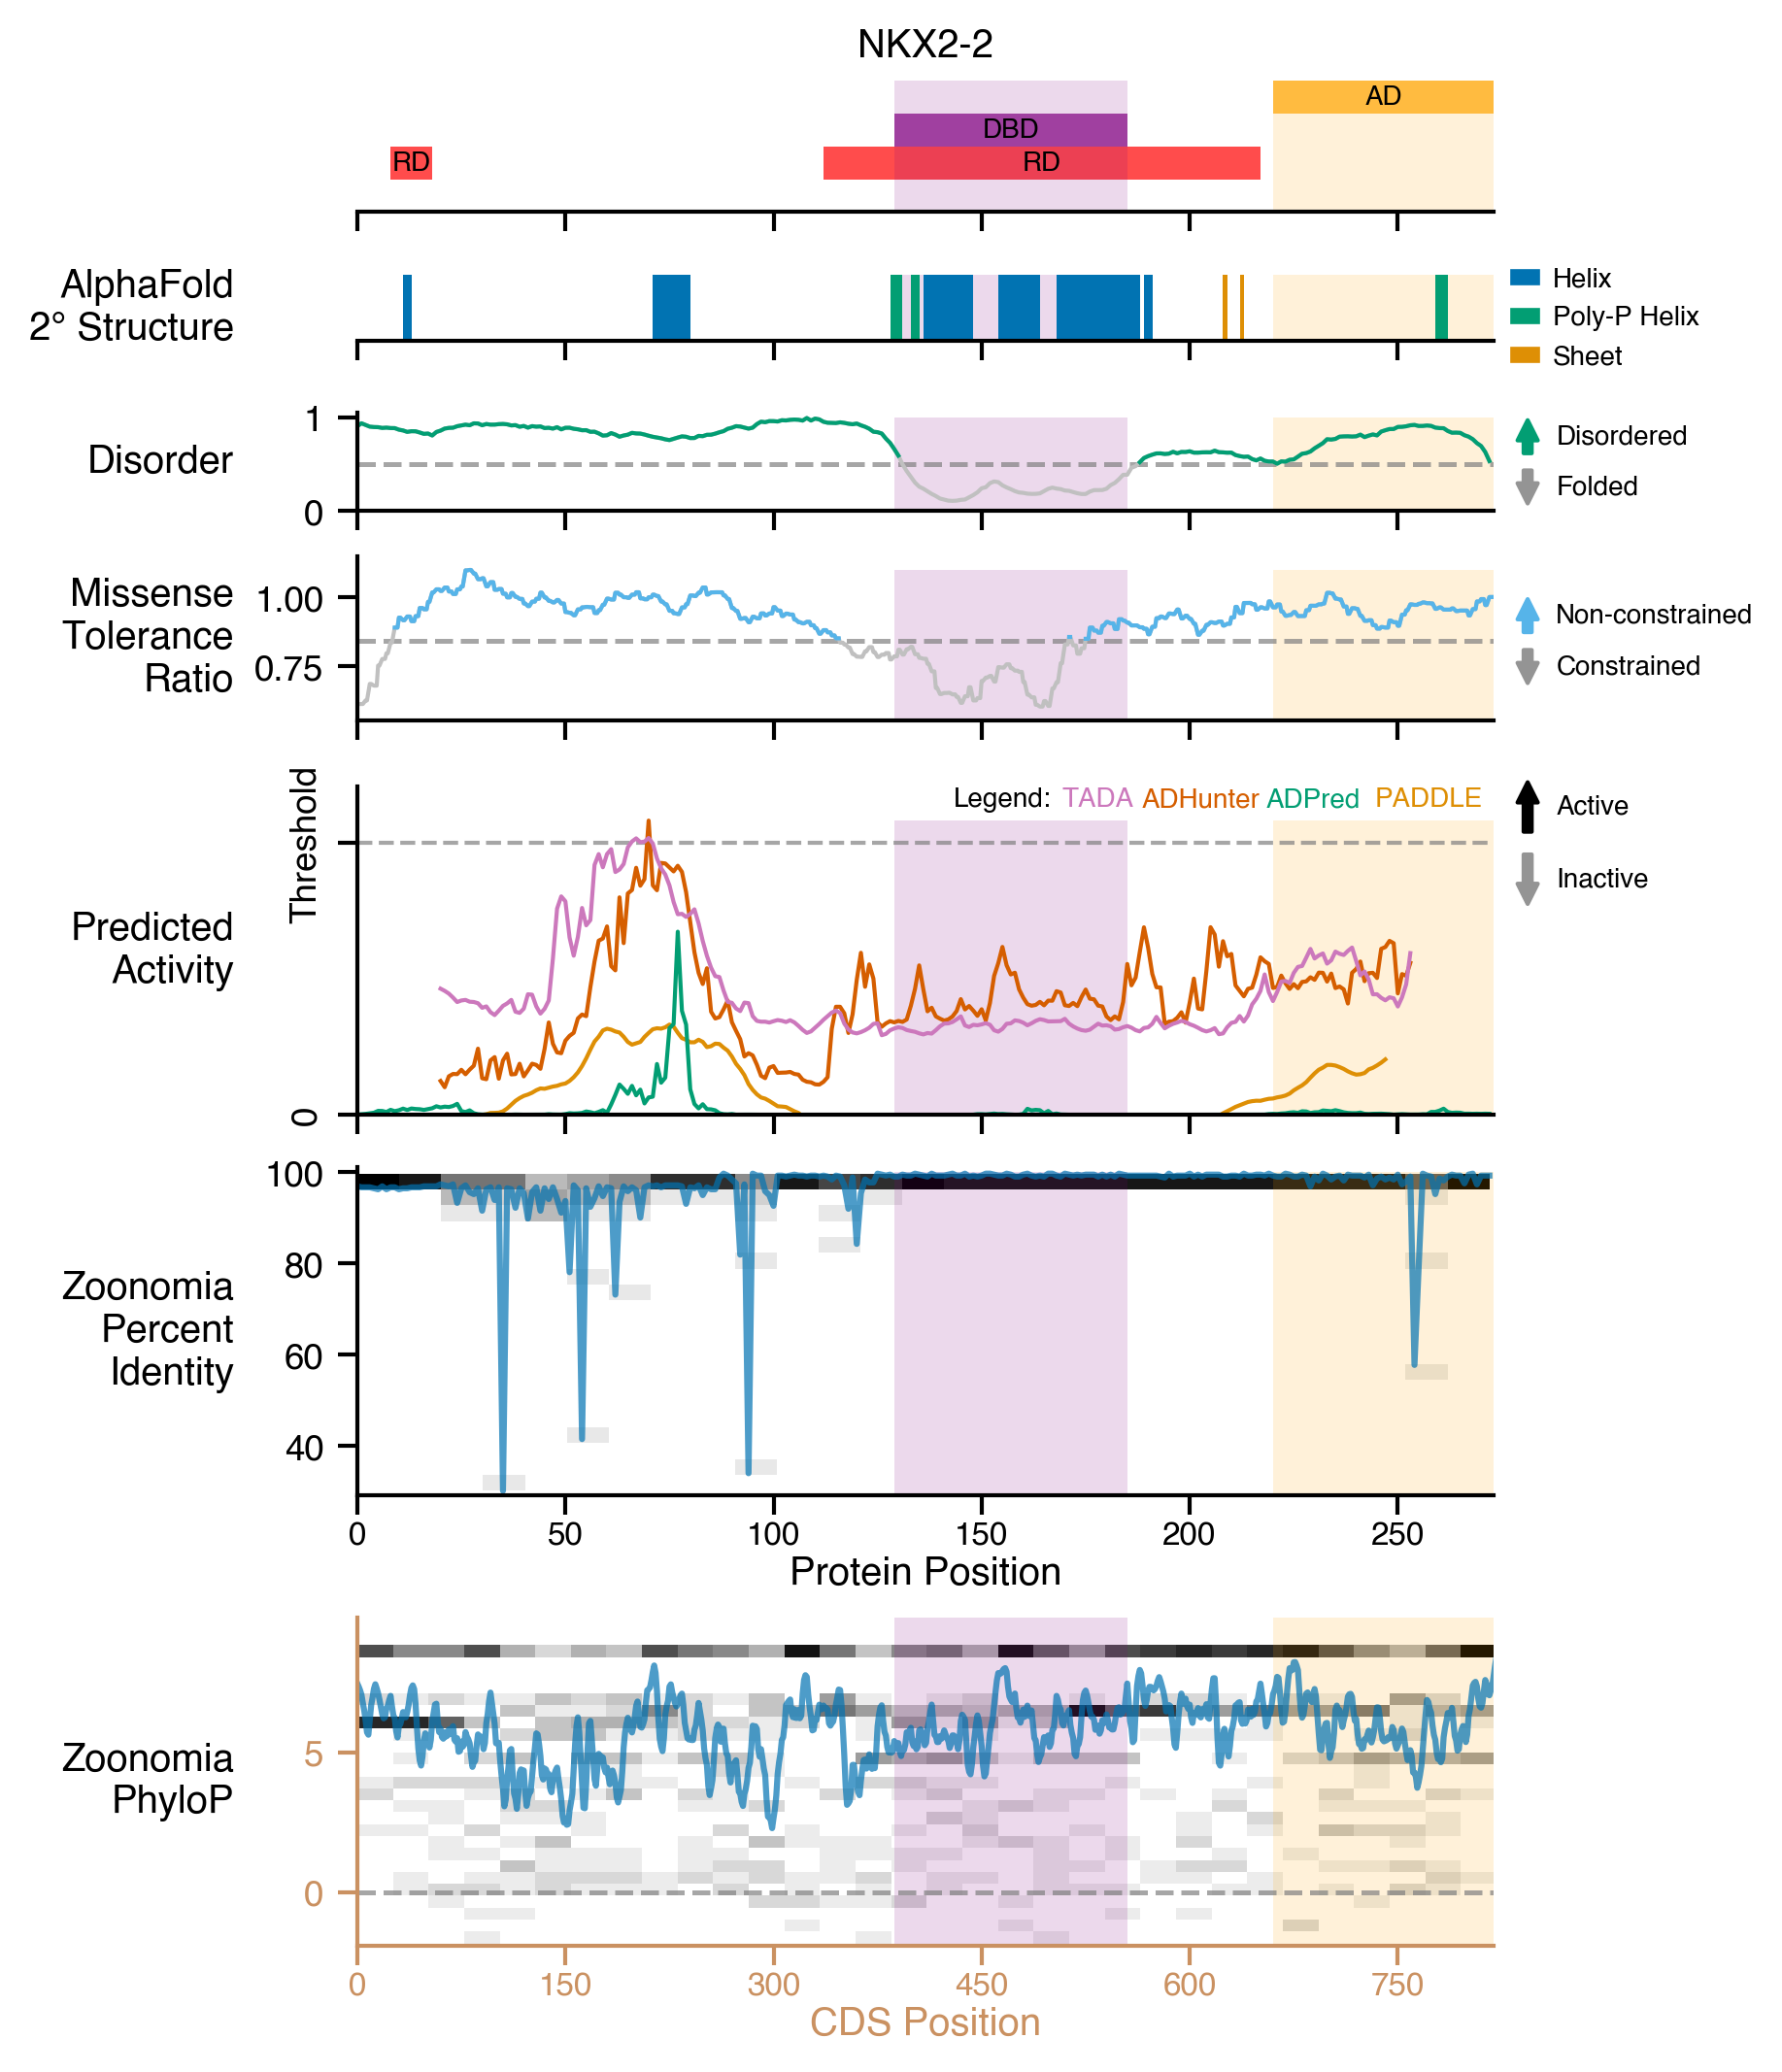

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


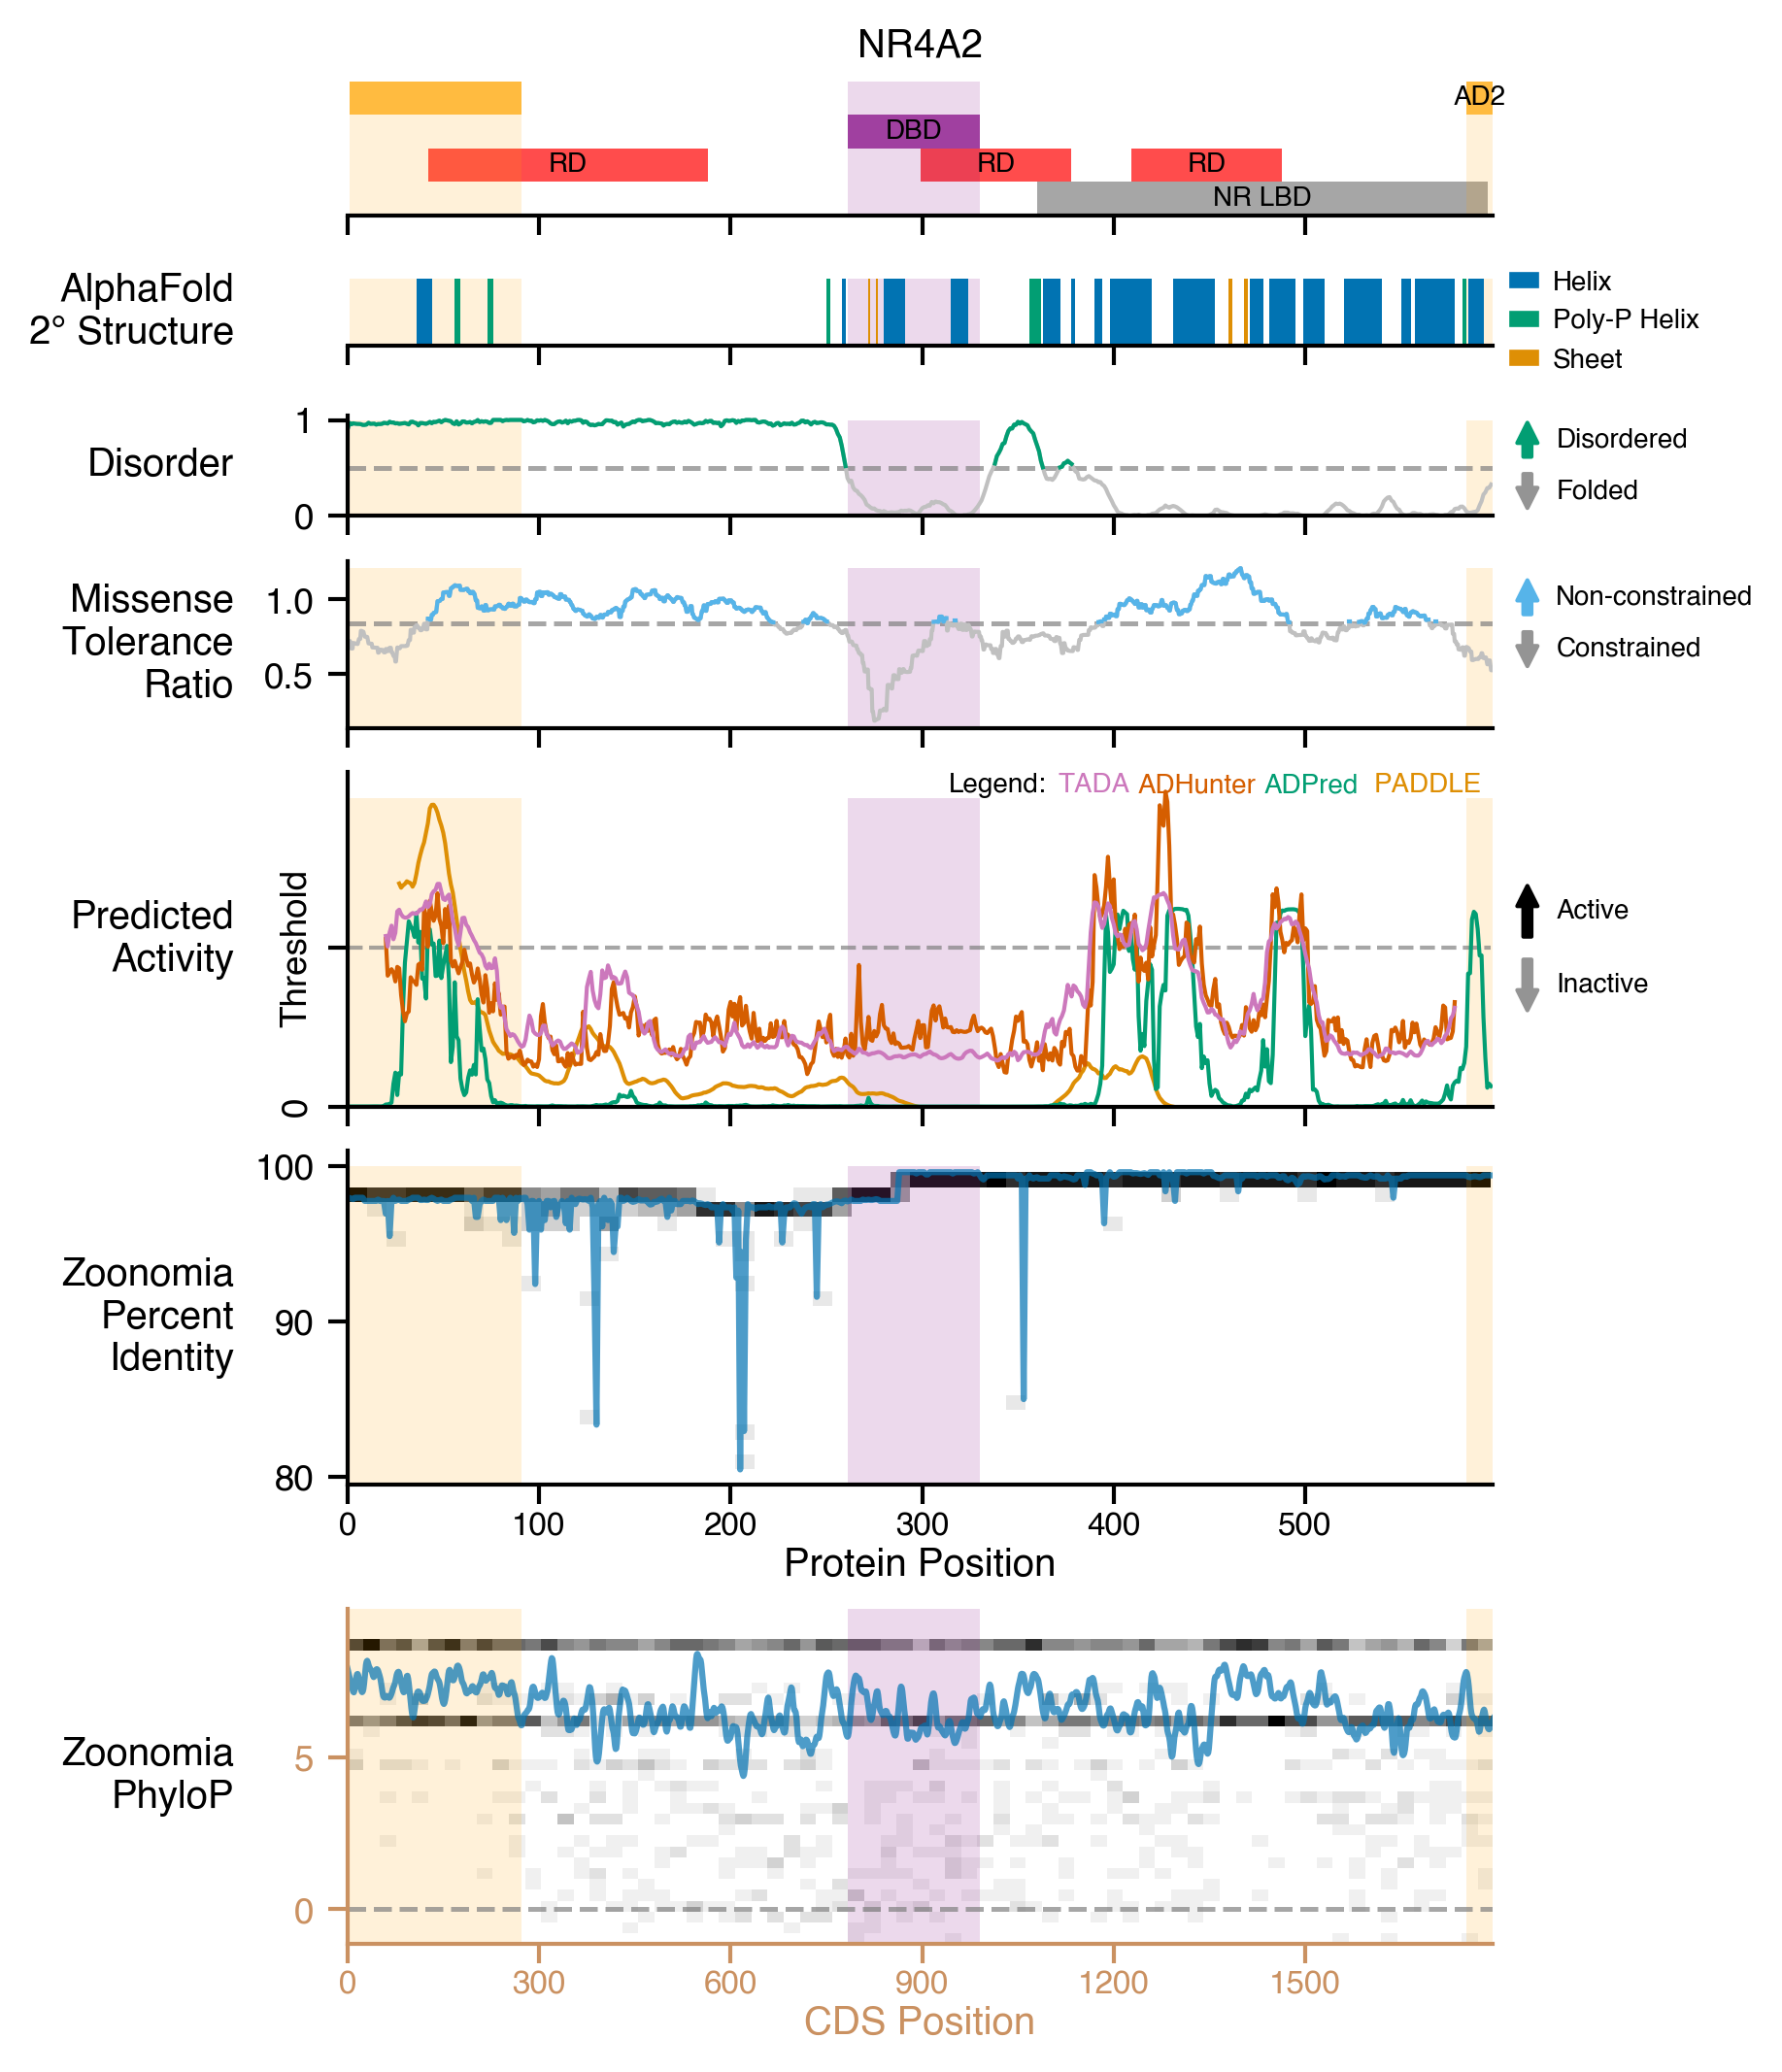

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


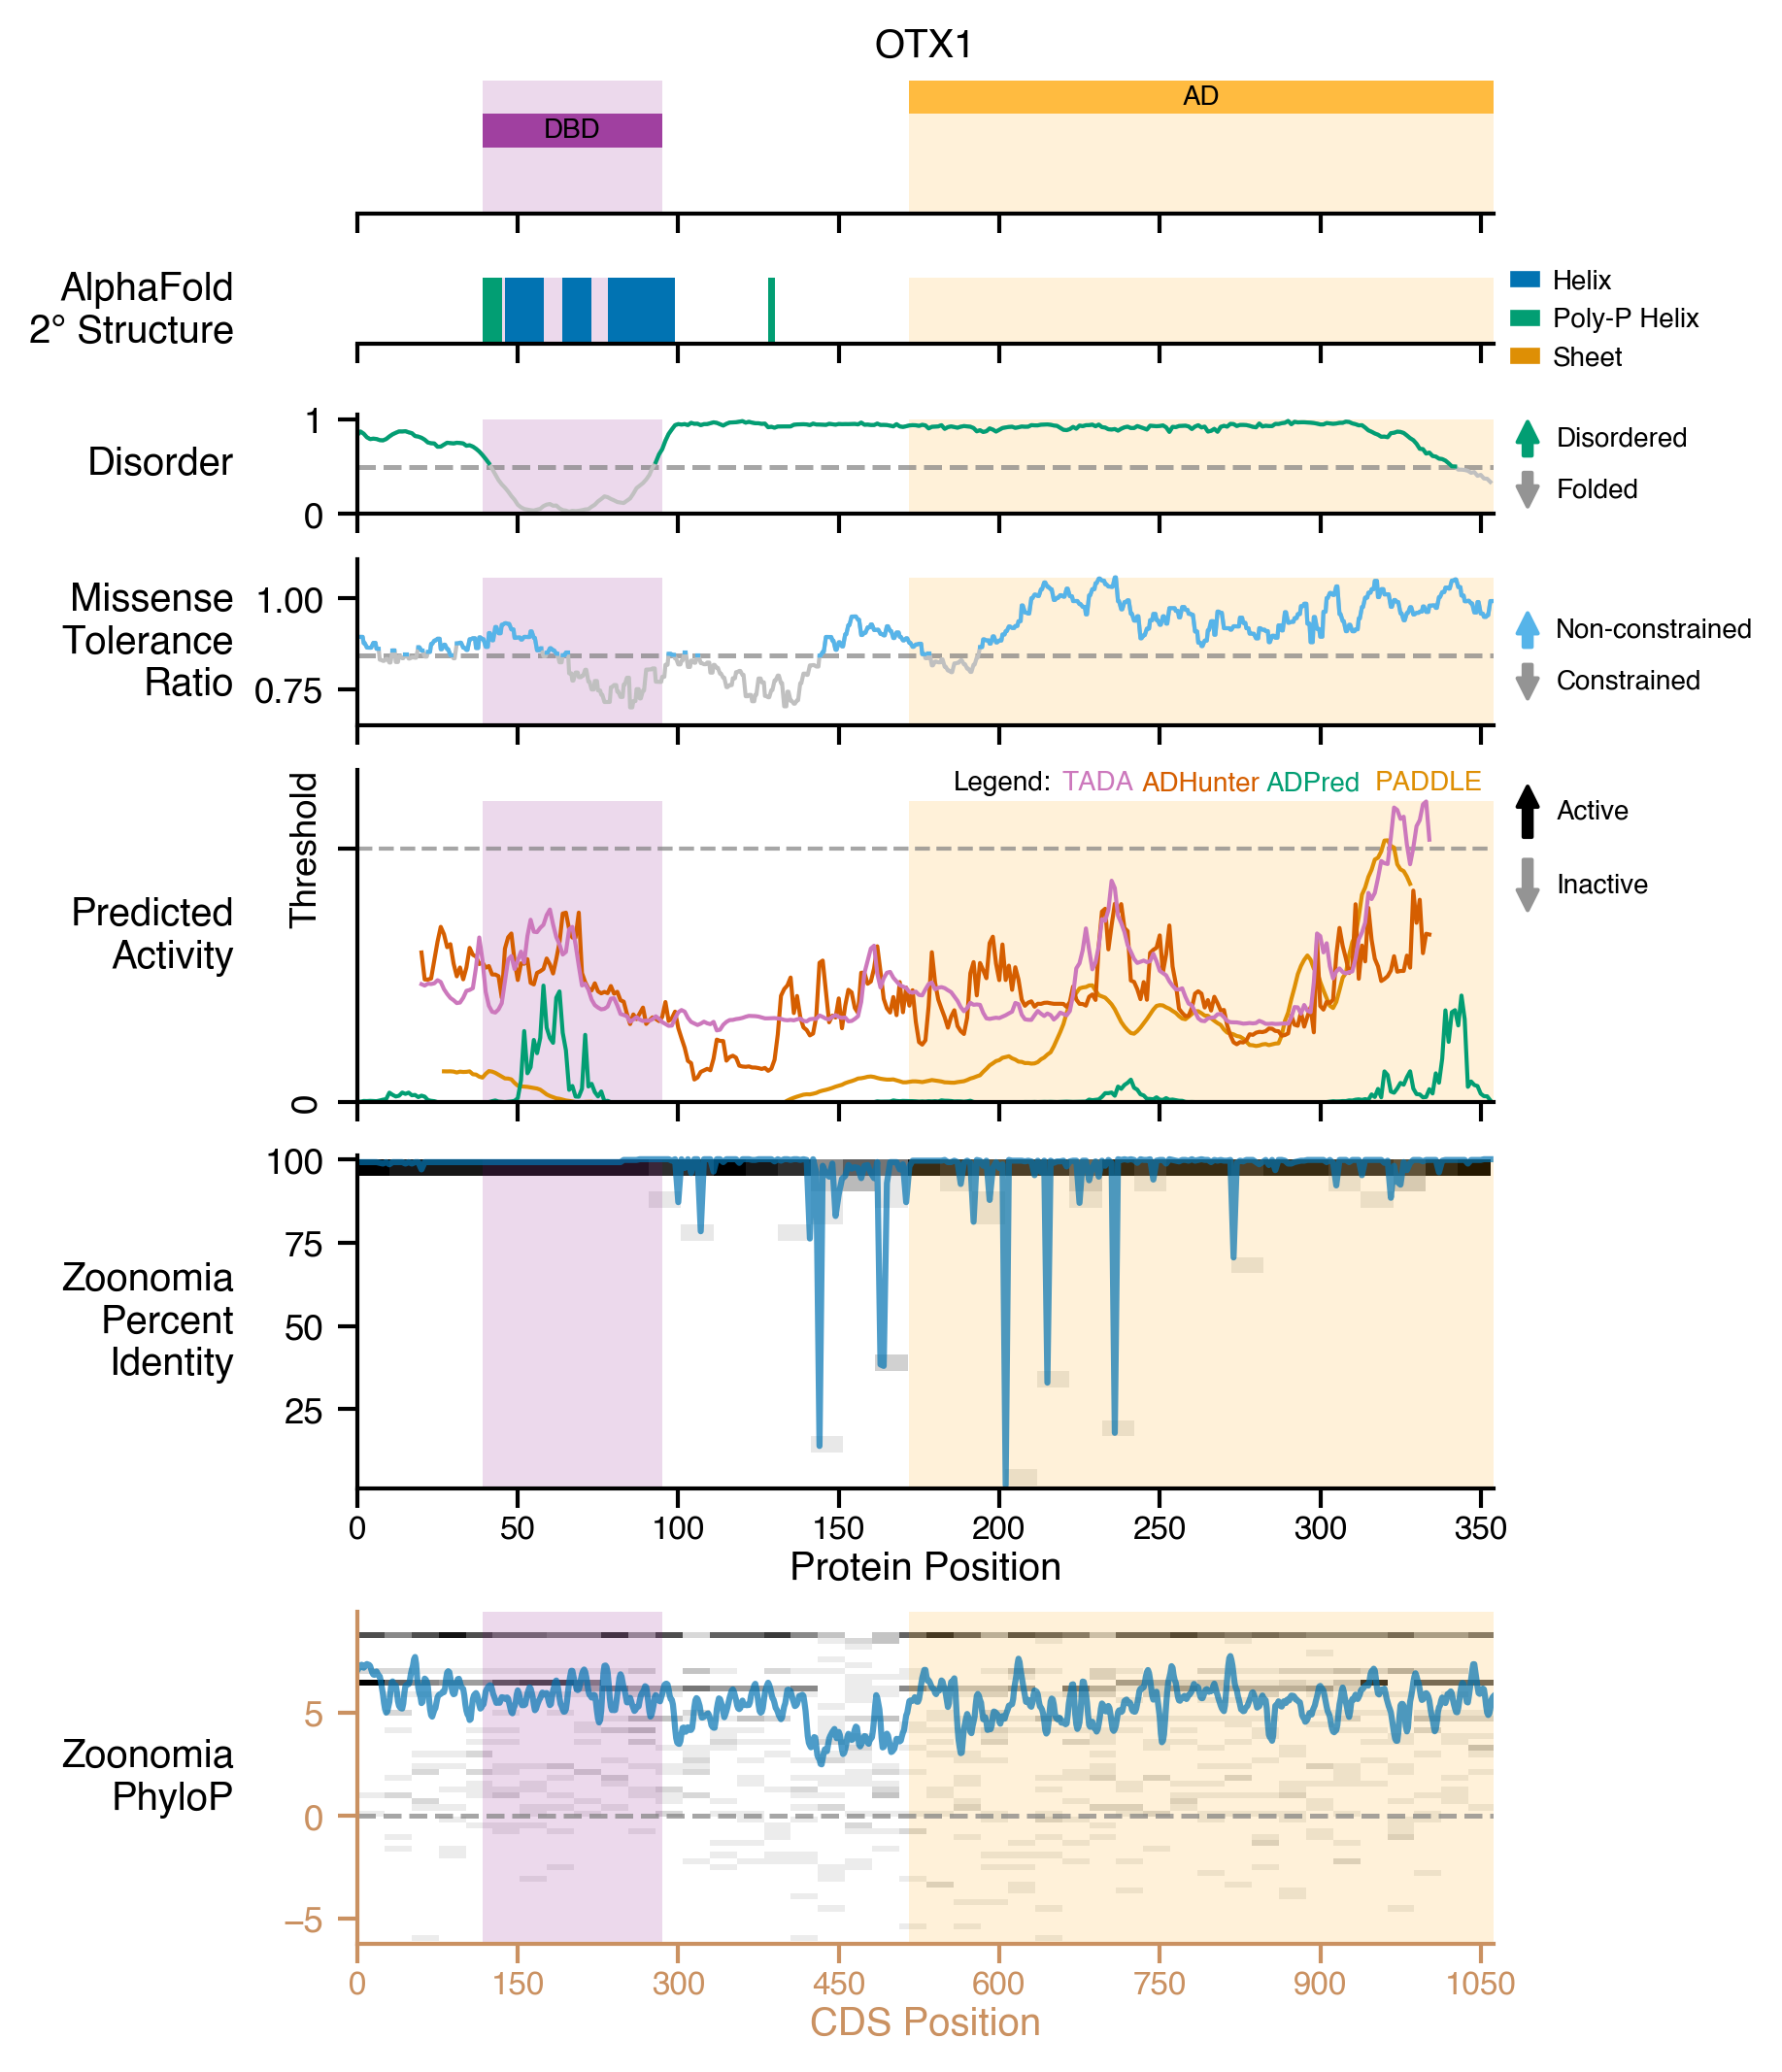

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


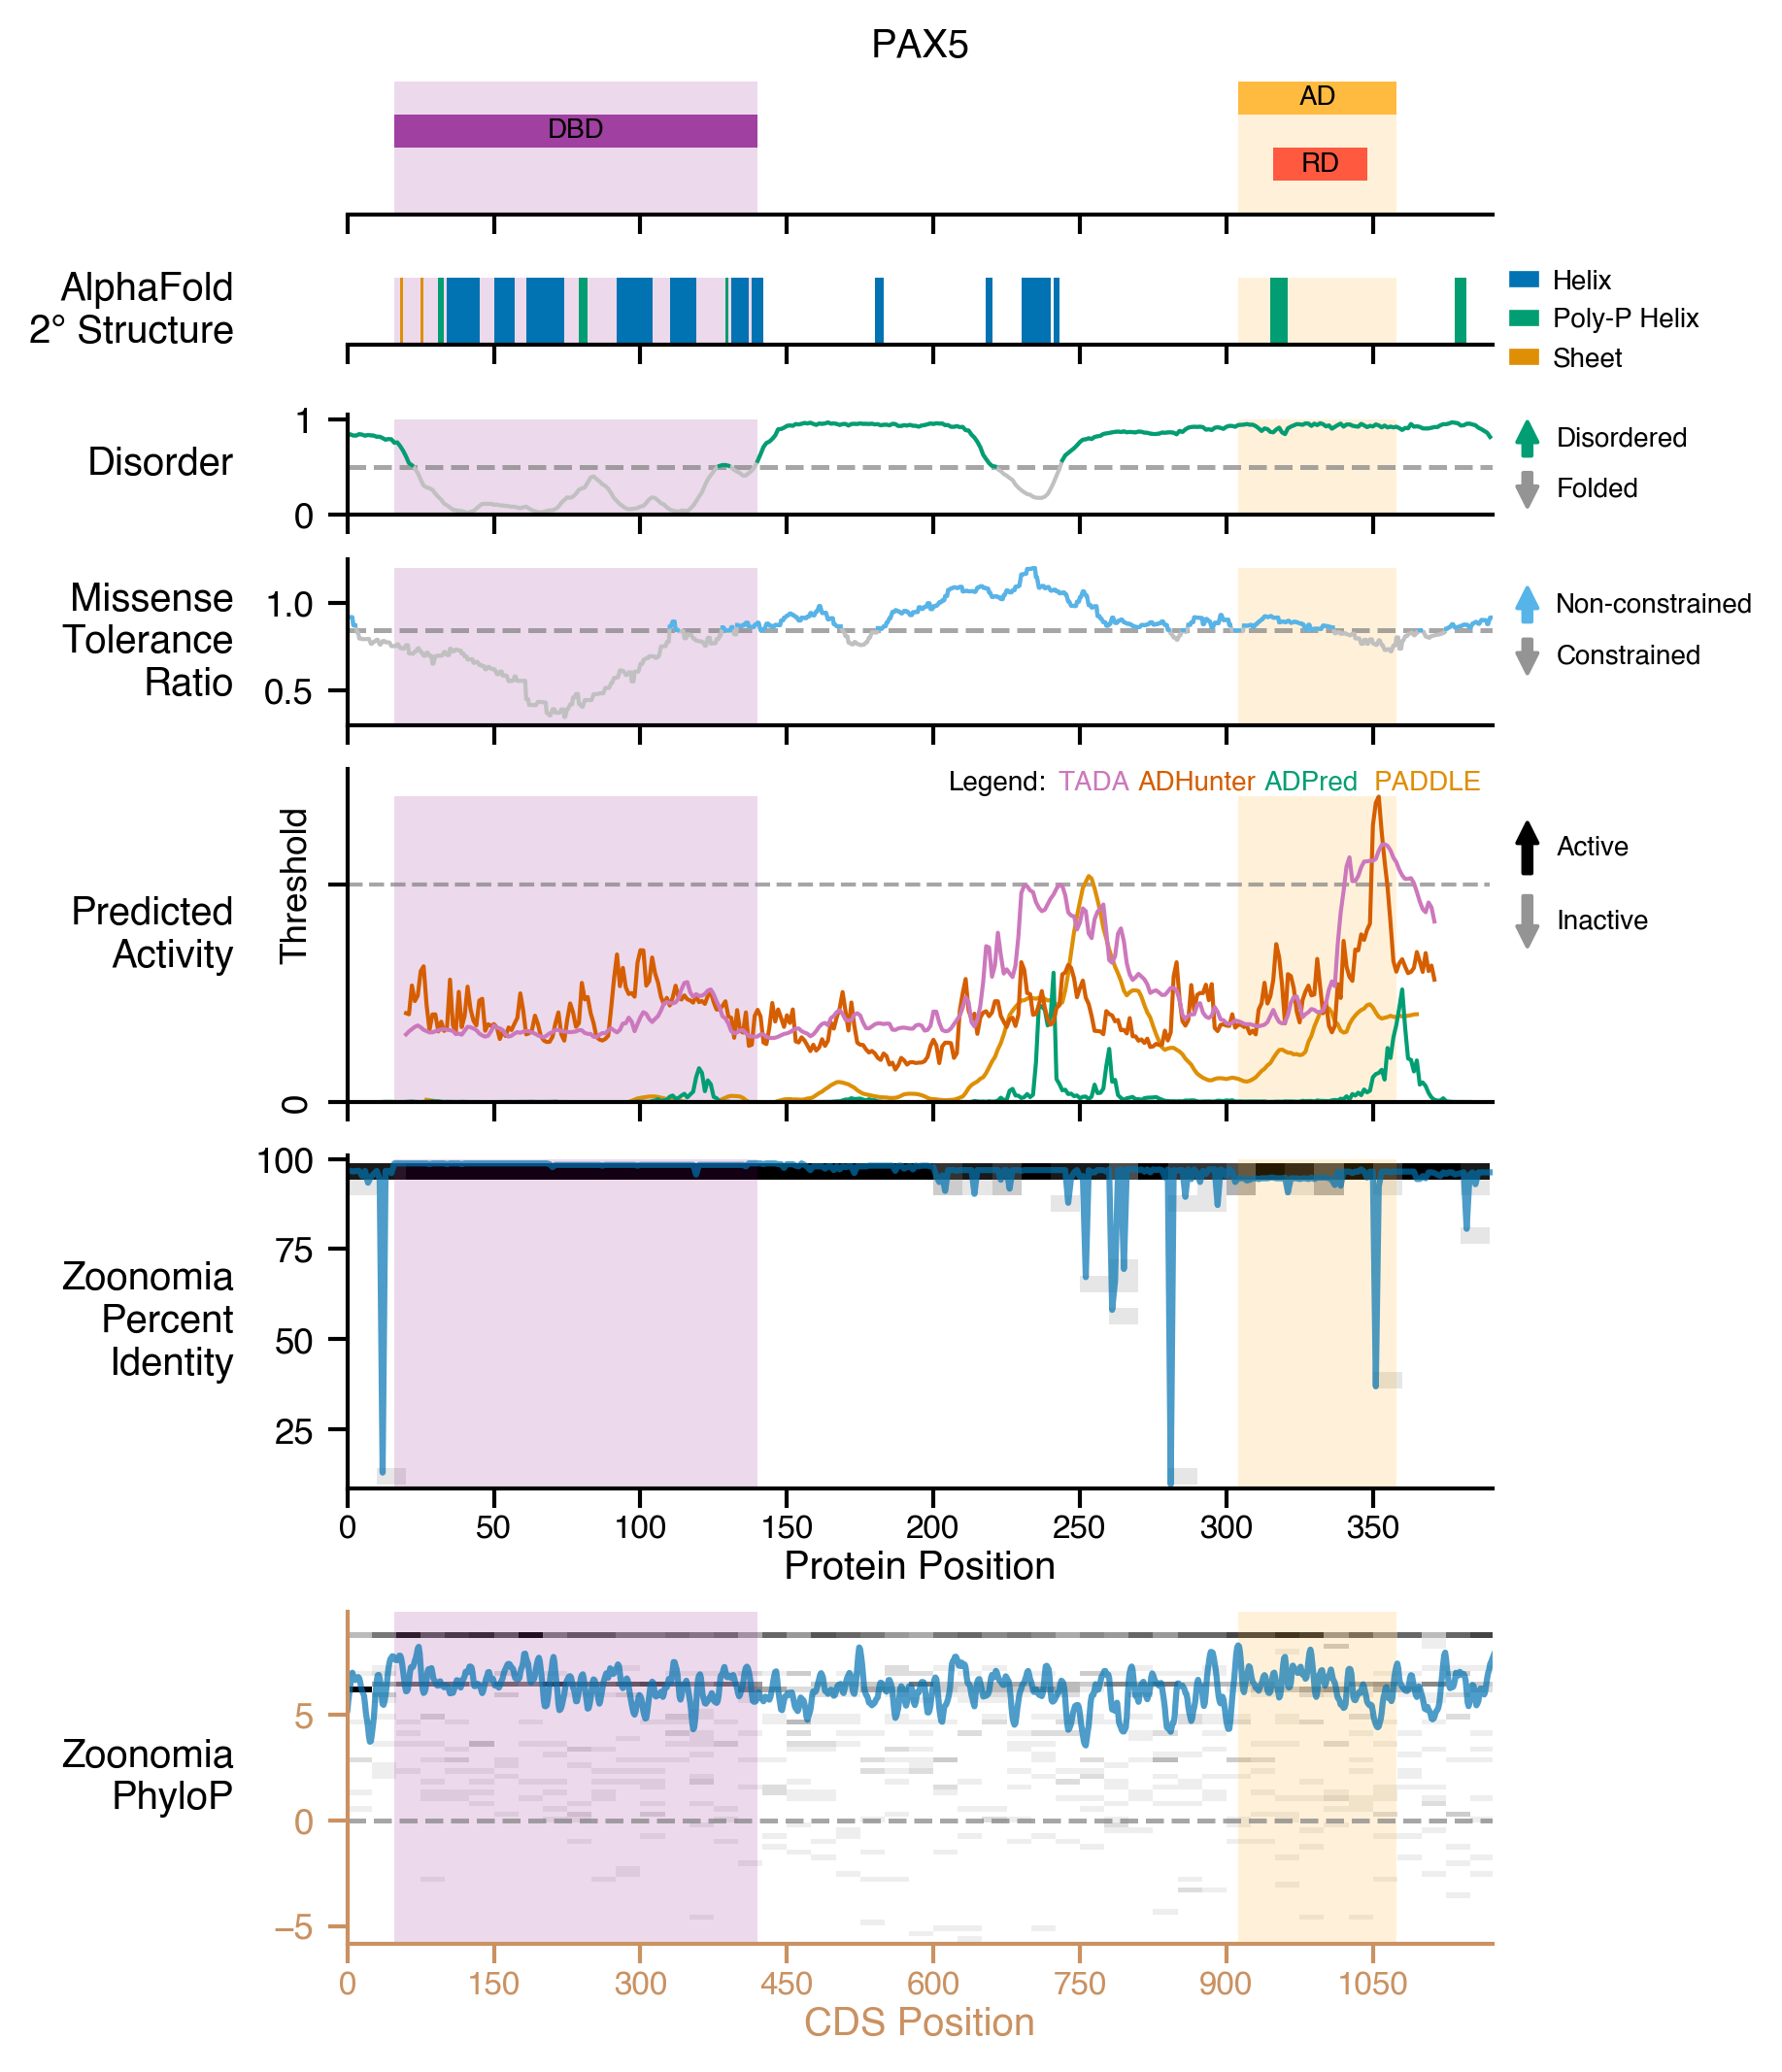

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


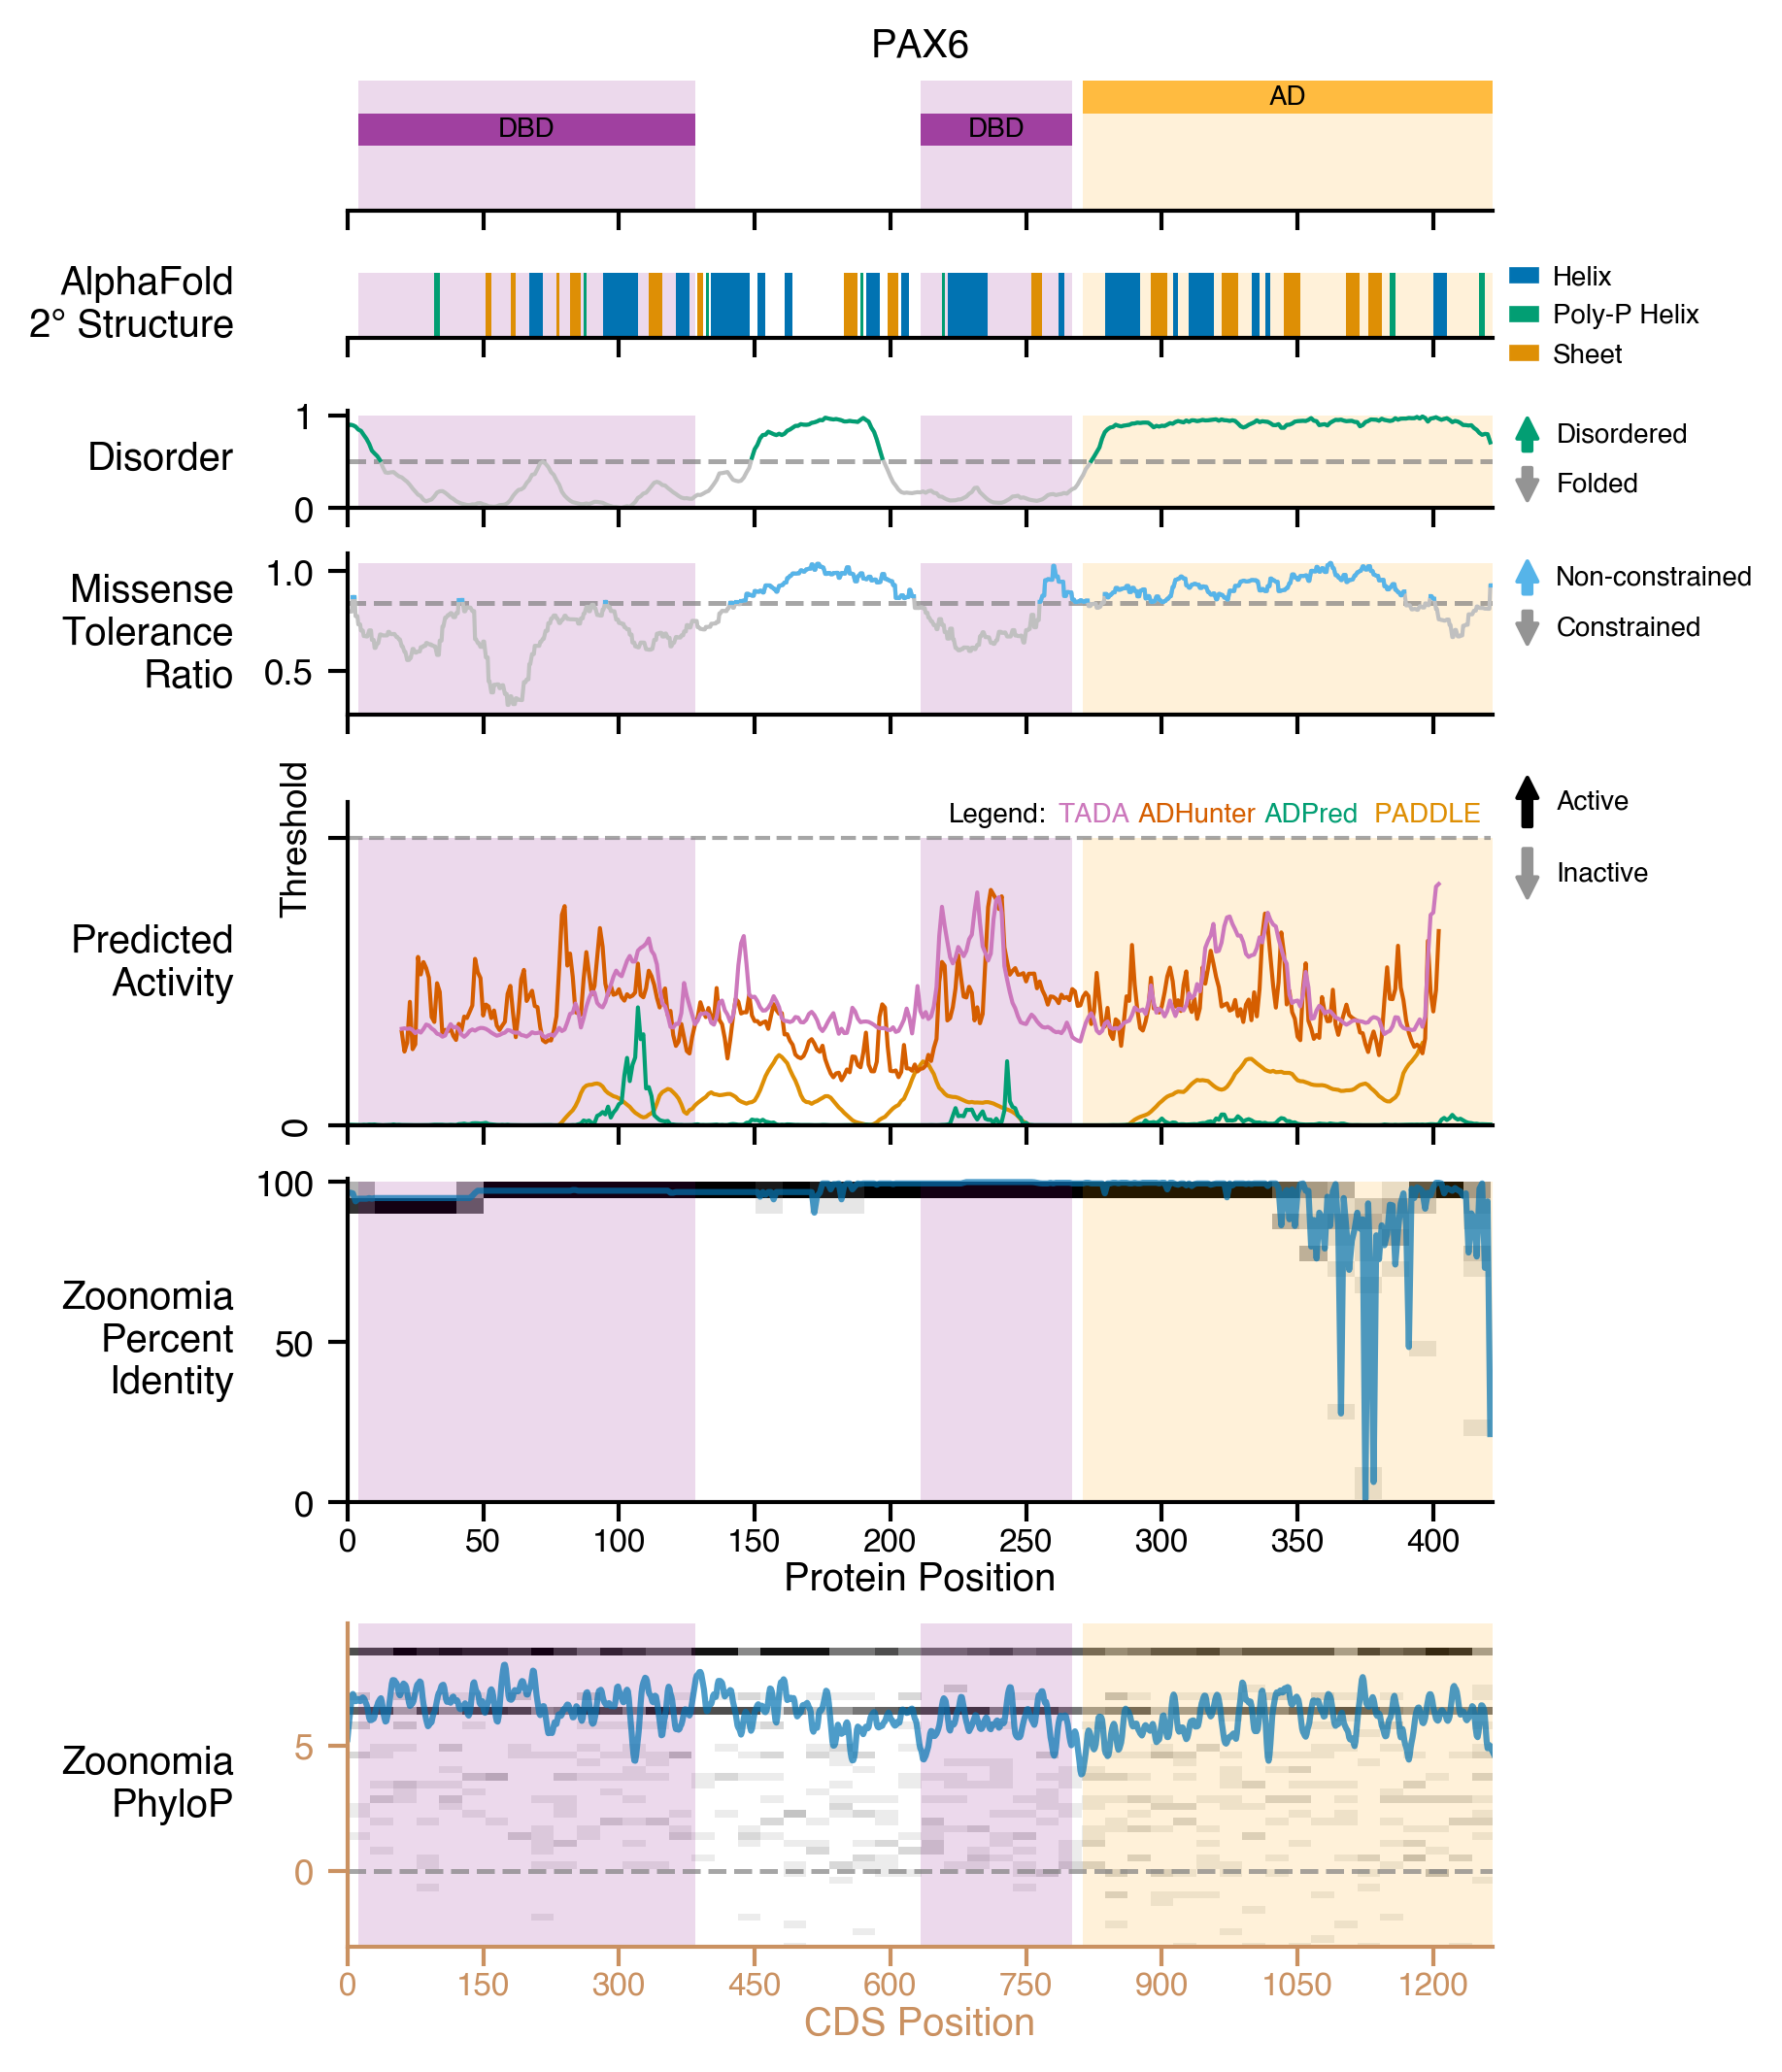

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


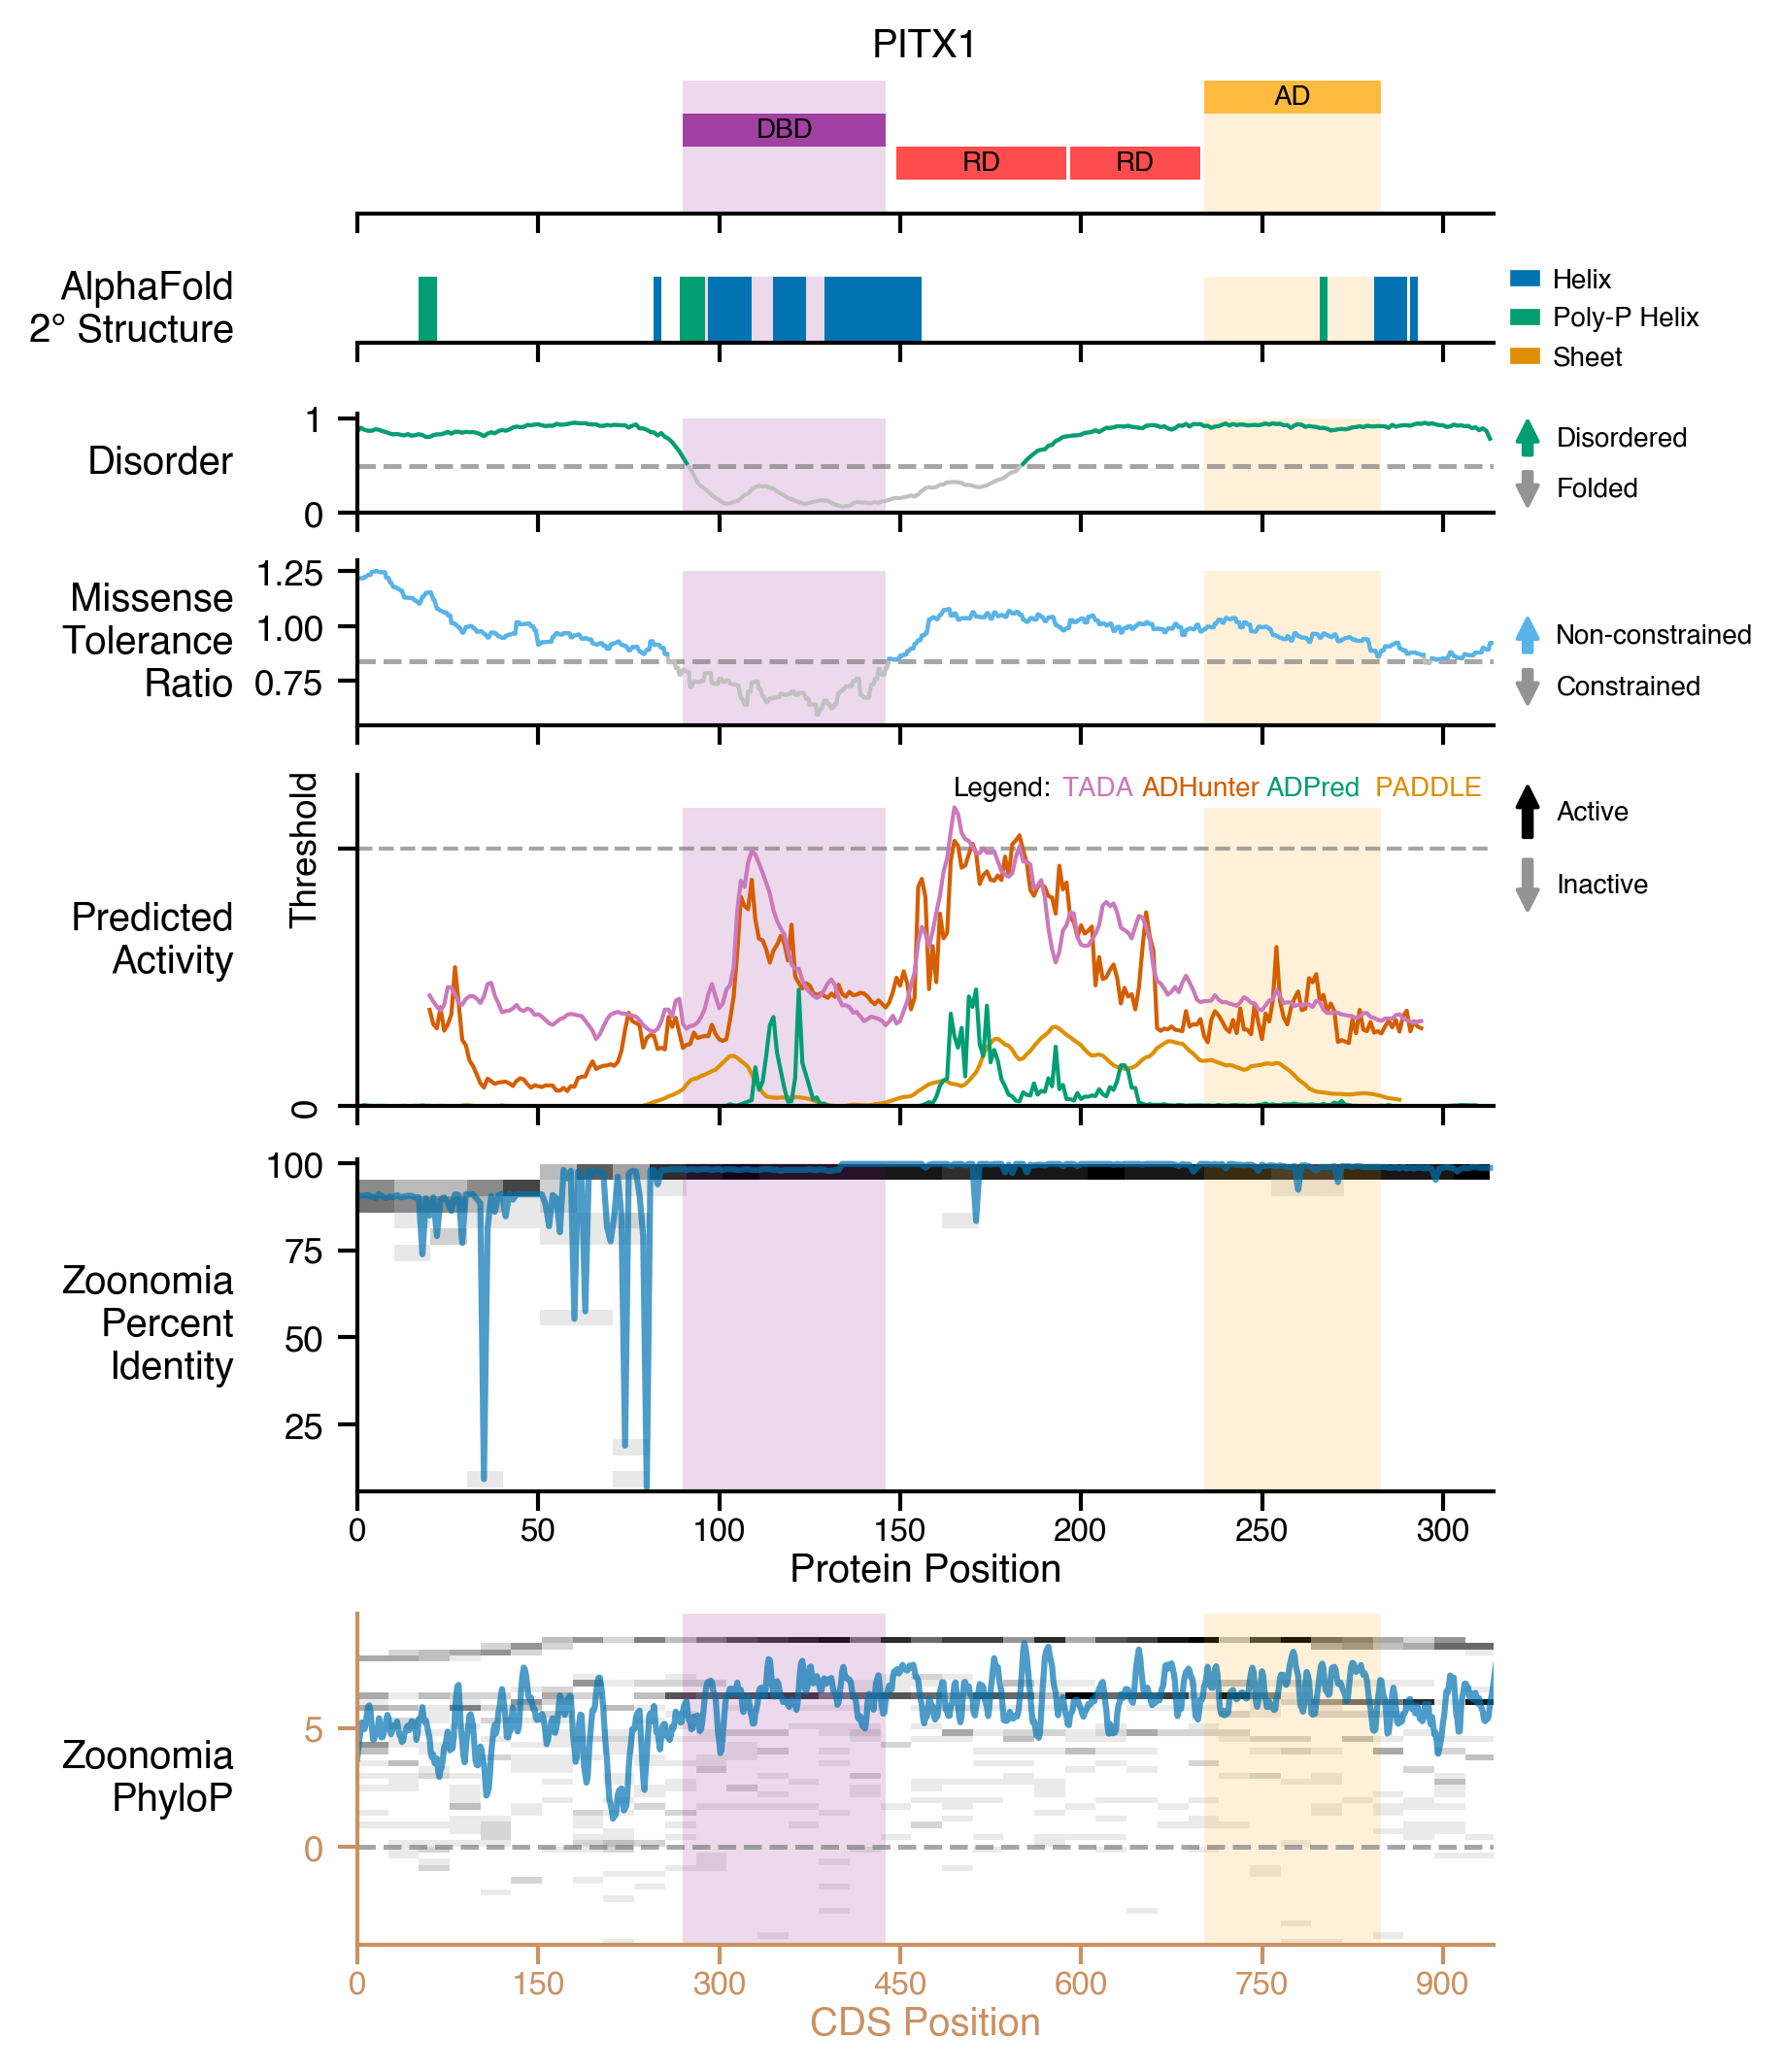

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [42]:
#for i in [cc_TFs.index[0]]:
for i in cc_TFs.dropna().index:
    fig, axs = plt.subplots(7, 1, figsize=(6, 7), sharex=True, height_ratios = [0.4, 0.2, 0.3, 0.5, 1, 1, 1], layout = 'constrained')
    ax7, ax6, ax5, ax4, ax3, ax2, ax1 = axs
    
    ax7.set_title(cc_TFs["Gene"].iloc[i])
        
    ## CDS CONSERVATION
    plot_cds_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax1, x_axis_spacing = 300);

    second_axis_color = sns.color_palette('colorblind')[5]

    ax2.text(0.5, -0.27, "Protein Position", color="black", horizontalalignment='center', transform=ax2.transAxes, fontsize = 'medium')

    ax1.set_xlabel("")
    ax1.spines["left"].set_color(second_axis_color)
    ax1.xaxis.label.set_color(second_axis_color)
    ax1.tick_params(axis='y', colors=second_axis_color)

    ax1.spines["bottom"].set_color(second_axis_color)
    ax1.tick_params(axis='x', colors=second_axis_color)
    ax1.set_xticklabels([])

    full_len = cc_TFs["len"].iloc[i]
    for x_tick in ax1.get_xticks()[:-1]:
        #ax1.text(x_tick, min(ax1.get_yticks()) + 1, int(x_tick * 3), color=sns.color_palette('muted')[1], horizontalalignment='center')
        
        ax1.text(x_tick / full_len, -0.15, int(x_tick * 3), color=second_axis_color, horizontalalignment='center', transform=ax1.transAxes, fontsize = 'small')

    ax1.text(0.5, -0.27, "CDS Position", color=second_axis_color, horizontalalignment='center', transform=ax1.transAxes, fontsize = 'medium')


    # PROT CONSERVATION
    plot_prot_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax2);
    
    
    for x_tick in ax2.get_xticks()[:-1]:
        #ax1.text(x_tick, min(ax1.get_yticks()) + 1, int(x_tick * 3), color=sns.color_palette('muted')[1], horizontalalignment='center')
                
        ax2.text(x_tick / full_len, -0.15, int(x_tick), color='black', horizontalalignment='center', transform=ax2.transAxes, fontsize = 'small')


    ## PREDICTIONS
    plot_preds(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i],
              ax = ax3);
    # add_custom_legend({"PADDLE" : sns.color_palette('colorblind')[1],
    #                    "ADPred" : sns.color_palette('colorblind')[2],
    #                    "ADHunter" : sns.color_palette('colorblind')[3],
    #                    "TADA" : sns.color_palette('colorblind')[4]}, ax = ax3)


    ## MISSENSE TOLERANCE RATIO
    plot_mtr_trace(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                 ax = ax4)
    # add_custom_legend({"Non-MTR\n-constrained" : sns.color_palette('colorblind')[-1],
    #                    "MTR\n-constrained" : sns.color_palette('colorblind')[-3]}, ax = ax4)
                       

    ## DISORDER
    plot_disorder(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                 ax = ax5)
    add_custom_legend_arrows(top_color = sns.color_palette('colorblind')[2],
                             top_label = "Disordered",
                             bottom_color = sns.color_palette('colorblind')[-3],
                             bottom_label = "Folded", ax = ax5, 
                     center = 0.5, length = 0.5, padding = 0.005)


    
    ## ALPHAFOLD DOMAINS
    plot_af_domains(cc_TFs["Gene"].iloc[i],
                cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                 ax = ax6)
    ax6.set_ylabel("AlphaFold\n2° Structure")
    add_custom_legend({"Helix" : sns.color_palette('colorblind')[0],
                       "Poly-P Helix": sns.color_palette('colorblind')[2],
                       "Sheet" : sns.color_palette('colorblind')[1]}, ax = ax6, bbox_to_anchor = (1, 1.5))
    ax6.spines['left'].set_color("white")
    


    ## ANNOTATIONS
    plot_annots(cc_TFs["DBD_ranges"].iloc[i], 
                cc_TFs["AD_ranges"].iloc[i], 
                cc_TFs["RD_ranges"].iloc[i], 
                cc_TFs["len"].iloc[i], 
                ax = ax7, 
                box_height = 0.25,
               other_domains_gene = cc_TFs["Gene"].iloc[i], 
                RD = True)

    # ax5.set_yticklabels([])    
    ax7.set_xlabel("")
    # ax5.tick_params(axis='y', colors='white')
    ax7.set_ylabel("")

    for ax in axs:
        ax.set_ylabel(ax.get_ylabel(), rotation=0, labelpad = 5, va = "center", ha = "right")
    
    #fig.tight_layout()
    fig.align_ylabels(axs)
    fig.subplots_adjust(hspace=0)

    plt.show()
    
    fig.savefig("../output/cc_TF_summary_vis/" + cc_TFs["Gene"].iloc[i] + ".pdf", bbox_inches='tight')
    fig.savefig("../output/cc_TF_summary_vis/" + cc_TFs["Gene"].iloc[i] + ".png", bbox_inches='tight')

    #add_text_annots("../output/cc_TF_summary_vis/" + cc_TFs["Gene"].iloc[i] + ".png")

In [43]:
# Directory to save 
# ! mkdir ../output/cc_TF_summary_vis/

In [44]:
# for i in [cc_TFs.index[0]]:
# #for i in cc_TFs.dropna().index:
#     fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(6.5, 8), sharex=True, height_ratios = [1, 1, 1, 0.25, 0.5], layout='constrained')

#     ax1.set_title(cc_TFs["Gene"].iloc[i])
        
#     plot_cds_trace(cc_TFs["Gene"].iloc[i],
#                 cc_TFs["DBD_ranges"].iloc[i], 
#                 cc_TFs["AD_ranges"].iloc[i], 
#                 cc_TFs["RD_ranges"].iloc[i],
#               ax = ax1, x_axis_spacing = 300);

#     second_axis_color = sns.color_palette('colorblind')[5]
#     ax1.spines["bottom"].set_color(second_axis_color)
#     ax1.tick_params(axis='x', colors=second_axis_color)
    

#     full_len = cc_TFs["len"].iloc[i]
#     for x_tick in ax1.get_xticks()[:-1]:
#         #ax1.text(x_tick, min(ax1.get_yticks()) + 1, int(x_tick * 3), color=sns.color_palette('muted')[1], horizontalalignment='center')
        
#         ax1.text(x_tick / full_len, -0.09, int(x_tick * 3), color=second_axis_color, horizontalalignment='center', transform=ax1.transAxes, fontsize = 8)

#     ax1.text(0.5, -0.16, "CDS Position", color=second_axis_color, horizontalalignment='center', transform=ax1.transAxes, fontsize = 9)
    
#     plot_prot_trace(cc_TFs["Gene"].iloc[i],
#                 cc_TFs["DBD_ranges"].iloc[i], 
#                 cc_TFs["AD_ranges"].iloc[i], 
#                 cc_TFs["RD_ranges"].iloc[i],
#               ax = ax2);
    
#     plot_preds(cc_TFs["Gene"].iloc[i],
#                 cc_TFs["DBD_ranges"].iloc[i], 
#                 cc_TFs["AD_ranges"].iloc[i], 
#                 cc_TFs["RD_ranges"].iloc[i],
#               ax = ax3);

    
#     plot_disorder(cc_TFs["Gene"].iloc[i],
#                 cc_TFs["DBD_ranges"].iloc[i], 
#                 cc_TFs["AD_ranges"].iloc[i], 
#                 cc_TFs["RD_ranges"].iloc[i], 
#                  ax = ax4)
    
#     plot_annots(cc_TFs["DBD_ranges"].iloc[i], 
#                 cc_TFs["AD_ranges"].iloc[i], 
#                 cc_TFs["RD_ranges"].iloc[i], 
#                 cc_TFs["len"].iloc[i], 
#                 ax5, 
#                 box_height = 0.25,
#                other_domains_gene = cc_TFs["Gene"].iloc[i], RD = True)

#     # fig.savefig("../output/cc_TF_summary_vis/" + cc_TFs["Gene"].iloc[i] + ".pdf", bbox_inches='tight')
#     # fig.savefig("../output/cc_TF_summary_vis/" + cc_TFs["Gene"].iloc[i] + ".png", bbox_inches='tight')


Not used: for text annotation of images

In [45]:
# from PIL import Image
# from PIL import ImageDraw
# from PIL import ImageFont

In [46]:
# sns.color_palette('colorblind').as_hex()[2]

In [47]:
# def add_text_annots(filepath):
#     img = Image.open(filepath)
#     width, height = img.size

#     width_scal_fac = width / 1955
#     height_scal_fac = height / 2434

#     x_pos = 1725 * width_scal_fac
        
#     I1 = ImageDraw.Draw(img)
    
#     # Custom font style and font size
#     myFont = ImageFont.truetype('Helvetica', 32)
     
#     # Disorder legend
#     I1.text((x_pos, 310), "Disordered", font=myFont, fill = sns.color_palette('colorblind').as_hex()[2])
#     I1.text((x_pos, 345), "Folded", font=myFont, fill ="gray")
    
#     # MTR legend
#     I1.text((x_pos-10, 580), "Non-Constrained", font=myFont, fill =sns.color_palette('colorblind').as_hex()[9])
#     I1.text((x_pos-10, 615), "Constrained", font=myFont, fill ="gray")
    

#     # Activity legend
    
#     I1.text((x_pos, 860), "PADDLE", font=myFont, fill =sns.color_palette('colorblind').as_hex()[1])
#     I1.text((x_pos, 895), "ADPred", font=myFont, fill =sns.color_palette('colorblind').as_hex()[2])
#     I1.text((x_pos, 930), "ADHunter", font=myFont, fill =sns.color_palette('colorblind').as_hex()[3])
#     I1.text((x_pos, 965), "TADA", font=myFont, fill =sns.color_palette('colorblind').as_hex()[4])
#     #I1.text((1730, 580), "Non-Constrained", font=myFont, fill =sns.color_palette('colorblind').as_hex()[9])
    
    
    
    
#     # ax.text(0.99, 0.96, "PADDLE", ha = 'right', va = 'center', color = sns.color_palette('colorblind')[1], transform=ax.transAxes, fontsize = 8)
#     # ax.text(0.82, 0.96, "ADPred", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[2], transform=ax.transAxes, fontsize = 8)
#     # ax.text(0.72, 0.96, "ADHunter", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[3], transform=ax.transAxes, fontsize = 8)
#     # ax.text(0.655, 0.96, "TADA", ha = 'left', va = 'center', color = sns.color_palette('colorblind')[4], transform=ax.transAxes, fontsize = 8)
#     # ax.text(0.57, 0.96, "Legend:", ha = "left", va = 'center', color = "black", transform=ax.transAxes, fontsize = 8)
    
    
#     #I1.text((28, 36), "nice Car", fill=(255, 0, 0))
#     #img.show()

#     #print(filepath.split(".png")[0])
#     img.save(filepath)

# add_text_annots("../output/cc_TF_summary_vis/" + "PITX1" + ".png")